<a id = "5" ></a>
# <span style="font-family:serif; font-size:28px;">Loading libraries and data</span>
<a id="loading"></a>

In [3]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

In [5]:
#loading data
data = pd.read_csv('../Data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [6]:
#adding timestamps

import random
import time
    
def str_time_prop(start, end, time_format, prop):
    """Get a time at a proportion of a range of two formatted times.

    start and end should be strings specifying times formatted in the
    given format (strftime-style), giving an interval [start, end].
    prop specifies how a proportion of the interval to be taken after
    start.  The returned time will be in the specified format.
    """

    stime = time.mktime(time.strptime(start, time_format))
    etime = time.mktime(time.strptime(end, time_format))

    ptime = stime + prop * (etime - stime)

    return time.strftime(time_format, time.localtime(ptime))


def random_dates(start, end, num_dates):
    dates = []
    for i in range(num_dates):
        dates.append(str_time_prop(start, end, '%Y-%m-%d %H:%M:%S', random.random()))
    return dates

In [7]:
#add time valiable
start_date = "2021-06-01 00:00:00"
end_date = "2021-08-31 11:59:59"
num_dates = len(data)

data['time'] = random_dates(start_date, end_date, num_dates)

<a id = "6" ></a>
# <span style="font-family:serif; font-size:28px;"> Data Manipulation and Remove Missing Values</span>
<a id = "Undertanding the data" ></a>

In [8]:
def manipulate(data):
    #print(len(data))
    data = data.drop(['customerID'], axis = 1)
    data['MonthlyCharges'] = pd.to_numeric(data['MonthlyCharges'], errors='coerce')
    data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
    data.dropna(inplace = True)
    #print(len(data))
    return data

In [9]:
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

In [10]:
data = manipulate(data)

<a id = "10" ></a>
# <span style="font-family:serif; font-size:28px;"> Data Preprocessing</span>
<a id = "datapreprocessing" ></a>

In [11]:
def object_to_int(dataframe_series):
    if dataframe_series.dtype=='object':
        dataframe_series = LabelEncoder().fit_transform(dataframe_series)
    return dataframe_series

def preprocess_data(data, time):
    data = data.apply(lambda x: object_to_int(x) if x.name != 'time' else x)
    
    #feature_cols
    feature_cols = categorical_cols + numerical_cols
    
    train = data[data['time']<=time].reset_index()
    test = data[data['time'] > time].reset_index()
    
    
    scaler= StandardScaler()

    train[numerical_cols] = scaler.fit_transform(train[numerical_cols])
    test[numerical_cols] = scaler.transform(test[numerical_cols])

    return train, test

def roc_curve_show(y_test, y_pred_prob, model_name):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot([0, 1], [0, 1], 'k--' )
    plt.plot(fpr, tpr, label=model_name,color = "r")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(model_name + 'ROC Curve',fontsize=16)
    plt.show()
    
def pr_curve_show(y_test, y_pred_prob, model_name):
    p, r, thresholds = precision_recall_curve(y_test, y_pred_prob)
    #plt.plot([0, 1], [0, 1], 'k--' )
    plt.plot(p, r, label=model_name,color = "r")
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title(model_name + 'PR Curve',fontsize=16)
    plt.show()


In [12]:
feature_cols = categorical_cols + numerical_cols

### Train Test Split

In [13]:
train, test = preprocess_data(data, "2021-07-31 23:59:59")
print(train.shape, test.shape)

(4665, 22) (2367, 22)


In [28]:
import h2o
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

from datetime import date

from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid import H2OGridSearch
from h2o.automl import H2OAutoML

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import math
import os

from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators import H2OSupportVectorMachineEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

from pandas import ExcelWriter

from sklearn.metrics import roc_auc_score,classification_report,confusion_matrix, precision_recall_curve,auc
from sklearn.metrics import r2_score

# Load the H2O library and start up the H2O cluster locally on your machine
h2o.init(strict_version_check=False)


def calculate_cumm_dist(a):
    l = []
    for i in range(len(a)):
        if i == 0:
            l.append(a[i])
        else:
            x = sum(l)
            l.append(a[i]+l[-1])

    return l

def get_automl_class(train_data, valid_data, feature_cols,actualCol, _max_runtime_secs, _max_runtime_secs_per_model):
        aml = H2OAutoML(project_name=actualCol, balance_classes = True,
                    include_algos=['XGBoost','GBM','GLM','DRF', 'StackedEnsemble'], nfolds = 0, #,'DRF','GLM','StackedEnsemble'
                    max_runtime_secs=_max_runtime_secs, max_runtime_secs_per_model=_max_runtime_secs_per_model,
                    sort_metric='aucpr')
        aml.train(x=feature_cols,y=actualCol, training_frame=train_data, leaderboard_frame=valid_data, validation_frame=valid_data)
        lb = aml.leaderboard
        print ('Validation Scores')
        print(lb.head())
        best_model = aml.leader
        all_models = [h2o.get_model(id) for id in aml.leaderboard.as_data_frame().model_id]
        return best_model, all_models

def train_models(feature_cols, label_col, data, train_val_split):
    Train_Network_File = data[:int(len(data)*(1-train_val_split))]
    Val_Network_File = data[int(len(data)*(1-train_val_split)):]
    
    del(data)
    cols = list(set(feature_cols))
    cols.append(label_col)
    
    print('target_label' in feature_cols)
    print(len(feature_cols))
    print(len(cols))
    
    print('loading_train_frame...')
    train_data = h2o.H2OFrame(Train_Network_File[cols])
    print('loading_test_frame...')
    val_data = h2o.H2OFrame(Val_Network_File[cols])
    del(Train_Network_File)
    del(Val_Network_File)

    train_data[label_col] = train_data[label_col].asfactor()
    val_data[label_col] = val_data[label_col].asfactor()

    _max_runtime_secs = 2000   #max can be around 2600 secs
    _max_runtime_secs_per_model = 400  #max 600
    print('training_model')
    
#     print(train_data.columns)
#     print(val_data.columns)
    
    
    best_model, all_models = get_automl_class(train_data, val_data, feature_cols, label_col, _max_runtime_secs, _max_runtime_secs_per_model)
    
    return train_data, val_data, best_model, all_models


def save_best_model(best_model, model_name_and_version):
    print("save_best_model")
    best_model.download_mojo(model_name_and_version)
    return 0
    

def get_feature_importance(best_model):
    print("get_feature_importance")
    feature_imp = best_model.varimp(True)
    return feature_imp
                                     

def save_feature_importance(feature_imp, feature_imp_file = ''):
    print("save_feature_importance")
    feature_imp.to_csv(feature_imp_file , index = False)
    return 0                                     
                                                                          

def score(best_model, feature_cols, label_col, data_list):
    print("scoring")
    result_frames = []
    for data in data_list:
        df = h2o.H2OFrame(data[feature_cols])
        pred = best_model.predict(df)
        df["prediction"] = pred['p1']
        dt = df.as_data_frame()                 
        dt[label_col] = data[label_col]
        result_frames.append(dt)
                                     
    return result_frames

def save_predictions(dfs, save_location, split_name_list):
    print("save_predictions")
    for (i,df) in enumerate(dfs):
        df.to_csv(save_location + split_name_list[i]+'.csv', index = False)
        
def ks(data_df, label_col):
    print("ks")
    p = pd.DataFrame(data_df['prediction'])
    p.columns = ['pred']
    p['actuals'] = list(data_df[label_col])
    binned_x = pd.qcut(p['pred'], 10, duplicates = 'drop')
    p['binned'] = binned_x

    p_ = pd.DataFrame(p.groupby('binned',as_index='False').agg({'actuals':['sum','count']}))
    p_['binned'] = p_.index
    p_ = p_.reset_index(drop = True)
    p_.columns = ['Events','count','binned']


    p_['lower_limit'] = p_['binned'].apply(lambda x:float(str(x)[1:-1].split(', ')[0]))
    p_['upper_limit'] = p_['binned'].apply(lambda x:float(str(x)[1:-1].split(', ')[1]))
    p_ = p_.sort_values(by = 'upper_limit', ascending = False)
    p_['NonEvents'] = p_['count'] - p_['Events']
    sum_Events = p_['Events'].sum()
    sum_NonEvents = p_['NonEvents'].sum()
    p_['Events_Dist'] = p_['Events']/sum_Events
    p_['NonEvents_Dist'] = p_['NonEvents']/sum_NonEvents
    Events_Cumm = calculate_cumm_dist(list(p_['Events_Dist']))
    NonEvents_Cumm = calculate_cumm_dist(list(p_['NonEvents_Dist']))
    
    Events_Cumm_num = calculate_cumm_dist(list(p_['Events']))
    NonEvents_Cumm_num = calculate_cumm_dist(list(p_['NonEvents']))
    
    p_['Events_Cumm'] = Events_Cumm
    p_['NonEvents_Cumm'] = NonEvents_Cumm
    
    p_['Events_Cumm_num'] = Events_Cumm_num
    p_['NonEvents_Cumm_num'] = NonEvents_Cumm_num
    
    p_['KS'] = (p_['Events_Cumm'] - p_['NonEvents_Cumm'])*100
    p_['Precision'] = p_['Events_Cumm_num'] / (p_['Events_Cumm_num'] + p_['NonEvents_Cumm_num'])
    p_['Capture'] = p_['Events_Cumm']
    return(p_)
                                     
def save_KS(list_dfs, split_list, xls_path):
    print("save_KS")
    with ExcelWriter(xls_path) as writer:
        for i, df in enumerate(list_dfs):
            df.to_excel(writer,split_list[i])
        writer.save()
    return

def get_AUC_Metrics(list_dfs, split_list, label_col):
    print("get_AUC_Metrics")
    for i, df in enumerate(list_dfs):
        print(split_list[i])
        print("AUC-ROC: "+str(roc_auc_score(df[label_col], df['prediction'])))
        precision, recall, thresholds = precision_recall_curve(df[label_col], df['prediction'])
        area = auc(recall, precision)
        print("AUC-PR: "+str(area))
    return                                

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 24 mins
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.1
H2O_cluster_version_age:,"1 year, 7 months and 15 days !!!"
H2O_cluster_name:,H2O_from_python_e106433_konpyn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,24.78 Gb
H2O_cluster_total_cores:,64
H2O_cluster_allowed_cores:,64
H2O_cluster_status:,"locked, healthy"


In [14]:
train_data, val_data, best_model, all_models = train_models(feature_cols, 'Churn', train, 0.2)
all_models
save_best_model(best_model, model_name_and_version)

feature_imp = get_feature_importance(best_model)
feature_imp


False
19
20
loading_train_frame...
Parse progress: |█████████████████████████████████████████████████████████| 100%
loading_test_frame...
Parse progress: |█████████████████████████████████████████████████████████| 100%
training_model
AutoML progress: |████████████████████████████████████████████████████████| 100%
Validation Scores


model_id,aucpr,auc,logloss,mean_per_class_error,rmse,mse
GBM_grid__1_AutoML_20220524_102400_model_2,0.691105,0.840097,0.423574,0.245795,0.369572,0.136583
GBM_grid__1_AutoML_20220524_102400_model_6,0.687317,0.836237,0.428444,0.236006,0.37066,0.137389
GBM_grid__1_AutoML_20220524_102400_model_1,0.68563,0.837654,0.427021,0.232293,0.370565,0.137318
GBM_grid__1_AutoML_20220524_102400_model_8,0.684055,0.83834,0.426163,0.23547,0.37028,0.137107
XGBoost_grid__1_AutoML_20220524_102400_model_7,0.682802,0.836741,0.426165,0.231666,0.370898,0.137566
GBM_5_AutoML_20220524_102400,0.682522,0.840225,0.423071,0.234594,0.369239,0.136337
XGBoost_grid__1_AutoML_20220524_102400_model_8,0.678035,0.833622,0.430662,0.24424,0.371405,0.137942
XGBoost_grid__1_AutoML_20220524_102400_model_3,0.676469,0.831977,0.432309,0.237666,0.373,0.139129
GBM_grid__1_AutoML_20220524_102400_model_3,0.675799,0.831262,0.43432,0.251652,0.374327,0.140121
GBM_grid__1_AutoML_20220524_102400_model_7,0.675224,0.840038,0.42425,0.229704,0.369781,0.136738


NameError: name 'model_name_and_version' is not defined

In [16]:
all_models

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid__1_AutoML_20220524_102400_model_2


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,30.0,30.0,9440.0,6.0,9.0,6.966667,18.0,22.0,20.333334




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.18538871566253992
RMSE: 0.43056789901540493
LogLoss: 0.5425751827893325
Mean Per-Class Error: 0.20808925914669874
AUC: 0.8725670877091224
AUCPR: 0.8586594432366829
Gini: 0.7451341754182448

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2313049287264463: 


,,0,1,Error,Rate
0,0,1956.0,795.0,0.289,(795.0/2751.0)
1,1,354.0,2391.0,0.129,(354.0/2745.0)
2,Total,2310.0,3186.0,0.2091,(1149.0/5496.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.231305,0.806272,265.0
1,max f2,0.083865,0.885125,344.0
2,max f0point5,0.363118,0.796710,200.0
3,max accuracy,0.252145,0.791849,254.0
4,max precision,0.839275,1.000000,0.0
5,max recall,0.026476,1.000000,389.0
6,max specificity,0.839275,1.000000,0.0
7,max absolute_mcc,0.231305,0.589589,265.0
8,max min_per_class_accuracy,0.293884,0.781056,233.0
9,max mean_per_class_accuracy,0.252145,0.791911,254.0



Gains/Lift Table: Avg response rate: 49.95 %, avg score: 32.51 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010189,0.804131,1.966432,1.966432,0.982143,0.819936,0.982143,0.819936,0.020036,0.020036,96.643247,96.643247,0.019673
1,2,0.020197,0.770456,1.929379,1.948073,0.963636,0.785376,0.972973,0.802812,0.019308,0.039344,92.937904,94.807266,0.038254
2,3,0.030204,0.761633,1.965782,1.953940,0.981818,0.764865,0.975904,0.790239,0.019672,0.059016,96.578241,95.394035,0.057562
3,4,0.040211,0.745062,1.929379,1.947828,0.963636,0.751714,0.972851,0.780651,0.019308,0.078324,92.937904,94.782781,0.076143
4,5,0.050764,0.734297,1.829584,1.923247,0.913793,0.738279,0.960573,0.771843,0.019308,0.097632,82.958357,92.324657,0.093634
5,6,0.100255,0.677228,1.877049,1.900441,0.937500,0.704932,0.949183,0.738812,0.092896,0.190528,87.704918,90.044132,0.180350
6,7,0.150109,0.620657,1.717203,1.839584,0.857664,0.648986,0.918788,0.708979,0.085610,0.276138,71.720314,83.958404,0.251784
7,8,0.200146,0.575486,1.674555,1.798327,0.836364,0.597262,0.898182,0.681050,0.083789,0.359927,67.455539,79.832688,0.319215
8,9,0.300036,0.486762,1.659371,1.752064,0.828780,0.530866,0.875076,0.631049,0.165756,0.525683,65.937074,75.206434,0.450801
9,10,0.400291,0.383314,1.417155,1.668185,0.707804,0.439345,0.833182,0.583036,0.142077,0.667760,41.715510,66.818480,0.534354




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.13658324449923306
RMSE: 0.36957170413768564
LogLoss: 0.42357389278623375
Mean Per-Class Error: 0.23991508052708643
AUC: 0.8400966325036603
AUCPR: 0.6911051130559815
Gini: 0.6801932650073206

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34705882047841374: 


,,0,1,Error,Rate
0,0,574.0,109.0,0.1596,(109.0/683.0)
1,1,83.0,167.0,0.332,(83.0/250.0)
2,Total,657.0,276.0,0.2058,(192.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.347059,0.634981,171.0
1,max f2,0.178243,0.746775,264.0
2,max f0point5,0.611415,0.646417,61.0
3,max accuracy,0.611415,0.804930,61.0
4,max precision,0.827551,1.000000,0.0
5,max recall,0.023708,1.000000,387.0
6,max specificity,0.827551,1.000000,0.0
7,max absolute_mcc,0.347059,0.493352,171.0
8,max min_per_class_accuracy,0.270316,0.759883,211.0
9,max mean_per_class_accuracy,0.258207,0.760085,217.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 25.22 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010718,0.769805,3.732000,3.732000,1.000000,0.790030,1.000000,0.790030,0.040,0.040,273.200000,273.200000,0.040000
1,2,0.020364,0.744516,3.317333,3.535579,0.888889,0.759599,0.947368,0.775615,0.032,0.072,231.733333,253.557895,0.070536
2,3,0.031083,0.735895,3.732000,3.603310,1.000000,0.738489,0.965517,0.762813,0.040,0.112,273.200000,260.331034,0.110536
3,4,0.040729,0.714899,3.317333,3.535579,0.888889,0.722548,0.947368,0.753277,0.032,0.144,231.733333,253.557895,0.141072
4,5,0.050375,0.693379,3.317333,3.493787,0.888889,0.701080,0.936170,0.743281,0.032,0.176,231.733333,249.378723,0.171608
5,6,0.100750,0.618124,2.779149,3.136468,0.744681,0.654275,0.840426,0.698778,0.140,0.316,177.914894,213.646809,0.294038
6,7,0.150054,0.548297,1.541478,2.612400,0.413043,0.582463,0.700000,0.660561,0.076,0.392,54.147826,161.240000,0.330507
7,8,0.200429,0.474548,2.064511,2.474695,0.553191,0.513583,0.663102,0.623620,0.104,0.496,106.451064,147.469519,0.403760
8,9,0.300107,0.344360,1.725548,2.225871,0.462366,0.408380,0.596429,0.552129,0.172,0.668,72.554839,122.587143,0.502553
9,10,0.400857,0.255965,1.071957,1.935850,0.287234,0.294042,0.518717,0.487263,0.108,0.776,7.195745,93.585027,0.512457




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:39:41,8.877 sec,0.0,0.553151,0.819991,0.500000,0.499454,1.000000,0.500546,0.442922,0.581279,0.500000,0.267953,1.0000,0.732047
1,,2022-05-24 10:39:42,9.662 sec,5.0,0.505136,0.696759,0.851306,0.836205,1.856572,0.241266,0.404671,0.496854,0.832225,0.675210,3.3588,0.220793
2,,2022-05-24 10:39:42,9.789 sec,10.0,0.475989,0.633194,0.858160,0.842385,1.939617,0.235626,0.386020,0.458359,0.838536,0.691305,3.7320,0.222937
3,,2022-05-24 10:39:42,9.907 sec,15.0,0.456649,0.594078,0.862503,0.848049,1.930679,0.219432,0.376569,0.438804,0.840717,0.689928,3.7320,0.211147
4,,2022-05-24 10:39:42,10.292 sec,20.0,0.444904,0.570922,0.866104,0.851940,1.965782,0.215247,0.371784,0.428652,0.842504,0.693686,3.7320,0.213290
5,,2022-05-24 10:39:43,10.599 sec,25.0,0.437587,0.556576,0.869010,0.854731,1.967665,0.212882,0.370066,0.424321,0.842471,0.691755,3.7320,0.212219
6,,2022-05-24 10:39:45,13.244 sec,30.0,0.430568,0.542575,0.872567,0.858659,1.966432,0.209061,0.369572,0.423574,0.840097,0.691105,3.7320,0.205788



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Contract,872.121155,1.000000,0.370991
1,OnlineSecurity,373.773773,0.428580,0.158999
2,tenure,231.181580,0.265080,0.098342
3,TechSupport,163.978622,0.188023,0.069755
4,OnlineBackup,158.936646,0.182241,0.067610
5,MonthlyCharges,156.730011,0.179711,0.066671
6,TotalCharges,131.534958,0.150822,0.055954
7,PaymentMethod,62.315159,0.071452,0.026508
8,PaperlessBilling,55.496338,0.063634,0.023608
9,InternetService,52.511261,0.060211,0.022338


Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid__1_AutoML_20220524_102400_model_6


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,35.0,35.0,14921.0,5.0,5.0,5.0,20.0,32.0,29.257143




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.17080265566260652
RMSE: 0.4132827792959761
LogLoss: 0.5020062200457839
Mean Per-Class Error: 0.17950094650132198
AUC: 0.8971444065049371
AUCPR: 0.8808024133896944
Gini: 0.7942888130098742

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.227185812418754: 


,,0,1,Error,Rate
0,0,2026.0,725.0,0.2635,(725.0/2751.0)
1,1,266.0,2479.0,0.0969,(266.0/2745.0)
2,Total,2292.0,3204.0,0.1803,(991.0/5496.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.227186,0.833417,271.0
1,max f2,0.131323,0.901896,320.0
2,max f0point5,0.377161,0.821558,198.0
3,max accuracy,0.244403,0.820415,262.0
4,max precision,0.834331,1.000000,0.0
5,max recall,0.026486,1.000000,386.0
6,max specificity,0.834331,1.000000,0.0
7,max absolute_mcc,0.235090,0.648692,267.0
8,max min_per_class_accuracy,0.315596,0.814249,228.0
9,max mean_per_class_accuracy,0.235090,0.820499,267.0



Gains/Lift Table: Avg response rate: 49.95 %, avg score: 32.97 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011099,0.784278,1.969363,1.969363,0.983607,0.799347,0.983607,0.799347,0.021858,0.021858,96.936307,96.936307,0.021494
1,2,0.020197,0.767397,1.962142,1.966110,0.980000,0.779163,0.981982,0.790255,0.017851,0.039709,96.214208,96.611037,0.038982
2,3,0.030204,0.749518,1.929379,1.953940,0.963636,0.755503,0.975904,0.778741,0.019308,0.059016,92.937904,95.394035,0.057562
3,4,0.040029,0.734395,2.002186,1.965782,1.000000,0.741047,0.981818,0.769489,0.019672,0.078689,100.218579,96.578241,0.077235
4,5,0.050036,0.729976,1.892976,1.951221,0.945455,0.731738,0.974545,0.761939,0.018944,0.097632,89.297566,95.122106,0.095088
5,6,0.101710,0.683429,1.889387,1.919806,0.943662,0.705020,0.958855,0.733021,0.097632,0.195264,88.938659,91.980605,0.186904
6,7,0.150109,0.625369,1.738740,1.861426,0.868421,0.655860,0.929697,0.708142,0.084153,0.279417,73.874029,86.142606,0.258334
7,8,0.200509,0.588051,1.756430,1.835034,0.877256,0.606990,0.916515,0.682717,0.088525,0.367942,75.643014,83.503417,0.334499
8,9,0.300400,0.502713,1.655724,1.775409,0.826958,0.544658,0.886735,0.636808,0.165392,0.533333,65.572377,77.540884,0.465358
9,10,0.400109,0.416243,1.552790,1.719931,0.775547,0.461745,0.859027,0.593182,0.154827,0.688160,55.279008,71.993132,0.575474




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.13738862047368955
RMSE: 0.3706597098062987
LogLoss: 0.4284444095007136
Mean Per-Class Error: 0.23582430453879932
AUC: 0.8362371888726208
AUCPR: 0.6873171198840697
Gini: 0.6724743777452415

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2899728098415631: 


,,0,1,Error,Rate
0,0,530.0,153.0,0.224,(153.0/683.0)
1,1,62.0,188.0,0.248,(62.0/250.0)
2,Total,592.0,341.0,0.2304,(215.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.289973,0.636210,200.0
1,max f2,0.155335,0.739986,269.0
2,max f0point5,0.502211,0.636646,111.0
3,max accuracy,0.502211,0.803859,111.0
4,max precision,0.816934,1.000000,0.0
5,max recall,0.022154,1.000000,389.0
6,max specificity,0.816934,1.000000,0.0
7,max absolute_mcc,0.417515,0.492655,150.0
8,max min_per_class_accuracy,0.269282,0.758419,209.0
9,max mean_per_class_accuracy,0.225499,0.764176,230.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 24.97 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011790,0.765517,3.732000,3.732000,1.000000,0.790244,1.000000,0.790244,0.044,0.044,273.200000,273.200000,0.044000
1,2,0.020364,0.735477,3.732000,3.732000,1.000000,0.747699,1.000000,0.772330,0.032,0.076,273.200000,273.200000,0.076000
2,3,0.030011,0.721984,3.317333,3.598714,0.888889,0.728669,0.964286,0.758297,0.032,0.108,231.733333,259.871429,0.106536
3,4,0.040729,0.699972,3.732000,3.633789,1.000000,0.710688,0.973684,0.745768,0.040,0.148,273.200000,263.378947,0.146536
4,5,0.050375,0.689267,3.317333,3.573191,0.888889,0.693697,0.957447,0.735797,0.032,0.180,231.733333,257.319149,0.177072
5,6,0.100750,0.625015,2.382128,2.977660,0.638298,0.658437,0.797872,0.697117,0.120,0.300,138.212766,197.765957,0.272182
6,7,0.150054,0.565028,2.028261,2.665714,0.543478,0.594562,0.714286,0.663420,0.100,0.400,102.826087,166.571429,0.341435
7,8,0.200429,0.490422,2.064511,2.514610,0.553191,0.523641,0.673797,0.628289,0.104,0.504,106.451064,151.460963,0.414688
8,9,0.300107,0.358645,1.605161,2.212543,0.430108,0.432859,0.592857,0.563378,0.160,0.664,60.516129,121.254286,0.497089
9,10,0.399786,0.245987,1.163742,1.951046,0.311828,0.301456,0.522788,0.498073,0.116,0.780,16.374194,95.104558,0.519385




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:40:04,32.321 sec,0.0,0.553151,0.819991,0.500000,0.499454,1.000000,0.500546,0.442922,0.581279,0.500000,0.267953,1.000,0.732047
1,,2022-05-24 10:40:05,33.335 sec,5.0,0.502776,0.689939,0.865226,0.846499,1.966432,0.221798,0.403949,0.495036,0.837072,0.658298,3.732,0.213290
2,,2022-05-24 10:40:06,33.467 sec,10.0,0.471244,0.620073,0.876473,0.858640,1.939617,0.205786,0.387701,0.460264,0.837004,0.672453,3.732,0.257235
3,,2022-05-24 10:40:06,33.509 sec,15.0,0.449373,0.575462,0.881321,0.864550,1.976183,0.199782,0.379144,0.442971,0.835505,0.670032,3.732,0.210075
4,,2022-05-24 10:40:06,33.893 sec,20.0,0.435521,0.547869,0.885278,0.868410,1.969363,0.190502,0.374762,0.434134,0.837019,0.676410,3.732,0.231511
5,,2022-05-24 10:40:06,34.072 sec,25.0,0.425374,0.527401,0.890063,0.873232,1.966432,0.189592,0.373053,0.431546,0.836261,0.680707,3.732,0.232583
6,,2022-05-24 10:40:08,35.579 sec,30.0,0.418666,0.513537,0.894106,0.877546,1.942419,0.186317,0.371977,0.430138,0.836126,0.683200,3.732,0.247588
7,,2022-05-24 10:40:08,35.629 sec,35.0,0.413283,0.502006,0.897144,0.880802,1.969363,0.180313,0.370660,0.428444,0.836237,0.687317,3.732,0.230439



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Contract,767.345825,1.000000,0.217379
1,tenure,568.927673,0.741423,0.161170
2,MonthlyCharges,388.327911,0.506066,0.110008
3,OnlineSecurity,386.847168,0.504137,0.109589
4,TotalCharges,380.621704,0.496024,0.107825
5,InternetService,301.001282,0.392263,0.085270
6,PaymentMethod,153.295151,0.199773,0.043426
7,OnlineBackup,124.839432,0.162690,0.035365
8,PaperlessBilling,94.508659,0.123163,0.026773
9,TechSupport,89.597847,0.116763,0.025382


Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid__1_AutoML_20220524_102400_model_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,7727.0,3.0,3.0,3.0,6.0,8.0,7.66




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.18199311796146359
RMSE: 0.4266065142042062
LogLoss: 0.5367124799978771
Mean Per-Class Error: 0.20816098794426552
AUC: 0.8705959022149823
AUCPR: 0.8551073868409
Gini: 0.7411918044299646

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19252348018770118: 


,,0,1,Error,Rate
0,0,1834.0,917.0,0.3333,(917.0/2751.0)
1,1,285.0,2449.0,0.1042,(285.0/2734.0)
2,Total,2119.0,3366.0,0.2191,(1202.0/5485.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.192523,0.802951,288.0
1,max f2,0.086297,0.887006,345.0
2,max f0point5,0.402987,0.795474,186.0
3,max accuracy,0.304398,0.791796,235.0
4,max precision,0.860934,1.000000,0.0
5,max recall,0.017588,1.000000,393.0
6,max specificity,0.860934,1.000000,0.0
7,max absolute_mcc,0.304398,0.583874,235.0
8,max min_per_class_accuracy,0.312994,0.789320,230.0
9,max mean_per_class_accuracy,0.304398,0.791839,235.0



Gains/Lift Table: Avg response rate: 49.85 %, avg score: 33.08 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010757,0.798641,2.006218,2.006218,1.000000,0.818025,1.000000,0.818025,0.021580,0.021580,100.621800,100.621800,0.021580
1,2,0.022607,0.786470,1.913623,1.957680,0.953846,0.790885,0.975806,0.803799,0.022677,0.044257,91.362332,95.768046,0.043167
2,3,0.030994,0.771967,1.962605,1.959013,0.978261,0.779286,0.976471,0.797166,0.016459,0.060717,96.260456,95.901287,0.059263
3,4,0.040839,0.752654,1.894761,1.943524,0.944444,0.759258,0.968750,0.788027,0.018654,0.079371,89.476144,94.352368,0.076826
4,5,0.051778,0.734991,1.872470,1.928512,0.933333,0.742784,0.961268,0.778469,0.020483,0.099854,87.247013,92.851237,0.095855
5,6,0.100091,0.697506,1.809382,1.871008,0.901887,0.716791,0.932605,0.748697,0.087418,0.187271,80.938151,87.100840,0.173822
6,7,0.150046,0.644194,1.749949,1.830704,0.872263,0.671190,0.912515,0.722893,0.087418,0.274689,74.994927,83.070439,0.248517
7,8,0.200182,0.591617,1.685223,1.794268,0.840000,0.615099,0.894353,0.695895,0.084492,0.359181,68.522312,79.426782,0.317014
8,9,0.300091,0.497699,1.658425,1.749042,0.826642,0.546663,0.871810,0.646212,0.165691,0.524872,65.842473,74.904181,0.448173
9,10,0.400365,0.412605,1.433534,1.670021,0.714545,0.451391,0.832423,0.597418,0.143745,0.668617,43.353395,67.002117,0.534848




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.1373180690768605
RMSE: 0.37056452754798386
LogLoss: 0.4270205601693573
Mean Per-Class Error: 0.2322928257686676
AUC: 0.8376544655929723
AUCPR: 0.6856295299801494
Gini: 0.6753089311859446

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32712181153509584: 


,,0,1,Error,Rate
0,0,546.0,137.0,0.2006,(137.0/683.0)
1,1,66.0,184.0,0.264,(66.0/250.0)
2,Total,612.0,321.0,0.2176,(203.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.327122,0.644483,185.0
1,max f2,0.125731,0.749186,293.0
2,max f0point5,0.443303,0.638937,136.0
3,max accuracy,0.443303,0.806002,136.0
4,max precision,0.847789,1.000000,0.0
5,max recall,0.019441,1.000000,387.0
6,max specificity,0.847789,1.000000,0.0
7,max absolute_mcc,0.327122,0.499163,185.0
8,max min_per_class_accuracy,0.295353,0.756955,201.0
9,max mean_per_class_accuracy,0.327122,0.767707,185.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 25.80 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011790,0.786470,3.732000,3.732000,1.000000,0.805754,1.000000,0.805754,0.044,0.044,273.200000,273.200000,0.044000
1,2,0.020364,0.752196,3.732000,3.732000,1.000000,0.774472,1.000000,0.792583,0.032,0.076,273.200000,273.200000,0.076000
2,3,0.030011,0.734999,3.317333,3.598714,0.888889,0.744187,0.964286,0.777027,0.032,0.108,231.733333,259.871429,0.106536
3,4,0.040729,0.720245,3.358800,3.535579,0.900000,0.727568,0.947368,0.764012,0.036,0.144,235.880000,253.557895,0.141072
4,5,0.050375,0.705856,2.488000,3.334979,0.666667,0.714610,0.893617,0.754552,0.024,0.168,148.800000,233.497872,0.160679
5,6,0.100750,0.646413,2.937957,3.136468,0.787234,0.674241,0.840426,0.714397,0.148,0.316,193.795745,213.646809,0.294038
6,7,0.150054,0.579317,1.784870,2.692371,0.478261,0.615235,0.721429,0.681815,0.088,0.404,78.486957,169.237143,0.346899
7,8,0.200429,0.511891,1.826298,2.474695,0.489362,0.542927,0.663102,0.646907,0.092,0.496,82.629787,147.469519,0.403760
8,9,0.300107,0.367748,1.725548,2.225871,0.462366,0.436083,0.596429,0.576883,0.172,0.668,72.554839,122.587143,0.502553
9,10,0.399786,0.273474,1.083484,1.941040,0.290323,0.320089,0.520107,0.512857,0.108,0.776,8.348387,94.104021,0.513921




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:39:34,1.848 sec,0.0,0.552720,0.818956,0.500000,0.498450,1.000000,0.501550,0.442922,0.581279,0.500000,0.267953,1.000000,0.732047
1,,2022-05-24 10:39:35,2.562 sec,5.0,0.508914,0.704832,0.838810,0.812746,1.812892,0.254695,0.407139,0.500892,0.831042,0.631138,2.889290,0.214362
2,,2022-05-24 10:39:36,3.845 sec,10.0,0.481802,0.644664,0.847123,0.825069,1.867517,0.244485,0.390579,0.465844,0.830714,0.623473,2.887019,0.218650
3,,2022-05-24 10:39:36,4.202 sec,15.0,0.464986,0.610532,0.851895,0.829526,1.877247,0.226436,0.382286,0.448802,0.831657,0.619263,2.744118,0.222937
4,,2022-05-24 10:39:37,4.663 sec,20.0,0.453769,0.588567,0.857034,0.837434,1.957286,0.228988,0.377208,0.438599,0.836281,0.661142,3.732000,0.209003
5,,2022-05-24 10:39:37,4.713 sec,25.0,0.445535,0.572760,0.861051,0.843301,1.971021,0.222789,0.374065,0.432867,0.837353,0.672947,3.732000,0.209003
6,,2022-05-24 10:39:37,4.833 sec,30.0,0.439112,0.560762,0.864335,0.846975,1.971021,0.223883,0.372610,0.429970,0.837772,0.675813,3.732000,0.212219
7,,2022-05-24 10:39:37,5.019 sec,35.0,0.434332,0.551663,0.866231,0.849680,1.972781,0.224066,0.371425,0.427965,0.838053,0.682249,3.732000,0.212219
8,,2022-05-24 10:39:37,5.105 sec,40.0,0.431166,0.545684,0.867719,0.851909,2.006218,0.220602,0.370907,0.427276,0.837833,0.682429,3.732000,0.215434
9,,2022-05-24 10:39:37,5.224 sec,45.0,0.428570,0.540587,0.869384,0.853837,2.006218,0.219325,0.370569,0.427064,0.837854,0.685955,3.732000,0.224009



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Contract,1466.385010,1.000000,0.495389
1,tenure,368.767029,0.251480,0.124581
2,MonthlyCharges,290.703339,0.198245,0.098208
3,OnlineSecurity,238.756714,0.162820,0.080659
4,TechSupport,156.568771,0.106772,0.052894
5,TotalCharges,82.737961,0.056423,0.027951
6,PaymentMethod,78.777946,0.053723,0.026614
7,PaperlessBilling,62.737640,0.042784,0.021195
8,OnlineBackup,53.886578,0.036748,0.018205
9,StreamingMovies,42.783405,0.029176,0.014454


Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid__1_AutoML_20220524_102400_model_8


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,30.0,30.0,12238.0,6.0,6.0,6.0,21.0,33.0,27.7




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.17552919736895034
RMSE: 0.41896204764745737
LogLoss: 0.5157242131325684
Mean Per-Class Error: 0.18947486680224968
AUC: 0.8881573593320204
AUCPR: 0.8742053967341122
Gini: 0.7763147186640409

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23002702856634555: 


,,0,1,Error,Rate
0,0,2015.0,736.0,0.2675,(736.0/2751.0)
1,1,312.0,2435.0,0.1136,(312.0/2747.0)
2,Total,2327.0,3171.0,0.1906,(1048.0/5498.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.230027,0.822913,261.0
1,max f2,0.106184,0.894508,329.0
2,max f0point5,0.356579,0.809311,200.0
3,max accuracy,0.237433,0.810477,257.0
4,max precision,0.832716,1.000000,0.0
5,max recall,0.031291,1.000000,381.0
6,max specificity,0.832716,1.000000,0.0
7,max absolute_mcc,0.237433,0.626629,257.0
8,max min_per_class_accuracy,0.305821,0.804150,226.0
9,max mean_per_class_accuracy,0.237433,0.810525,257.0



Gains/Lift Table: Avg response rate: 49.96 %, avg score: 33.01 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010186,0.800961,1.965716,1.965716,0.982143,0.810120,0.982143,0.810120,0.020022,0.020022,96.571585,96.571585,0.019658
1,2,0.020189,0.774103,1.965066,1.965394,0.981818,0.787081,0.981982,0.798704,0.019658,0.039680,96.506602,96.539386,0.038953
2,3,0.030193,0.752717,1.928676,1.953228,0.963636,0.761857,0.975904,0.786496,0.019294,0.058973,92.867591,95.322828,0.057519
3,4,0.040015,0.737462,1.927328,1.946871,0.962963,0.745923,0.972727,0.776537,0.018930,0.077903,92.732813,94.687097,0.075722
4,5,0.050200,0.725685,1.929976,1.943443,0.964286,0.731688,0.971014,0.767437,0.019658,0.097561,92.997556,94.344291,0.094653
5,6,0.100218,0.692089,1.906842,1.925176,0.952727,0.709866,0.961887,0.738704,0.095377,0.192938,90.684184,92.517559,0.185304
6,7,0.150055,0.643310,1.826146,1.892286,0.912409,0.668449,0.945455,0.715370,0.091008,0.283946,82.614611,89.228580,0.267588
7,8,0.200800,0.601044,1.649946,1.831042,0.824373,0.619959,0.914855,0.691258,0.083728,0.367674,64.994592,83.104230,0.333504
8,9,0.300291,0.505782,1.664831,1.775974,0.831810,0.548800,0.887341,0.644060,0.165635,0.533309,66.483097,77.597410,0.465697
9,10,0.400327,0.402261,1.408297,1.684097,0.703636,0.453245,0.841436,0.596378,0.140881,0.674190,40.829732,68.409667,0.547327




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.1371072693074843
RMSE: 0.3702799877221078
LogLoss: 0.4261634404642716
Mean Per-Class Error: 0.23546998535871155
AUC: 0.8383396778916545
AUCPR: 0.6840547832756406
Gini: 0.6766793557833091

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2818750639781583: 


,,0,1,Error,Rate
0,0,528.0,155.0,0.2269,(155.0/683.0)
1,1,61.0,189.0,0.244,(61.0/250.0)
2,Total,589.0,344.0,0.2315,(216.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.281875,0.636364,206.0
1,max f2,0.120525,0.748523,298.0
2,max f0point5,0.620467,0.649254,63.0
3,max accuracy,0.620467,0.806002,63.0
4,max precision,0.823492,1.000000,0.0
5,max recall,0.016478,1.000000,397.0
6,max specificity,0.823492,1.000000,0.0
7,max absolute_mcc,0.325601,0.486163,185.0
8,max min_per_class_accuracy,0.272308,0.760000,211.0
9,max mean_per_class_accuracy,0.281875,0.764530,206.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 25.24 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010718,0.783245,3.732000,3.732000,1.000000,0.795024,1.000000,0.795024,0.040,0.040,273.200000,273.200000,0.040000
1,2,0.020364,0.743648,3.317333,3.535579,0.888889,0.765133,0.947368,0.780865,0.032,0.072,231.733333,253.557895,0.070536
2,3,0.030011,0.723239,3.317333,3.465429,0.888889,0.732111,0.928571,0.765194,0.032,0.104,231.733333,246.542857,0.101072
3,4,0.040729,0.710922,3.358800,3.437368,0.900000,0.717082,0.921053,0.752533,0.036,0.140,235.880000,243.736842,0.135608
4,5,0.050375,0.692015,3.317333,3.414383,0.888889,0.701260,0.914894,0.742715,0.032,0.172,231.733333,241.438298,0.166143
5,6,0.100750,0.632362,2.779149,3.096766,0.744681,0.666149,0.829787,0.704432,0.140,0.312,177.914894,209.676596,0.288574
6,7,0.150054,0.570102,1.784870,2.665714,0.478261,0.603020,0.714286,0.671111,0.088,0.400,78.486957,166.571429,0.341435
7,8,0.200429,0.492510,1.985106,2.494652,0.531915,0.529378,0.668449,0.635488,0.100,0.500,98.510638,149.465241,0.409224
8,9,0.300107,0.358457,1.685419,2.225871,0.451613,0.425973,0.596429,0.565899,0.168,0.668,68.541935,122.587143,0.502553
9,10,0.399786,0.246389,1.163742,1.961051,0.311828,0.303716,0.525469,0.500529,0.116,0.784,16.374194,96.105094,0.524849




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:40:13,40.528 sec,0.0,0.553229,0.820178,0.500000,0.499636,1.000000,0.500364,0.442922,0.581279,0.500000,0.267953,1.000,0.732047
1,,2022-05-24 10:40:14,41.816 sec,5.0,0.501218,0.686806,0.860890,0.845317,1.954911,0.231175,0.402494,0.492129,0.836360,0.676139,3.421,0.202572
2,,2022-05-24 10:40:14,42.064 sec,10.0,0.469438,0.617645,0.868069,0.854027,2.001456,0.208439,0.384783,0.455251,0.837669,0.682115,3.732,0.226152
3,,2022-05-24 10:40:14,42.140 sec,15.0,0.448979,0.576106,0.873966,0.860150,2.001456,0.212259,0.375768,0.437058,0.839350,0.684859,3.732,0.210075
4,,2022-05-24 10:40:14,42.271 sec,20.0,0.434907,0.547753,0.880339,0.866370,2.001456,0.205166,0.372404,0.430040,0.838609,0.685424,3.732,0.218650
5,,2022-05-24 10:40:15,42.479 sec,25.0,0.425814,0.529409,0.884188,0.870542,1.971131,0.196799,0.370635,0.426364,0.839467,0.683767,3.732,0.229368
6,,2022-05-24 10:40:15,43.380 sec,30.0,0.418962,0.515724,0.888157,0.874205,1.965716,0.190615,0.370280,0.426163,0.838340,0.684055,3.732,0.231511



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Contract,1345.001831,1.000000,0.418450
1,OnlineSecurity,409.072968,0.304143,0.127269
2,tenure,352.865814,0.262353,0.109782
3,MonthlyCharges,324.487091,0.241254,0.100953
4,TotalCharges,163.282104,0.121399,0.050800
5,TechSupport,110.488487,0.082147,0.034375
6,InternetService,91.045486,0.067692,0.028326
7,OnlineBackup,89.513268,0.066553,0.027849
8,PaymentMethod,78.052315,0.058031,0.024283
9,PaperlessBilling,64.626511,0.048049,0.020106


Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid__1_AutoML_20220524_102400_model_7


Model Summary: 


,,number_of_trees
0,,30.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.11708622472364054
RMSE: 0.34217864445876883
LogLoss: 0.3668201713833689
Mean Per-Class Error: 0.18968415155122909
AUC: 0.8856049380245753
AUCPR: 0.7403535837491836
Gini: 0.7712098760491506

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39253311852614087: 


,,0,1,Error,Rate
0,0,2382.0,369.0,0.1341,(369.0/2751.0)
1,1,277.0,704.0,0.2824,(277.0/981.0)
2,Total,2659.0,1073.0,0.1731,(646.0/3732.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.392533,0.685492,186.0
1,max f2,0.238671,0.778666,253.0
2,max f0point5,0.503330,0.697015,142.0
3,max accuracy,0.495447,0.834405,145.0
4,max precision,0.930576,1.000000,0.0
5,max recall,0.017593,1.000000,390.0
6,max specificity,0.930576,1.000000,0.0
7,max absolute_mcc,0.392533,0.567496,186.0
8,max min_per_class_accuracy,0.311556,0.801890,222.0
9,max mean_per_class_accuracy,0.275762,0.810316,237.0



Gains/Lift Table: Avg response rate: 26.29 %, avg score: 26.28 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010450,0.873251,3.706736,3.706736,0.974359,0.896204,0.974359,0.896204,0.038736,0.038736,270.673567,270.673567,0.038372
1,2,0.020096,0.844057,3.487258,3.601386,0.916667,0.858327,0.946667,0.878023,0.033639,0.072375,248.725790,260.138634,0.070921
2,3,0.030011,0.813990,3.598645,3.600481,0.945946,0.828003,0.946429,0.861499,0.035678,0.108053,259.864452,260.048056,0.105872
3,4,0.040193,0.796886,3.303718,3.525301,0.868421,0.804246,0.926667,0.846995,0.033639,0.141692,230.371801,252.530071,0.137694
4,5,0.050107,0.781191,3.393008,3.499125,0.891892,0.789903,0.919786,0.835699,0.033639,0.175331,239.300769,249.912509,0.169879
5,6,0.100214,0.670794,2.827781,3.163453,0.743316,0.726228,0.831551,0.780963,0.141692,0.317023,182.778132,216.345320,0.294123
6,7,0.150054,0.592647,2.556641,2.961905,0.672043,0.632233,0.778571,0.731564,0.127421,0.444444,155.664069,196.190476,0.399370
7,8,0.200161,0.507833,2.339531,2.806103,0.614973,0.549938,0.737617,0.686096,0.117227,0.561672,133.953131,180.610311,0.490425
8,9,0.300107,0.377984,1.703257,2.438816,0.447721,0.442741,0.641071,0.605050,0.170234,0.731906,70.325733,143.881608,0.585778
9,10,0.400054,0.263802,1.234097,2.137838,0.324397,0.318812,0.561956,0.533539,0.123344,0.855250,23.409663,113.783794,0.617518




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.13756564462758067
RMSE: 0.37089842899044567
LogLoss: 0.4261645323187472
Mean Per-Class Error: 0.23166617862371885
AUC: 0.8367408491947291
AUCPR: 0.6828021061035575
Gini: 0.6734816983894583

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27340641617774963: 


,,0,1,Error,Rate
0,0,525.0,158.0,0.2313,(158.0/683.0)
1,1,58.0,192.0,0.232,(58.0/250.0)
2,Total,583.0,350.0,0.2315,(216.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.273406,0.640000,218.0
1,max f2,0.127196,0.742706,297.0
2,max f0point5,0.636221,0.640162,86.0
3,max accuracy,0.636221,0.803859,86.0
4,max precision,0.910111,1.000000,0.0
5,max recall,0.014162,1.000000,393.0
6,max specificity,0.910111,1.000000,0.0
7,max absolute_mcc,0.273406,0.490928,218.0
8,max min_per_class_accuracy,0.273406,0.768000,218.0
9,max mean_per_class_accuracy,0.273406,0.768334,218.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 26.09 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010718,0.871053,3.732000,3.732000,1.000000,0.889788,1.000000,0.889788,0.040,0.040,273.200000,273.200000,0.040000
1,2,0.020364,0.829832,3.732000,3.732000,1.000000,0.848308,1.000000,0.870140,0.036,0.076,273.200000,273.200000,0.076000
2,3,0.030011,0.815191,3.732000,3.732000,1.000000,0.822698,1.000000,0.854891,0.036,0.112,273.200000,273.200000,0.112000
3,4,0.041801,0.797655,3.053455,3.540615,0.818182,0.806365,0.948718,0.841204,0.036,0.148,205.345455,254.061538,0.145072
4,5,0.050375,0.781125,2.799000,3.414383,0.750000,0.787360,0.914894,0.832039,0.024,0.172,179.900000,241.438298,0.166143
5,6,0.100750,0.686845,2.699745,3.057064,0.723404,0.728838,0.819149,0.780439,0.136,0.308,169.974468,205.706383,0.283110
6,7,0.150054,0.608583,1.947130,2.692371,0.521739,0.650791,0.721429,0.737840,0.096,0.404,94.713043,169.237143,0.346899
7,8,0.200429,0.509908,1.508681,2.394866,0.404255,0.558452,0.641711,0.692753,0.076,0.480,50.868085,139.486631,0.381903
8,9,0.300107,0.358354,1.805806,2.199214,0.483871,0.435682,0.589286,0.607369,0.180,0.660,80.580645,119.921429,0.491625
9,10,0.399786,0.249429,1.244000,1.961051,0.333333,0.303446,0.525469,0.531592,0.124,0.784,24.400000,96.105094,0.524849




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:32:19,6 min 2.825 sec,0.0,0.500000,0.693147,0.500000,0.262862,1.000000,0.737138,0.500000,0.693147,0.500000,0.267953,1.000,0.732047
1,,2022-05-24 10:32:24,6 min 7.586 sec,5.0,0.371242,0.439687,0.855684,0.680714,3.525919,0.205520,0.378142,0.451932,0.837288,0.673992,3.732,0.214362
2,,2022-05-24 10:32:30,6 min 13.818 sec,10.0,0.356358,0.399197,0.866453,0.700334,3.556176,0.198821,0.369088,0.424423,0.840946,0.681242,3.732,0.213290
3,,2022-05-24 10:32:39,6 min 23.278 sec,15.0,0.351340,0.386259,0.872213,0.711317,3.706736,0.182208,0.369126,0.422072,0.840231,0.681457,3.732,0.230439
4,,2022-05-24 10:32:45,6 min 28.761 sec,20.0,0.347822,0.378253,0.877487,0.721297,3.711494,0.188907,0.370593,0.425223,0.837716,0.677126,3.732,0.222937
5,,2022-05-24 10:32:49,6 min 33.113 sec,25.0,0.344515,0.371383,0.882180,0.732385,3.711494,0.196945,0.370393,0.425076,0.837909,0.686596,3.732,0.221865
6,,2022-05-24 10:32:54,6 min 37.520 sec,30.0,0.342179,0.366820,0.885605,0.740354,3.706736,0.173098,0.370898,0.426165,0.836741,0.682802,3.732,0.231511



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Contract,998.769409,1.000000,0.375111
1,MonthlyCharges,357.527161,0.357968,0.134278
2,tenure,323.468201,0.323867,0.121486
3,OnlineSecurity,275.207489,0.275547,0.103360
4,TotalCharges,204.124802,0.204376,0.076664
5,TechSupport,161.679398,0.161879,0.060722
6,PaperlessBilling,72.180923,0.072270,0.027109
7,PaymentMethod,67.525032,0.067608,0.025361
8,OnlineBackup,50.284809,0.050347,0.018886
9,gender,30.564249,0.030602,0.011479


Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_5_AutoML_20220524_102400


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,30.0,30.0,14086.0,7.0,12.0,9.0,29.0,34.0,32.533333




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.1764025343433566
RMSE: 0.420003017064588
LogLoss: 0.5175923621838754
Mean Per-Class Error: 0.1891296238439687
AUC: 0.8877748661273783
AUCPR: 0.8753824304135571
Gini: 0.7755497322547567

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2668677825066159: 


,,0,1,Error,Rate
0,0,2117.0,634.0,0.2305,(634.0/2751.0)
1,1,406.0,2341.0,0.1478,(406.0/2747.0)
2,Total,2523.0,2975.0,0.1892,(1040.0/5498.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.266868,0.818245,246.0
1,max f2,0.094426,0.894908,335.0
2,max f0point5,0.345252,0.807659,210.0
3,max accuracy,0.266868,0.810840,246.0
4,max precision,0.854772,1.000000,0.0
5,max recall,0.027187,1.000000,385.0
6,max specificity,0.854772,1.000000,0.0
7,max absolute_mcc,0.266868,0.623852,246.0
8,max min_per_class_accuracy,0.301754,0.801527,229.0
9,max mean_per_class_accuracy,0.266868,0.810870,246.0



Gains/Lift Table: Avg response rate: 49.96 %, avg score: 32.92 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010186,0.821495,1.965716,1.965716,0.982143,0.834092,0.982143,0.834092,0.020022,0.020022,96.571585,96.571585,0.019658
1,2,0.020007,0.799582,2.001456,1.983261,1.000000,0.807850,0.990909,0.821209,0.019658,0.039680,100.145613,98.326108,0.039316
2,3,0.030193,0.782352,1.894235,1.953228,0.946429,0.790141,0.975904,0.810729,0.019294,0.058973,89.423527,95.322828,0.057519
3,4,0.040378,0.765340,1.894235,1.938347,0.946429,0.775786,0.968468,0.801914,0.019294,0.078267,89.423527,93.834716,0.075723
4,5,0.050200,0.753926,1.927328,1.936191,0.962963,0.759798,0.967391,0.793674,0.018930,0.097197,92.732813,93.619126,0.093925
5,6,0.100036,0.696128,1.913801,1.925037,0.956204,0.722527,0.961818,0.758230,0.095377,0.192574,91.380112,92.503690,0.184940
6,7,0.150055,0.633980,1.797672,1.882582,0.898182,0.665293,0.940606,0.727251,0.089916,0.282490,79.767151,88.258177,0.264678
7,8,0.200073,0.587712,1.710335,1.839520,0.854545,0.614205,0.919091,0.698989,0.085548,0.368038,71.033524,83.952014,0.335686
8,9,0.300473,0.491903,1.657003,1.778534,0.827899,0.538556,0.888620,0.645382,0.166363,0.534401,65.700263,77.853366,0.467516
9,10,0.399964,0.395074,1.412362,1.687449,0.705667,0.443557,0.843111,0.595178,0.140517,0.674918,41.236210,68.744869,0.549509




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.13633716183977942
RMSE: 0.3692386245231929
LogLoss: 0.423070932576403
Mean Per-Class Error: 0.23459443631039534
AUC: 0.8402254758418741
AUCPR: 0.6825224152832511
Gini: 0.6804509516837483

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2707685274725407: 


,,0,1,Error,Rate
0,0,521.0,162.0,0.2372,(162.0/683.0)
1,1,58.0,192.0,0.232,(58.0/250.0)
2,Total,579.0,354.0,0.2358,(220.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.270769,0.635762,209.0
1,max f2,0.126520,0.744262,291.0
2,max f0point5,0.534923,0.646651,99.0
3,max accuracy,0.534923,0.807074,99.0
4,max precision,0.830471,1.000000,0.0
5,max recall,0.018561,1.000000,393.0
6,max specificity,0.830471,1.000000,0.0
7,max absolute_mcc,0.348055,0.491417,172.0
8,max min_per_class_accuracy,0.273928,0.764000,208.0
9,max mean_per_class_accuracy,0.270769,0.765406,209.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 25.08 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010718,0.793469,3.358800,3.358800,0.900000,0.814096,0.900000,0.814096,0.036,0.036,235.880000,235.880000,0.034536
1,2,0.020364,0.768316,3.732000,3.535579,1.000000,0.779130,0.947368,0.797533,0.036,0.072,273.200000,253.557895,0.070536
2,3,0.030011,0.756909,3.317333,3.465429,0.888889,0.761215,0.928571,0.785859,0.032,0.104,231.733333,246.542857,0.101072
3,4,0.040729,0.726096,3.358800,3.437368,0.900000,0.746400,0.921053,0.775475,0.036,0.140,235.880000,243.736842,0.135608
4,5,0.050375,0.703593,3.317333,3.414383,0.888889,0.714512,0.914894,0.763801,0.032,0.172,231.733333,241.438298,0.166143
5,6,0.100750,0.628806,2.699745,3.057064,0.723404,0.664761,0.819149,0.714281,0.136,0.308,169.974468,205.706383,0.283110
6,7,0.150054,0.555867,2.028261,2.719029,0.543478,0.591876,0.728571,0.674062,0.100,0.408,102.826087,171.902857,0.352363
7,8,0.200429,0.485225,1.667489,2.454738,0.446809,0.519366,0.657754,0.635181,0.084,0.492,66.748936,145.473797,0.398296
8,9,0.300107,0.344678,1.805806,2.239200,0.483871,0.410620,0.600000,0.560595,0.180,0.672,80.580645,123.920000,0.508018
9,10,0.399786,0.250897,1.043355,1.941040,0.279570,0.300641,0.520107,0.495781,0.104,0.776,4.335484,94.104021,0.513921




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:25:55,0.006 sec,0.0,0.553229,0.820178,0.500000,0.499636,1.000000,0.500364,0.442922,0.581279,0.500000,0.267953,1.00000,0.732047
1,,2022-05-24 10:25:55,0.072 sec,5.0,0.501903,0.689093,0.862331,0.848356,1.941412,0.233721,0.403154,0.493884,0.834164,0.673674,3.49875,0.255091
2,,2022-05-24 10:25:57,2.377 sec,10.0,0.469882,0.619722,0.867149,0.853860,1.970183,0.228265,0.384341,0.454575,0.837581,0.675469,3.35880,0.239014
3,,2022-05-24 10:25:58,2.803 sec,15.0,0.449754,0.578320,0.873227,0.860407,2.001456,0.219716,0.375521,0.436112,0.839646,0.678464,3.35880,0.235798
4,,2022-05-24 10:25:58,3.048 sec,20.0,0.435990,0.550330,0.879246,0.867173,1.970183,0.210622,0.371427,0.427251,0.840881,0.682871,3.35880,0.243301
5,,2022-05-24 10:25:58,3.105 sec,25.0,0.427123,0.532359,0.883264,0.870903,2.001456,0.203347,0.369433,0.423350,0.841122,0.683852,3.35880,0.233655
6,,2022-05-24 10:25:58,3.182 sec,30.0,0.420003,0.517592,0.887775,0.875382,1.965716,0.189160,0.369239,0.423071,0.840225,0.682522,3.35880,0.235798



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Contract,1057.457764,1.000000,0.347370
1,OnlineSecurity,582.375793,0.550732,0.191308
2,MonthlyCharges,337.547607,0.319207,0.110883
3,tenure,333.044373,0.314948,0.109404
4,TotalCharges,237.487610,0.224584,0.078014
5,TechSupport,84.554085,0.079960,0.027776
6,InternetService,72.115204,0.068197,0.023690
7,PaymentMethod,65.245781,0.061701,0.021433
8,PaperlessBilling,61.387909,0.058052,0.020166
9,OnlineBackup,50.819633,0.048058,0.016694


Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid__1_AutoML_20220524_102400_model_8


Model Summary: 


,,number_of_trees
0,,35.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.11663287870648265
RMSE: 0.34151556144117745
LogLoss: 0.3648203837373053
Mean Per-Class Error: 0.19278560923634114
AUC: 0.8858950743886663
AUCPR: 0.7396892715671459
Gini: 0.7717901487773327

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35929675959050655: 


,,0,1,Error,Rate
0,0,2304.0,447.0,0.1625,(447.0/2751.0)
1,1,229.0,752.0,0.2334,(229.0/981.0)
2,Total,2533.0,1199.0,0.1811,(676.0/3732.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.359297,0.689908,206.0
1,max f2,0.218006,0.780466,265.0
2,max f0point5,0.502015,0.698040,148.0
3,max accuracy,0.502015,0.835209,148.0
4,max precision,0.961444,1.000000,0.0
5,max recall,0.011345,1.000000,391.0
6,max specificity,0.961444,1.000000,0.0
7,max absolute_mcc,0.359297,0.569437,206.0
8,max min_per_class_accuracy,0.316576,0.801163,224.0
9,max mean_per_class_accuracy,0.287669,0.807214,237.0



Gains/Lift Table: Avg response rate: 26.29 %, avg score: 26.42 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010182,0.911681,3.804281,3.804281,1.000000,0.929141,1.000000,0.929141,0.038736,0.038736,280.428135,280.428135,0.038736
1,2,0.020096,0.882902,3.290189,3.550663,0.864865,0.897447,0.933333,0.913505,0.032620,0.071356,229.018927,255.066259,0.069538
2,3,0.030011,0.852368,3.495826,3.532547,0.918919,0.869179,0.928571,0.898862,0.034659,0.106014,249.582610,253.254696,0.103106
3,4,0.040193,0.818787,3.303718,3.474577,0.868421,0.833744,0.913333,0.882365,0.033639,0.139653,230.371801,247.457696,0.134928
4,5,0.050107,0.799926,3.393008,3.458438,0.891892,0.808695,0.909091,0.867789,0.033639,0.173293,239.300769,245.843759,0.167113
5,6,0.100214,0.685717,2.929500,3.193969,0.770053,0.744973,0.839572,0.806381,0.146789,0.320082,192.950007,219.396883,0.298271
6,7,0.150054,0.592658,2.433922,2.941525,0.639785,0.637685,0.773214,0.750350,0.121305,0.441386,143.392194,194.152468,0.395221
7,8,0.200161,0.515313,2.420906,2.811196,0.636364,0.553246,0.738956,0.701008,0.121305,0.562691,142.090631,181.119585,0.491808
8,9,0.300107,0.382453,1.682859,2.435419,0.442359,0.447461,0.640179,0.616568,0.168196,0.730887,68.285904,143.541940,0.584395
9,10,0.400054,0.266235,1.203499,2.127646,0.316354,0.322678,0.559277,0.543145,0.120285,0.851172,20.349919,112.764563,0.611987




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.13794171306798367
RMSE: 0.37140505256119455
LogLoss: 0.43066206812063246
Mean Per-Class Error: 0.24266178623718893
AUC: 0.8336222547584188
AUCPR: 0.678035000503041
Gini: 0.6672445095168376

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3547491431236267: 


,,0,1,Error,Rate
0,0,557.0,126.0,0.1845,(126.0/683.0)
1,1,76.0,174.0,0.304,(76.0/250.0)
2,Total,633.0,300.0,0.2165,(202.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.354749,0.632727,186.0
1,max f2,0.150179,0.743013,275.0
2,max f0point5,0.569685,0.651685,103.0
3,max accuracy,0.569685,0.809218,103.0
4,max precision,0.944380,1.000000,0.0
5,max recall,0.006223,1.000000,397.0
6,max specificity,0.944380,1.000000,0.0
7,max absolute_mcc,0.354749,0.485043,186.0
8,max min_per_class_accuracy,0.282345,0.751098,219.0
9,max mean_per_class_accuracy,0.196383,0.757338,252.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 26.37 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010718,0.909997,3.732000,3.732000,1.000000,0.926673,1.000000,0.926673,0.040,0.040,273.200000,273.200000,0.040000
1,2,0.020364,0.878770,3.732000,3.732000,1.000000,0.891686,1.000000,0.910100,0.036,0.076,273.200000,273.200000,0.076000
2,3,0.030011,0.821858,3.732000,3.732000,1.000000,0.853547,1.000000,0.891922,0.036,0.112,273.200000,273.200000,0.112000
3,4,0.040729,0.812631,2.239200,3.339158,0.600000,0.816618,0.894737,0.872105,0.024,0.136,123.920000,233.915789,0.130143
4,5,0.050375,0.798702,2.488000,3.176170,0.666667,0.805633,0.851064,0.859377,0.024,0.160,148.800000,217.617021,0.149751
5,6,0.100750,0.704053,2.620340,2.898255,0.702128,0.753766,0.776596,0.806571,0.132,0.292,162.034043,189.825532,0.261253
6,7,0.150054,0.607016,2.352783,2.719029,0.630435,0.656381,0.728571,0.757223,0.116,0.408,135.278261,171.902857,0.352363
7,8,0.200429,0.522707,1.826298,2.494652,0.489362,0.562443,0.668449,0.708268,0.092,0.500,82.629787,149.465241,0.409224
8,9,0.300107,0.372078,1.565032,2.185886,0.419355,0.441971,0.585714,0.619819,0.156,0.656,56.503226,118.588571,0.486161
9,10,0.399786,0.261271,1.163742,1.931035,0.311828,0.313436,0.517426,0.543429,0.116,0.772,16.374194,93.103485,0.508457




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:32:54,6 min 38.447 sec,0.0,0.500000,0.693147,0.500000,0.262862,1.000000,0.737138,0.500000,0.693147,0.500000,0.267953,1.000000,0.732047
1,,2022-05-24 10:32:59,6 min 43.324 sec,5.0,0.368502,0.431982,0.857621,0.675466,3.308071,0.210343,0.377834,0.449807,0.831883,0.650590,3.444923,0.217578
2,,2022-05-24 10:33:04,6 min 48.098 sec,10.0,0.356717,0.397644,0.865362,0.694484,3.604056,0.210075,0.369890,0.426250,0.836102,0.679500,3.732000,0.199357
3,,2022-05-24 10:33:09,6 min 53.092 sec,15.0,0.352219,0.385910,0.870859,0.705456,3.604056,0.196945,0.370257,0.426937,0.834624,0.680314,3.732000,0.228296
4,,2022-05-24 10:33:15,6 min 58.665 sec,20.0,0.349290,0.379332,0.875524,0.715591,3.704169,0.206860,0.368531,0.423882,0.838568,0.684586,3.732000,0.205788
5,,2022-05-24 10:33:21,7 min 5.120 sec,25.0,0.346671,0.374506,0.879226,0.724205,3.704169,0.193730,0.369190,0.425521,0.837927,0.686880,3.732000,0.210075
6,,2022-05-24 10:33:26,7 min 10.170 sec,30.0,0.343429,0.368638,0.883452,0.732738,3.709174,0.193462,0.369365,0.426474,0.837329,0.685359,3.732000,0.201501
7,,2022-05-24 10:33:32,7 min 15.527 sec,35.0,0.341516,0.364820,0.885895,0.739689,3.804281,0.181136,0.371405,0.430662,0.833622,0.678035,3.732000,0.216506



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Contract,493.579224,1.000000,0.227883
1,TotalCharges,356.057007,0.721378,0.164389
2,MonthlyCharges,295.335114,0.598354,0.136355
3,tenure,294.778717,0.597227,0.136098
4,OnlineSecurity,276.923431,0.561052,0.127854
5,TechSupport,66.346252,0.134419,0.030632
6,PaperlessBilling,65.141014,0.131977,0.030075
7,PaymentMethod,58.918552,0.119370,0.027202
8,InternetService,58.515144,0.118553,0.027016
9,OnlineBackup,52.764351,0.106901,0.024361


Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid__1_AutoML_20220524_102400_model_3


Model Summary: 


,,number_of_trees
0,,30.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12238857904581922
RMSE: 0.3498407909975897
LogLoss: 0.38210405474109144
Mean Per-Class Error: 0.20844741472936723
AUC: 0.8721864090937554
AUCPR: 0.715712563004381
Gini: 0.7443728181875109

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3570367209613323: 


,,0,1,Error,Rate
0,0,2311.0,440.0,0.1599,(440.0/2751.0)
1,1,264.0,717.0,0.2691,(264.0/981.0)
2,Total,2575.0,1157.0,0.1886,(704.0/3732.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.357037,0.670720,201.0
1,max f2,0.182230,0.771859,283.0
2,max f0point5,0.510571,0.679852,141.0
3,max accuracy,0.470737,0.827974,155.0
4,max precision,0.931582,1.000000,0.0
5,max recall,0.013623,1.000000,394.0
6,max specificity,0.931582,1.000000,0.0
7,max absolute_mcc,0.357037,0.543399,201.0
8,max min_per_class_accuracy,0.286203,0.791030,231.0
9,max mean_per_class_accuracy,0.286203,0.791553,231.0



Gains/Lift Table: Avg response rate: 26.29 %, avg score: 26.00 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010182,0.883470,3.604056,3.604056,0.947368,0.899909,0.947368,0.899909,0.036697,0.036697,260.405601,260.405601,0.035970
1,2,0.020364,0.847771,3.503943,3.554000,0.921053,0.865409,0.934211,0.882659,0.035678,0.072375,250.394334,255.399968,0.070558
2,3,0.030011,0.821765,3.381583,3.498580,0.888889,0.832600,0.919643,0.866569,0.032620,0.104995,238.158342,249.858017,0.101723
3,4,0.040193,0.804807,3.403831,3.474577,0.894737,0.812973,0.913333,0.852991,0.034659,0.139653,240.383068,247.457696,0.134928
4,5,0.050107,0.788526,3.393008,3.458438,0.891892,0.797333,0.909091,0.841979,0.033639,0.173293,239.300769,245.843759,0.167113
5,6,0.100214,0.675369,2.685375,3.071906,0.705882,0.724983,0.807487,0.783481,0.134557,0.307849,168.537507,207.190633,0.281677
6,7,0.150054,0.592632,2.536188,2.893971,0.666667,0.632325,0.760714,0.733276,0.126402,0.434251,153.618756,189.397117,0.385541
7,8,0.200161,0.516905,2.258156,2.734805,0.593583,0.558805,0.718876,0.689600,0.113150,0.547401,125.815631,173.480466,0.471065
8,9,0.300107,0.371323,1.682859,2.384469,0.442359,0.442958,0.626786,0.607459,0.168196,0.715596,68.285904,138.446920,0.563652
9,10,0.400054,0.249337,1.081109,2.058848,0.284182,0.303169,0.541192,0.531437,0.108053,0.823649,8.110944,105.884751,0.574649




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.13912872301406987
RMSE: 0.3729996287050027
LogLoss: 0.4323094132343163
Mean Per-Class Error: 0.23537920937042456
AUC: 0.8319765739385065
AUCPR: 0.6764690458191236
Gini: 0.6639531478770131

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2721806988120079: 


,,0,1,Error,Rate
0,0,525.0,158.0,0.2313,(158.0/683.0)
1,1,61.0,189.0,0.244,(61.0/250.0)
2,Total,586.0,347.0,0.2347,(219.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.272181,0.633166,213.0
1,max f2,0.104530,0.742542,306.0
2,max f0point5,0.616670,0.646214,89.0
3,max accuracy,0.616670,0.806002,89.0
4,max precision,0.925961,1.000000,0.0
5,max recall,0.013491,1.000000,393.0
6,max specificity,0.925961,1.000000,0.0
7,max absolute_mcc,0.272181,0.480785,213.0
8,max min_per_class_accuracy,0.266684,0.760000,215.0
9,max mean_per_class_accuracy,0.244383,0.764621,226.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 26.06 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010718,0.876227,3.732000,3.732000,1.000000,0.897293,1.000000,0.897293,0.040,0.040,273.200000,273.200000,0.040000
1,2,0.020364,0.851624,3.732000,3.732000,1.000000,0.867141,1.000000,0.883010,0.036,0.076,273.200000,273.200000,0.076000
2,3,0.030011,0.827281,3.317333,3.598714,0.888889,0.837132,0.964286,0.868264,0.032,0.108,231.733333,259.871429,0.106536
3,4,0.040729,0.808835,2.985600,3.437368,0.800000,0.818554,0.921053,0.855182,0.032,0.140,198.560000,243.736842,0.135608
4,5,0.050375,0.796843,3.317333,3.414383,0.888889,0.802156,0.914894,0.845028,0.032,0.172,231.733333,241.438298,0.166143
5,6,0.100750,0.700671,2.620340,3.017362,0.702128,0.745323,0.808511,0.795176,0.132,0.304,162.034043,201.736170,0.277646
6,7,0.150054,0.602580,2.271652,2.772343,0.608696,0.648342,0.742857,0.746931,0.112,0.416,127.165217,177.234286,0.363291
7,8,0.200429,0.516375,1.270468,2.394866,0.340426,0.558617,0.641711,0.699600,0.064,0.480,27.046809,139.486631,0.381903
8,9,0.300107,0.363679,1.805806,2.199214,0.483871,0.440168,0.589286,0.613432,0.180,0.660,80.580645,119.921429,0.491625
9,10,0.403001,0.240001,1.244000,1.955330,0.333333,0.293561,0.523936,0.531763,0.128,0.788,24.400000,95.532979,0.525921




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:27:44,1 min 27.670 sec,0.0,0.500000,0.693147,0.500000,0.262862,1.000000,0.737138,0.500000,0.693147,0.500000,0.267953,1.000,0.732047
1,,2022-05-24 10:27:50,1 min 33.596 sec,5.0,0.374341,0.445768,0.853793,0.675261,3.367724,0.215702,0.384045,0.463442,0.826870,0.661203,3.732,0.237942
2,,2022-05-24 10:27:54,1 min 38.066 sec,10.0,0.359571,0.405913,0.859958,0.688829,3.614067,0.192926,0.371701,0.431481,0.833482,0.676644,3.732,0.225080
3,,2022-05-24 10:27:59,1 min 43.438 sec,15.0,0.355864,0.394832,0.863749,0.696956,3.473474,0.187567,0.372305,0.429888,0.833265,0.676337,3.732,0.215434
4,,2022-05-24 10:28:05,1 min 48.804 sec,20.0,0.353293,0.389119,0.867474,0.703945,3.511644,0.200697,0.371877,0.428343,0.835283,0.677759,3.732,0.232583
5,,2022-05-24 10:28:09,1 min 53.161 sec,25.0,0.351386,0.384922,0.870388,0.710324,3.604056,0.190782,0.372731,0.431292,0.833010,0.676176,3.732,0.229368
6,,2022-05-24 10:28:14,1 min 58.292 sec,30.0,0.349841,0.382104,0.872186,0.715713,3.604056,0.188639,0.373000,0.432309,0.831977,0.676469,3.732,0.234727



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Contract,447.325653,1.000000,0.245495
1,MonthlyCharges,281.152130,0.628518,0.154298
2,TotalCharges,253.797760,0.567367,0.139286
3,OnlineSecurity,222.677383,0.497797,0.122207
4,tenure,205.611191,0.459645,0.112841
5,PaperlessBilling,82.288620,0.183957,0.045161
6,TechSupport,65.866241,0.147244,0.036148
7,PaymentMethod,62.140453,0.138915,0.034103
8,OnlineBackup,46.494236,0.103938,0.025516
9,InternetService,37.380146,0.083564,0.020514


Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid__1_AutoML_20220524_102400_model_3


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,35.0,35.0,15753.0,5.0,5.0,5.0,25.0,32.0,31.142857




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.17268730573147906
RMSE: 0.41555662157097084
LogLoss: 0.5061546408730527
Mean Per-Class Error: 0.1774707966456024
AUC: 0.8983002475743901
AUCPR: 0.8840618518630041
Gini: 0.7966004951487802

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2314582515592818: 


,,0,1,Error,Rate
0,0,2010.0,741.0,0.2694,(741.0/2751.0)
1,1,281.0,2467.0,0.1023,(281.0/2748.0)
2,Total,2291.0,3208.0,0.1859,(1022.0/5499.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.231458,0.828408,264.0
1,max f2,0.133582,0.901517,312.0
2,max f0point5,0.391322,0.821013,186.0
3,max accuracy,0.289173,0.822513,235.0
4,max precision,0.811623,1.000000,0.0
5,max recall,0.031589,1.000000,381.0
6,max specificity,0.811623,1.000000,0.0
7,max absolute_mcc,0.289173,0.646160,235.0
8,max min_per_class_accuracy,0.318090,0.816594,221.0
9,max mean_per_class_accuracy,0.289173,0.822529,235.0



Gains/Lift Table: Avg response rate: 49.97 %, avg score: 32.67 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010366,0.769058,2.001092,2.001092,1.000000,0.785154,1.000000,0.785154,0.020742,0.020742,100.109170,100.109170,0.020742
1,2,0.021458,0.754637,1.935482,1.967175,0.967213,0.759278,0.983051,0.771777,0.021470,0.042213,93.548214,96.717489,0.041486
2,3,0.030551,0.742614,1.961070,1.965358,0.980000,0.746510,0.982143,0.764257,0.017831,0.060044,96.106987,96.535792,0.058953
3,4,0.040371,0.727167,1.926977,1.956022,0.962963,0.734146,0.977477,0.756933,0.018923,0.078967,92.697720,95.602207,0.077149
4,5,0.050191,0.714208,2.001092,1.964840,1.000000,0.720194,0.981884,0.749745,0.019651,0.098617,100.109170,96.484004,0.096800
5,6,0.100746,0.669638,1.885921,1.925238,0.942446,0.692643,0.962094,0.721091,0.095342,0.193959,88.592096,92.523805,0.186326
6,7,0.150027,0.612752,1.757416,1.870111,0.878229,0.642269,0.934545,0.695199,0.086608,0.280568,75.741633,87.011116,0.260938
7,8,0.201127,0.569059,1.730481,1.834636,0.864769,0.591233,0.916817,0.668785,0.088428,0.368996,73.048144,83.463561,0.335553
8,9,0.300418,0.494848,1.678571,1.783055,0.838828,0.532373,0.891041,0.623699,0.166667,0.535662,67.857143,78.305508,0.470232
9,10,0.400073,0.411485,1.537335,1.721848,0.768248,0.453561,0.860455,0.581319,0.153202,0.688865,53.733505,72.184845,0.577269




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.14012078844173714
RMSE: 0.3743271142219558
LogLoss: 0.4343201533984775
Mean Per-Class Error: 0.2426471449487555
AUC: 0.8312620790629575
AUCPR: 0.6757988403135465
Gini: 0.6625241581259149

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35097551819031025: 


,,0,1,Error,Rate
0,0,566.0,117.0,0.1713,(117.0/683.0)
1,1,83.0,167.0,0.332,(83.0/250.0)
2,Total,649.0,284.0,0.2144,(200.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.350976,0.625468,173.0
1,max f2,0.142408,0.735196,284.0
2,max f0point5,0.605678,0.631229,56.0
3,max accuracy,0.605678,0.800643,56.0
4,max precision,0.798106,1.000000,0.0
5,max recall,0.025478,1.000000,381.0
6,max specificity,0.798106,1.000000,0.0
7,max absolute_mcc,0.382558,0.484891,157.0
8,max min_per_class_accuracy,0.268194,0.752562,212.0
9,max mean_per_class_accuracy,0.263292,0.757353,216.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 24.61 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010718,0.751640,3.732000,3.732000,1.000000,0.768631,1.000000,0.768631,0.040,0.040,273.200000,273.200000,0.040000
1,2,0.020364,0.717251,3.732000,3.732000,1.000000,0.734737,1.000000,0.752576,0.036,0.076,273.200000,273.200000,0.076000
2,3,0.030011,0.701151,3.317333,3.598714,0.888889,0.708612,0.964286,0.738445,0.032,0.108,231.733333,259.871429,0.106536
3,4,0.040729,0.688986,2.985600,3.437368,0.800000,0.695158,0.921053,0.727054,0.032,0.140,198.560000,243.736842,0.135608
4,5,0.050375,0.682069,3.317333,3.414383,0.888889,0.685836,0.914894,0.719161,0.032,0.172,231.733333,241.438298,0.166143
5,6,0.100750,0.598055,2.779149,3.096766,0.744681,0.636509,0.829787,0.677835,0.140,0.312,177.914894,209.676596,0.288574
6,7,0.150054,0.531217,1.541478,2.585743,0.413043,0.561812,0.692857,0.639713,0.076,0.388,54.147826,158.574286,0.325042
7,8,0.200429,0.470911,1.667489,2.354952,0.446809,0.500528,0.631016,0.604731,0.084,0.472,66.748936,135.495187,0.370975
8,9,0.300107,0.354947,1.845935,2.185886,0.494624,0.417233,0.585714,0.542455,0.184,0.656,84.593548,118.588571,0.486161
9,10,0.399786,0.252265,1.123613,1.921029,0.301075,0.302691,0.514745,0.482674,0.112,0.768,12.361290,92.102949,0.502993




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:39:46,14.043 sec,0.0,0.553268,0.820272,0.500000,0.499727,1.000000,0.500273,0.442922,0.581279,0.500000,0.267953,1.000,0.732047
1,,2022-05-24 10:39:46,14.332 sec,5.0,0.510832,0.708682,0.860220,0.844602,1.960253,0.216039,0.412460,0.512424,0.814899,0.635759,3.732,0.249732
2,,2022-05-24 10:39:47,15.029 sec,10.0,0.476960,0.631208,0.876192,0.861141,1.971664,0.205674,0.392519,0.469806,0.830867,0.667669,3.732,0.213290
3,,2022-05-24 10:39:48,15.735 sec,15.0,0.452621,0.581091,0.883468,0.869944,1.972090,0.200036,0.382061,0.448691,0.832592,0.672736,3.732,0.237942
4,,2022-05-24 10:39:48,15.827 sec,20.0,0.438837,0.553295,0.887223,0.872922,1.968287,0.186579,0.378373,0.440922,0.831927,0.668545,3.732,0.210075
5,,2022-05-24 10:39:48,16.335 sec,25.0,0.428432,0.532656,0.891762,0.877416,2.001092,0.184579,0.376402,0.437387,0.830744,0.668758,3.732,0.209003
6,,2022-05-24 10:39:49,16.996 sec,30.0,0.421067,0.517604,0.895346,0.881188,2.001092,0.189307,0.375159,0.435320,0.831048,0.668549,3.732,0.240086
7,,2022-05-24 10:39:49,17.214 sec,35.0,0.415557,0.506155,0.898300,0.884062,2.001092,0.185852,0.374327,0.434320,0.831262,0.675799,3.732,0.214362



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Contract,917.965393,1.000000,0.260436
1,TotalCharges,499.847412,0.544517,0.141812
2,MonthlyCharges,483.526917,0.526738,0.137181
3,tenure,328.407288,0.357756,0.093172
4,OnlineBackup,224.007675,0.244026,0.063553
5,DeviceProtection,184.144928,0.200601,0.052244
6,OnlineSecurity,153.370255,0.167076,0.043513
7,TechSupport,145.277893,0.158261,0.041217
8,InternetService,95.552864,0.104092,0.027109
9,PaymentMethod,74.025780,0.080641,0.021002


Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid__1_AutoML_20220524_102400_model_7


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,35.0,35.0,12409.0,6.0,9.0,7.6,21.0,26.0,23.485714




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.1813163693044197
RMSE: 0.4258125988089358
LogLoss: 0.5331295908769499
Mean Per-Class Error: 0.2011294311949805
AUC: 0.8768038236425226
AUCPR: 0.8651469815365062
Gini: 0.7536076472850453

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20941452048384449: 


,,0,1,Error,Rate
0,0,1929.0,822.0,0.2988,(822.0/2751.0)
1,1,313.0,2447.0,0.1134,(313.0/2760.0)
2,Total,2242.0,3269.0,0.206,(1135.0/5511.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.209415,0.811743,276.0
1,max f2,0.089297,0.887872,342.0
2,max f0point5,0.384878,0.801389,195.0
3,max accuracy,0.258983,0.798948,255.0
4,max precision,0.846249,1.000000,0.0
5,max recall,0.027830,1.000000,383.0
6,max specificity,0.846249,1.000000,0.0
7,max absolute_mcc,0.258983,0.600471,255.0
8,max min_per_class_accuracy,0.300216,0.789531,234.0
9,max mean_per_class_accuracy,0.258983,0.798871,255.0



Gains/Lift Table: Avg response rate: 50.08 %, avg score: 32.96 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010524,0.823920,1.962313,1.962313,0.982759,0.833827,0.982759,0.833827,0.020652,0.020652,96.231259,96.231259,0.020289
1,2,0.020323,0.806896,1.959762,1.961083,0.981481,0.812736,0.982143,0.823658,0.019203,0.039855,95.976248,96.108307,0.039128
2,3,0.030484,0.785273,1.925427,1.949198,0.964286,0.794851,0.976190,0.814056,0.019565,0.059420,92.542702,94.919772,0.057966
3,4,0.040102,0.769996,1.921390,1.942529,0.962264,0.778754,0.972851,0.805590,0.018478,0.077899,92.139048,94.252902,0.075718
4,5,0.050445,0.755106,1.996739,1.953644,1.000000,0.762692,0.978417,0.796794,0.020652,0.098551,99.673913,95.364404,0.096370
5,6,0.100163,0.697241,1.865566,1.909924,0.934307,0.721982,0.956522,0.759659,0.092754,0.191304,86.556649,90.992439,0.182580
6,7,0.150426,0.641125,1.708401,1.842588,0.855596,0.664284,0.922799,0.727791,0.085870,0.277174,70.840135,84.258798,0.253910
7,8,0.200508,0.592240,1.707357,1.808811,0.855072,0.613365,0.905882,0.699210,0.085507,0.362681,70.735665,80.881074,0.324877
8,9,0.300127,0.492718,1.658494,1.758917,0.830601,0.543829,0.880895,0.647635,0.165217,0.527899,65.849370,75.891712,0.456288
9,10,0.400290,0.396345,1.425209,1.675414,0.713768,0.444114,0.839075,0.596709,0.142754,0.670652,42.520873,67.541438,0.541608




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.13673821822154061
RMSE: 0.3697813113470455
LogLoss: 0.42425038995695463
Mean Per-Class Error: 0.2297042459736457
AUC: 0.8400380673499268
AUCPR: 0.6752237572536922
Gini: 0.6800761346998536

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3220554055893414: 


,,0,1,Error,Rate
0,0,555.0,128.0,0.1874,(128.0/683.0)
1,1,68.0,182.0,0.272,(68.0/250.0)
2,Total,623.0,310.0,0.2101,(196.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.322055,0.650000,183.0
1,max f2,0.117481,0.743990,292.0
2,max f0point5,0.488370,0.631263,111.0
3,max accuracy,0.488370,0.801715,111.0
4,max precision,0.821831,1.000000,0.0
5,max recall,0.016822,1.000000,391.0
6,max specificity,0.821831,1.000000,0.0
7,max absolute_mcc,0.322055,0.508305,183.0
8,max min_per_class_accuracy,0.276685,0.760000,205.0
9,max mean_per_class_accuracy,0.322055,0.770296,183.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 25.28 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010718,0.790466,3.732000,3.732000,1.000000,0.808679,1.000000,0.808679,0.040,0.040,273.200000,273.200000,0.040000
1,2,0.020364,0.765572,2.902667,3.339158,0.777778,0.775039,0.894737,0.792745,0.028,0.068,190.266667,233.915789,0.065072
2,3,0.030011,0.734275,3.317333,3.332143,0.888889,0.751237,0.892857,0.779403,0.032,0.100,231.733333,233.214286,0.095608
3,4,0.040729,0.716700,2.985600,3.240947,0.800000,0.723381,0.868421,0.764660,0.032,0.132,198.560000,224.094737,0.124679
4,5,0.052519,0.700321,3.053455,3.198857,0.818182,0.707413,0.857143,0.751809,0.036,0.168,205.345455,219.885714,0.157751
5,6,0.100750,0.633733,2.819733,3.017362,0.755556,0.663132,0.808511,0.709357,0.136,0.304,181.973333,201.736170,0.277646
6,7,0.150054,0.556073,1.947130,2.665714,0.521739,0.592590,0.714286,0.670991,0.096,0.400,94.713043,166.571429,0.341435
7,8,0.200429,0.487394,2.064511,2.514610,0.553191,0.521357,0.673797,0.633382,0.104,0.504,106.451064,151.460963,0.414688
8,9,0.300107,0.355501,1.725548,2.252529,0.462366,0.421691,0.603571,0.563071,0.172,0.676,72.554839,125.252857,0.513482
9,10,0.399786,0.254907,0.963097,1.931035,0.258065,0.303087,0.517426,0.498249,0.096,0.772,-3.690323,93.103485,0.508457




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:40:08,35.966 sec,0.0,0.553734,0.821395,0.500000,0.500817,1.000000,0.499183,0.442922,0.581279,0.500000,0.267953,1.000,0.732047
1,,2022-05-24 10:40:09,36.707 sec,5.0,0.508828,0.705695,0.852304,0.837982,1.962313,0.238251,0.409279,0.506511,0.819540,0.616013,3.421,0.226152
2,,2022-05-24 10:40:09,37.121 sec,10.0,0.478054,0.637371,0.860324,0.846635,1.965045,0.224460,0.389340,0.463775,0.835195,0.654064,3.732,0.210075
3,,2022-05-24 10:40:10,37.456 sec,15.0,0.458799,0.598412,0.864167,0.850279,1.935301,0.214662,0.379233,0.443018,0.838521,0.663873,3.732,0.212219
4,,2022-05-24 10:40:10,37.744 sec,20.0,0.445743,0.572902,0.867602,0.855084,1.966486,0.210488,0.374779,0.434127,0.837201,0.666068,3.732,0.204716
5,,2022-05-24 10:40:11,38.793 sec,25.0,0.437100,0.555812,0.870983,0.859169,1.962313,0.213936,0.372766,0.429849,0.836890,0.667934,3.732,0.203644
6,,2022-05-24 10:40:11,38.991 sec,30.0,0.430728,0.543315,0.873623,0.862291,1.961709,0.209399,0.371214,0.426842,0.838161,0.671316,3.732,0.203644
7,,2022-05-24 10:40:11,39.050 sec,35.0,0.425813,0.533130,0.876804,0.865147,1.962313,0.205952,0.369781,0.424250,0.840038,0.675224,3.732,0.210075



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Contract,554.604980,1.000000,0.226309
1,tenure,305.436096,0.550727,0.124635
2,OnlineSecurity,298.640289,0.538474,0.121862
3,TechSupport,229.348709,0.413535,0.093587
4,TotalCharges,215.426773,0.388433,0.087906
5,InternetService,197.504395,0.356117,0.080593
6,MonthlyCharges,155.182510,0.279807,0.063323
7,DeviceProtection,104.662819,0.188716,0.042708
8,PaymentMethod,88.492760,0.159560,0.036110
9,OnlineBackup,79.660233,0.143634,0.032506


Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid__1_AutoML_20220524_102400_model_1


Model Summary: 


,,number_of_trees
0,,40.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12537079506901713
RMSE: 0.35407738570687786
LogLoss: 0.39053710181668166
Mean Per-Class Error: 0.21304290794451175
AUC: 0.8668476035588578
AUCPR: 0.7008919684877118
Gini: 0.7336952071177156

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3517119017514316: 


,,0,1,Error,Rate
0,0,2278.0,473.0,0.1719,(473.0/2751.0)
1,1,263.0,718.0,0.2681,(263.0/981.0)
2,Total,2541.0,1191.0,0.1972,(736.0/3732.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.351712,0.661142,202.0
1,max f2,0.166433,0.766366,290.0
2,max f0point5,0.509098,0.674497,135.0
3,max accuracy,0.493396,0.825027,142.0
4,max precision,0.871611,1.000000,0.0
5,max recall,0.019918,1.000000,398.0
6,max specificity,0.871611,1.000000,0.0
7,max absolute_mcc,0.351712,0.528793,202.0
8,max min_per_class_accuracy,0.297650,0.779353,226.0
9,max mean_per_class_accuracy,0.263591,0.786957,242.0



Gains/Lift Table: Avg response rate: 26.29 %, avg score: 26.57 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010182,0.850570,3.804281,3.804281,1.000000,0.859670,1.000000,0.859670,0.038736,0.038736,280.428135,280.428135,0.038736
1,2,0.020096,0.833611,3.290189,3.550663,0.864865,0.841906,0.933333,0.850906,0.032620,0.071356,229.018927,255.066259,0.069538
2,3,0.030011,0.812651,3.393008,3.498580,0.891892,0.822160,0.919643,0.841410,0.033639,0.104995,239.300769,249.858017,0.101723
3,4,0.040193,0.792624,3.203605,3.423853,0.842105,0.802735,0.900000,0.831612,0.032620,0.137615,220.360534,242.385321,0.132162
4,5,0.050107,0.769324,2.776097,3.295688,0.729730,0.779015,0.866310,0.821205,0.027523,0.165138,177.609720,229.568758,0.156050
5,6,0.100214,0.676907,2.726063,3.010875,0.716578,0.720652,0.791444,0.770928,0.136595,0.301733,172.606257,201.087508,0.273380
6,7,0.150054,0.596230,2.433922,2.819244,0.639785,0.634085,0.741071,0.725477,0.121305,0.423038,143.392194,181.924421,0.370330
7,8,0.200161,0.529148,2.339531,2.699155,0.614973,0.563042,0.709505,0.684814,0.117227,0.540265,133.953131,169.915544,0.461385
8,9,0.300107,0.372454,1.652262,2.350502,0.434316,0.445762,0.617857,0.605201,0.165138,0.705403,65.226160,135.050240,0.549823
9,10,0.400054,0.256574,1.183101,2.058848,0.310992,0.315302,0.541192,0.532775,0.118247,0.823649,18.310090,105.884751,0.574649




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1378208061426651
RMSE: 0.371242247249239
LogLoss: 0.42780566191097136
Mean Per-Class Error: 0.23582430453879932
AUC: 0.8357657393850658
AUCPR: 0.6739064027553033
Gini: 0.6715314787701316

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3753981590270996: 


,,0,1,Error,Rate
0,0,578.0,105.0,0.1537,(105.0/683.0)
1,1,82.0,168.0,0.328,(82.0/250.0)
2,Total,660.0,273.0,0.2004,(187.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.375398,0.642447,175.0
1,max f2,0.129385,0.745729,302.0
2,max f0point5,0.612366,0.635492,93.0
3,max accuracy,0.612366,0.802787,93.0
4,max precision,0.867692,1.000000,0.0
5,max recall,0.024021,1.000000,392.0
6,max specificity,0.867692,1.000000,0.0
7,max absolute_mcc,0.375398,0.504522,175.0
8,max min_per_class_accuracy,0.286105,0.748000,212.0
9,max mean_per_class_accuracy,0.224508,0.764176,242.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 26.63 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010718,0.843509,3.732000,3.732000,1.000000,0.851651,1.000000,0.851651,0.040,0.040,273.200000,273.200000,0.040000
1,2,0.020364,0.825186,3.317333,3.535579,0.888889,0.834110,0.947368,0.843342,0.032,0.072,231.733333,253.557895,0.070536
2,3,0.030011,0.799572,3.317333,3.465429,0.888889,0.817496,0.928571,0.835034,0.032,0.104,231.733333,246.542857,0.101072
3,4,0.040729,0.782737,3.732000,3.535579,1.000000,0.794637,0.947368,0.824404,0.040,0.144,273.200000,253.557895,0.141072
4,5,0.050375,0.766008,2.488000,3.334979,0.666667,0.771569,0.893617,0.814286,0.024,0.168,148.800000,233.497872,0.160679
5,6,0.100750,0.692165,2.620340,2.977660,0.702128,0.727511,0.797872,0.770899,0.132,0.300,162.034043,197.765957,0.272182
6,7,0.150054,0.621108,2.109391,2.692371,0.565217,0.658536,0.721429,0.733980,0.104,0.404,110.939130,169.237143,0.346899
7,8,0.200429,0.526304,1.746894,2.454738,0.468085,0.570040,0.657754,0.692776,0.088,0.492,74.689362,145.473797,0.398296
8,9,0.300107,0.365969,1.805806,2.239200,0.483871,0.445457,0.600000,0.610630,0.180,0.672,80.580645,123.920000,0.508018
9,10,0.399786,0.242688,1.083484,1.951046,0.290323,0.303210,0.522788,0.533981,0.108,0.780,8.348387,95.104558,0.519385




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:26:16,0.087 sec,0.0,0.500000,0.693147,0.500000,0.262862,1.000000,0.737138,0.500000,0.693147,0.500000,0.267953,1.000000,0.732047
1,,2022-05-24 10:26:24,8.086 sec,5.0,0.390625,0.480714,0.838538,0.646883,3.118626,0.211415,0.394567,0.488286,0.820852,0.640551,3.053455,0.214362
2,,2022-05-24 10:26:28,12.113 sec,10.0,0.370211,0.433317,0.848827,0.667560,3.400797,0.220257,0.377365,0.448009,0.829104,0.660349,3.512471,0.214362
3,,2022-05-24 10:26:33,16.784 sec,15.0,0.363256,0.414558,0.855343,0.672730,3.438485,0.193730,0.372747,0.434696,0.833236,0.663051,3.421000,0.203644
4,,2022-05-24 10:26:37,21.290 sec,20.0,0.360103,0.405701,0.858830,0.679893,3.511644,0.192390,0.371146,0.429645,0.834963,0.669096,3.444923,0.221865
5,,2022-05-24 10:26:43,27.269 sec,25.0,0.357928,0.399968,0.861601,0.688700,3.511644,0.206056,0.370672,0.428069,0.834984,0.675725,3.732000,0.227224
6,,2022-05-24 10:26:52,35.687 sec,30.0,0.356574,0.396558,0.863396,0.693302,3.704169,0.205520,0.370401,0.426743,0.836305,0.678697,3.732000,0.221865
7,,2022-05-24 10:26:57,40.555 sec,35.0,0.355228,0.393116,0.865391,0.697321,3.704169,0.189175,0.370934,0.427329,0.835669,0.676263,3.732000,0.201501
8,,2022-05-24 10:27:04,47.505 sec,40.0,0.354077,0.390537,0.866848,0.700892,3.804281,0.197213,0.371242,0.427806,0.835766,0.673906,3.732000,0.200429



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,tenure,372.952118,1.000000,0.210927
1,Contract,368.545990,0.988186,0.208435
2,MonthlyCharges,277.122253,0.743050,0.156729
3,OnlineSecurity,194.644562,0.521902,0.110083
4,TotalCharges,158.282745,0.424405,0.089519
5,TechSupport,117.686607,0.315554,0.066559
6,OnlineBackup,70.834053,0.189928,0.040061
7,PaperlessBilling,70.434395,0.188856,0.039835
8,InternetService,31.163752,0.083560,0.017625
9,PaymentMethod,27.183153,0.072886,0.015374


Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid__1_AutoML_20220524_102400_model_14


Model Summary: 


,,number_of_trees
0,,35.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12449017370530217
RMSE: 0.3528316506569417
LogLoss: 0.38856107152073266
Mean Per-Class Error: 0.20893764513765922
AUC: 0.8691381245481673
AUCPR: 0.7055591989418242
Gini: 0.7382762490963346

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37068535884221393: 


,,0,1,Error,Rate
0,0,2327.0,424.0,0.1541,(424.0/2751.0)
1,1,287.0,694.0,0.2926,(287.0/981.0)
2,Total,2614.0,1118.0,0.1905,(711.0/3732.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.370685,0.661267,198.0
1,max f2,0.181907,0.767284,290.0
2,max f0point5,0.494196,0.672820,144.0
3,max accuracy,0.494196,0.823955,144.0
4,max precision,0.874100,1.000000,0.0
5,max recall,0.023536,1.000000,399.0
6,max specificity,0.874100,1.000000,0.0
7,max absolute_mcc,0.442775,0.536659,168.0
8,max min_per_class_accuracy,0.297664,0.785169,233.0
9,max mean_per_class_accuracy,0.268739,0.791062,246.0



Gains/Lift Table: Avg response rate: 26.29 %, avg score: 26.41 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011254,0.848478,3.713703,3.713703,0.976190,0.856934,0.976190,0.856934,0.041794,0.041794,271.370322,271.370322,0.041431
1,2,0.020096,0.818339,3.343156,3.550663,0.878788,0.836336,0.933333,0.847871,0.029562,0.071356,234.315633,255.066259,0.069538
2,3,0.030011,0.789620,3.187371,3.430647,0.837838,0.801467,0.901786,0.832541,0.031600,0.102956,218.737086,243.064657,0.098958
3,4,0.040193,0.776920,3.203605,3.373129,0.842105,0.781978,0.886667,0.819732,0.032620,0.135576,220.360534,237.312946,0.129396
4,5,0.050375,0.762317,3.303718,3.359099,0.868421,0.770280,0.882979,0.809736,0.033639,0.169215,230.371801,235.909949,0.161218
5,6,0.100214,0.673329,2.597547,2.980359,0.682796,0.715779,0.783422,0.763009,0.129460,0.298675,159.754694,198.035945,0.269231
6,7,0.150054,0.589876,2.495281,2.819244,0.655914,0.628519,0.741071,0.718339,0.124363,0.423038,149.528131,181.924421,0.370330
7,8,0.200161,0.508481,2.278500,2.683877,0.598930,0.550129,0.705489,0.676230,0.114169,0.537207,127.850006,168.387720,0.457236
8,9,0.300107,0.368858,1.703257,2.357296,0.447721,0.439191,0.619643,0.597288,0.170234,0.707441,70.325733,135.729576,0.552589
9,10,0.400054,0.248280,1.213698,2.071588,0.319035,0.311974,0.544541,0.526007,0.121305,0.828746,21.369834,107.158790,0.581563




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.13802332131095177
RMSE: 0.3715149005234538
LogLoss: 0.42787398266598203
Mean Per-Class Error: 0.23214934114202057
AUC: 0.835783308931186
AUCPR: 0.6684499821785326
Gini: 0.671566617862372

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30555860698223114: 


,,0,1,Error,Rate
0,0,538.0,145.0,0.2123,(145.0/683.0)
1,1,63.0,187.0,0.252,(63.0/250.0)
2,Total,601.0,332.0,0.2229,(208.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.305559,0.642612,201.0
1,max f2,0.114586,0.743374,305.0
2,max f0point5,0.460832,0.630590,143.0
3,max accuracy,0.460832,0.801715,143.0
4,max precision,0.864236,1.000000,0.0
5,max recall,0.025444,1.000000,395.0
6,max specificity,0.864236,1.000000,0.0
7,max absolute_mcc,0.305559,0.495561,201.0
8,max min_per_class_accuracy,0.277994,0.764000,213.0
9,max mean_per_class_accuracy,0.305559,0.767851,201.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 26.48 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010718,0.840123,3.732000,3.732000,1.000000,0.850145,1.000000,0.850145,0.040,0.040,273.200000,273.200000,0.040000
1,2,0.020364,0.808611,3.317333,3.535579,0.888889,0.825340,0.947368,0.838395,0.032,0.072,231.733333,253.557895,0.070536
2,3,0.030011,0.786583,3.317333,3.465429,0.888889,0.801977,0.928571,0.826689,0.032,0.104,231.733333,246.542857,0.101072
3,4,0.040729,0.775618,2.985600,3.339158,0.800000,0.779152,0.894737,0.814179,0.032,0.136,198.560000,233.915789,0.130143
4,5,0.050375,0.756769,2.488000,3.176170,0.666667,0.766042,0.851064,0.804962,0.024,0.160,148.800000,217.617021,0.149751
5,6,0.100750,0.697637,2.699745,2.937957,0.723404,0.724500,0.787234,0.764731,0.136,0.296,169.974468,193.795745,0.266717
6,7,0.150054,0.602408,2.190522,2.692371,0.586957,0.650916,0.721429,0.727334,0.108,0.404,119.052174,169.237143,0.346899
7,8,0.200429,0.515286,1.746894,2.454738,0.468085,0.557192,0.657754,0.684571,0.088,0.492,74.689362,145.473797,0.398296
8,9,0.300107,0.350477,1.565032,2.159229,0.419355,0.433539,0.578571,0.601193,0.156,0.648,56.503226,115.922857,0.475233
9,10,0.399786,0.245440,1.284129,1.941040,0.344086,0.304235,0.520107,0.527152,0.128,0.776,28.412903,94.104021,0.513921




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:38:51,12 min 34.974 sec,0.0,0.500000,0.693147,0.500000,0.262862,1.000000,0.737138,0.500000,0.693147,0.500000,0.267953,1.000000,0.732047
1,,2022-05-24 10:38:55,12 min 39.449 sec,5.0,0.386908,0.473227,0.840030,0.644041,3.063188,0.206860,0.391297,0.481443,0.820946,0.629402,2.925081,0.222937
2,,2022-05-24 10:39:02,12 min 46.289 sec,10.0,0.368551,0.428972,0.849321,0.660080,3.265940,0.218917,0.375631,0.443443,0.830738,0.645323,3.223091,0.215434
3,,2022-05-24 10:39:08,12 min 51.786 sec,15.0,0.361464,0.410378,0.857991,0.679162,3.566514,0.193730,0.372605,0.433063,0.834635,0.657013,3.421000,0.218650
4,,2022-05-24 10:39:15,12 min 58.872 sec,20.0,0.358284,0.401543,0.861759,0.684345,3.503943,0.197213,0.371760,0.429512,0.835531,0.658098,3.358800,0.219721
5,,2022-05-24 10:39:21,13 min 4.592 sec,25.0,0.355962,0.395867,0.864826,0.692338,3.604056,0.187299,0.371953,0.429103,0.835271,0.656711,3.358800,0.214362
6,,2022-05-24 10:39:26,13 min 9.676 sec,30.0,0.354250,0.391801,0.867156,0.700377,3.550663,0.214898,0.371419,0.427764,0.836184,0.666314,3.358800,0.214362
7,,2022-05-24 10:39:31,13 min 14.954 sec,35.0,0.352832,0.388561,0.869138,0.705559,3.713703,0.190514,0.371515,0.427874,0.835783,0.668450,3.732000,0.222937



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Contract,665.097412,1.000000,0.303734
1,OnlineSecurity,312.375336,0.469669,0.142654
2,MonthlyCharges,280.165558,0.421240,0.127945
3,tenure,238.410248,0.358459,0.108876
4,TotalCharges,201.177902,0.302479,0.091873
5,TechSupport,113.325966,0.170390,0.051753
6,OnlineBackup,92.330856,0.138823,0.042165
7,InternetService,78.817635,0.118505,0.035994
8,PaperlessBilling,60.645126,0.091182,0.027695
9,PaymentMethod,54.424492,0.081829,0.024854


Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid__1_AutoML_20220524_102400_model_10


Model Summary: 


,,number_of_trees
0,,30.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12798061277390127
RMSE: 0.3577437809017807
LogLoss: 0.39909499272554727
Mean Per-Class Error: 0.21727878769688425
AUC: 0.862218020247294
AUCPR: 0.6861307964467209
Gini: 0.724436040494588

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35367903113365173: 


,,0,1,Error,Rate
0,0,2278.0,473.0,0.1719,(473.0/2751.0)
1,1,270.0,711.0,0.2752,(270.0/981.0)
2,Total,2548.0,1184.0,0.1991,(743.0/3732.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.353679,0.656813,198.0
1,max f2,0.167255,0.760219,294.0
2,max f0point5,0.455502,0.657748,153.0
3,max accuracy,0.455502,0.818596,153.0
4,max precision,0.843293,1.000000,0.0
5,max recall,0.031714,1.000000,399.0
6,max specificity,0.843293,1.000000,0.0
7,max absolute_mcc,0.414332,0.530751,171.0
8,max min_per_class_accuracy,0.300060,0.778989,225.0
9,max mean_per_class_accuracy,0.236426,0.782721,256.0



Gains/Lift Table: Avg response rate: 26.29 %, avg score: 26.75 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010450,0.826961,3.511644,3.511644,0.923077,0.833411,0.923077,0.833411,0.036697,0.036697,251.164432,251.164432,0.035607
1,2,0.020096,0.809216,3.381583,3.449215,0.888889,0.817821,0.906667,0.825928,0.032620,0.069317,238.158342,244.921509,0.066772
2,3,0.030011,0.784012,3.290189,3.396680,0.864865,0.796930,0.892857,0.816348,0.032620,0.101937,229.018927,239.667977,0.097575
3,4,0.042872,0.754112,2.932467,3.257416,0.770833,0.766714,0.856250,0.801458,0.037717,0.139653,193.246687,225.741590,0.131293
4,5,0.050107,0.740106,2.677087,3.173625,0.703704,0.746013,0.834225,0.793453,0.019368,0.159021,167.708687,217.362508,0.147753
5,6,0.100214,0.657437,2.705719,2.939672,0.711230,0.698801,0.772727,0.746127,0.135576,0.294597,170.571882,193.967195,0.263699
6,7,0.150054,0.578125,2.454375,2.778484,0.645161,0.617953,0.730357,0.703555,0.122324,0.416922,145.437506,177.848405,0.362032
7,8,0.200429,0.503880,2.185438,2.629430,0.574468,0.537535,0.691176,0.661828,0.110092,0.527013,118.543822,162.942975,0.443044
8,9,0.300107,0.373320,1.697609,2.319932,0.446237,0.434056,0.609821,0.586175,0.169215,0.696228,69.760942,131.993228,0.537377
9,10,0.400054,0.262192,1.142304,2.025722,0.300268,0.318303,0.532485,0.519252,0.114169,0.810398,14.230432,102.572248,0.556672




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.13810362772447582
RMSE: 0.37162296447404297
LogLoss: 0.4282895387928464
Mean Per-Class Error: 0.22906295754026362
AUC: 0.8363279648609078
AUCPR: 0.6675909902827446
Gini: 0.6726559297218155

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3466079831123352: 


,,0,1,Error,Rate
0,0,575.0,108.0,0.1581,(108.0/683.0)
1,1,75.0,175.0,0.3,(75.0/250.0)
2,Total,650.0,283.0,0.1961,(183.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.346608,0.656660,185.0
1,max f2,0.147632,0.746169,288.0
2,max f0point5,0.346608,0.633140,185.0
3,max accuracy,0.346608,0.803859,185.0
4,max precision,0.843773,1.000000,0.0
5,max recall,0.034479,1.000000,396.0
6,max specificity,0.843773,1.000000,0.0
7,max absolute_mcc,0.346608,0.522070,185.0
8,max min_per_class_accuracy,0.285705,0.760000,217.0
9,max mean_per_class_accuracy,0.346608,0.770937,185.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 26.75 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.012862,0.811021,3.421000,3.421000,0.916667,0.823751,0.916667,0.823751,0.044,0.044,242.100000,242.100000,0.042536
1,2,0.020364,0.793621,3.732000,3.535579,1.000000,0.801539,0.947368,0.815567,0.028,0.072,273.200000,253.557895,0.070536
2,3,0.030011,0.778107,3.317333,3.465429,0.888889,0.786735,0.928571,0.806300,0.032,0.104,231.733333,246.542857,0.101072
3,4,0.040729,0.757726,2.985600,3.339158,0.800000,0.768592,0.894737,0.796377,0.032,0.136,198.560000,233.915789,0.130143
4,5,0.050375,0.743834,2.488000,3.176170,0.666667,0.751897,0.851064,0.787859,0.024,0.160,148.800000,217.617021,0.149751
5,6,0.100750,0.664171,2.779149,2.977660,0.744681,0.700417,0.797872,0.744138,0.140,0.300,177.914894,197.765957,0.272182
6,7,0.150054,0.597765,1.947130,2.639057,0.521739,0.634087,0.707143,0.707978,0.096,0.396,94.713043,163.905714,0.335971
7,8,0.200429,0.506506,1.746894,2.414824,0.468085,0.552099,0.647059,0.668800,0.088,0.484,74.689362,141.482353,0.387367
8,9,0.300107,0.348992,2.086710,2.305843,0.559140,0.427709,0.617857,0.588723,0.208,0.692,108.670968,130.584286,0.535338
9,10,0.399786,0.251944,0.842710,1.941040,0.225806,0.305719,0.520107,0.518162,0.084,0.776,-15.729032,94.104021,0.513921




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:34:59,8 min 42.893 sec,0.0,0.500000,0.693147,0.500000,0.262862,1.000000,0.737138,0.500000,0.693147,0.500000,0.267953,1.000000,0.732047
1,,2022-05-24 10:35:04,8 min 47.963 sec,5.0,0.397025,0.492923,0.831386,0.639129,3.604056,0.221865,0.400921,0.500156,0.815479,0.631479,3.732000,0.225080
2,,2022-05-24 10:35:09,8 min 52.521 sec,10.0,0.373441,0.440319,0.848527,0.661447,3.502354,0.208735,0.378837,0.450877,0.833871,0.658658,3.732000,0.205788
3,,2022-05-24 10:35:14,8 min 57.770 sec,15.0,0.365330,0.419556,0.854161,0.671491,3.458438,0.195874,0.373577,0.436252,0.836577,0.659456,3.392727,0.220793
4,,2022-05-24 10:35:18,9 min 1.962 sec,20.0,0.361493,0.409323,0.857617,0.675635,3.371977,0.193998,0.372928,0.432779,0.834495,0.653055,2.985600,0.200429
5,,2022-05-24 10:35:23,9 min 6.764 sec,25.0,0.359337,0.403198,0.860392,0.682222,3.609190,0.186763,0.372565,0.430577,0.834738,0.656275,3.358800,0.204716
6,,2022-05-24 10:35:27,9 min 11.182 sec,30.0,0.357744,0.399095,0.862218,0.686131,3.511644,0.199089,0.371623,0.428290,0.836328,0.667591,3.421000,0.196141



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Contract,347.303741,1.000000,0.272504
1,tenure,210.091064,0.604920,0.164843
2,MonthlyCharges,153.186646,0.441074,0.120194
3,OnlineSecurity,125.062248,0.360095,0.098127
4,TotalCharges,115.063370,0.331305,0.090282
5,TechSupport,71.358826,0.205465,0.055990
6,PaymentMethod,58.220600,0.167636,0.045681
7,PaperlessBilling,51.747906,0.148999,0.040603
8,OnlineBackup,50.904476,0.146570,0.039941
9,InternetService,33.822601,0.097386,0.026538


Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_1_AutoML_20220524_102400


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,30.0,30.0,24940.0,6.0,6.0,6.0,51.0,64.0,61.566666




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.14724878335611344
RMSE: 0.3837300918042699
LogLoss: 0.43872689926934116
Mean Per-Class Error: 0.13343851836971565
AUC: 0.9336702522846557
AUCPR: 0.9195134762978201
Gini: 0.8673405045693114

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2588131740765816: 


,,0,1,Error,Rate
0,0,2208.0,543.0,0.1974,(543.0/2751.0)
1,1,195.0,2541.0,0.0713,(195.0/2736.0)
2,Total,2403.0,3084.0,0.1345,(738.0/5487.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.258813,0.873196,260.0
1,max f2,0.144891,0.929808,310.0
2,max f0point5,0.364424,0.858516,214.0
3,max accuracy,0.275436,0.866412,254.0
4,max precision,0.818191,1.000000,0.0
5,max recall,0.042187,1.000000,369.0
6,max specificity,0.818191,1.000000,0.0
7,max absolute_mcc,0.275436,0.737410,254.0
8,max min_per_class_accuracy,0.342055,0.857506,225.0
9,max mean_per_class_accuracy,0.275436,0.866561,254.0



Gains/Lift Table: Avg response rate: 49.86 %, avg score: 33.57 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010570,0.790764,2.005482,2.005482,1.000000,0.799333,1.000000,0.799333,0.021199,0.021199,100.548246,100.548246,0.021199
1,2,0.020047,0.776654,1.966915,1.987251,0.980769,0.785576,0.990909,0.792829,0.018640,0.039839,96.691549,98.725080,0.039476
2,3,0.030436,0.760849,2.005482,1.993474,1.000000,0.766836,0.994012,0.783957,0.020833,0.060673,100.548246,99.347358,0.060309
3,4,0.040459,0.749494,1.932556,1.978381,0.963636,0.754506,0.986486,0.776661,0.019371,0.080044,93.255582,97.838134,0.078953
4,5,0.050301,0.737622,1.931205,1.969151,0.962963,0.742900,0.981884,0.770055,0.019006,0.099050,93.120533,96.915125,0.097232
5,6,0.100419,0.695948,1.925263,1.947247,0.960000,0.715091,0.970962,0.742623,0.096491,0.195541,92.526316,94.724703,0.189725
6,7,0.149991,0.648200,1.865394,1.920195,0.930147,0.673893,0.957473,0.719908,0.092471,0.288012,86.539361,92.019462,0.275289
7,8,0.200292,0.605135,1.838359,1.899643,0.916667,0.627560,0.947225,0.696716,0.092471,0.380482,83.835892,89.964262,0.359399
8,9,0.300346,0.523815,1.782651,1.860669,0.888889,0.564619,0.927791,0.652710,0.178363,0.558845,78.265107,86.066910,0.515588
9,10,0.400036,0.431371,1.591187,1.793513,0.793419,0.477260,0.894305,0.608988,0.158626,0.717471,59.118718,79.351347,0.633138




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.14074574177679872
RMSE: 0.3751609544939328
LogLoss: 0.4369821971529196
Mean Per-Class Error: 0.2314319180087847
AUC: 0.8308257686676427
AUCPR: 0.6662650932681334
Gini: 0.6616515373352854

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23230220253531716: 


,,0,1,Error,Rate
0,0,503.0,180.0,0.2635,(180.0/683.0)
1,1,50.0,200.0,0.2,(50.0/250.0)
2,Total,553.0,380.0,0.2465,(230.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.232302,0.634921,232.0
1,max f2,0.178799,0.737474,257.0
2,max f0point5,0.444842,0.623862,134.0
3,max accuracy,0.444842,0.798499,134.0
4,max precision,0.818964,1.000000,0.0
5,max recall,0.020300,1.000000,389.0
6,max specificity,0.818964,1.000000,0.0
7,max absolute_mcc,0.232302,0.483572,232.0
8,max min_per_class_accuracy,0.253400,0.758419,219.0
9,max mean_per_class_accuracy,0.226781,0.768568,236.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 23.88 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010718,0.767618,3.732000,3.732000,1.000000,0.789765,1.000000,0.789765,0.040,0.040,273.200000,273.200000,0.040000
1,2,0.020364,0.742215,3.317333,3.535579,0.888889,0.755725,0.947368,0.773641,0.032,0.072,231.733333,253.557895,0.070536
2,3,0.030011,0.725516,3.317333,3.465429,0.888889,0.732905,0.928571,0.760547,0.032,0.104,231.733333,246.542857,0.101072
3,4,0.042872,0.710133,3.110000,3.358800,0.833333,0.715820,0.900000,0.747129,0.040,0.144,211.000000,235.880000,0.138143
4,5,0.050375,0.697726,3.732000,3.414383,1.000000,0.704418,0.914894,0.740768,0.028,0.172,273.200000,241.438298,0.166143
5,6,0.100750,0.615774,2.382128,2.898255,0.638298,0.651714,0.776596,0.696241,0.120,0.292,138.212766,189.825532,0.261253
6,7,0.151125,0.546664,1.826298,2.540936,0.489362,0.581258,0.680851,0.657913,0.092,0.384,82.629787,154.093617,0.318114
7,8,0.201501,0.473048,1.985106,2.401979,0.531915,0.507024,0.643617,0.620191,0.100,0.484,98.510638,140.197872,0.385903
8,9,0.300107,0.351605,1.663174,2.159229,0.445652,0.410792,0.578571,0.551389,0.164,0.648,66.317391,115.922857,0.475233
9,10,0.399786,0.237594,1.364387,1.961051,0.365591,0.291191,0.525469,0.486514,0.136,0.784,36.438710,96.105094,0.524849




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:25:16,0.956 sec,0.0,0.552799,0.819144,0.500000,0.498633,1.000000,0.501367,0.442922,0.581279,0.500000,0.267953,1.000000,0.732047
1,,2022-05-24 10:25:18,2.970 sec,5.0,0.492263,0.663836,0.891514,0.870035,2.005482,0.178786,0.401472,0.489607,0.836214,0.670980,3.465429,0.201501
2,,2022-05-24 10:25:20,4.538 sec,10.0,0.454486,0.580793,0.900982,0.882443,2.005482,0.170403,0.385094,0.454790,0.834571,0.668721,3.732000,0.207931
3,,2022-05-24 10:25:20,4.821 sec,15.0,0.428848,0.528635,0.910053,0.893298,2.005482,0.158557,0.378817,0.442334,0.831652,0.670497,3.732000,0.209003
4,,2022-05-24 10:25:20,4.925 sec,20.0,0.410221,0.491619,0.918705,0.903057,2.005482,0.147622,0.376135,0.437210,0.832556,0.674218,3.732000,0.261522
5,,2022-05-24 10:25:20,5.121 sec,25.0,0.395202,0.462240,0.926652,0.911843,2.005482,0.139967,0.375552,0.437149,0.830887,0.668903,3.732000,0.248660
6,,2022-05-24 10:25:21,6.195 sec,30.0,0.383730,0.438727,0.933670,0.919513,2.005482,0.134500,0.375161,0.436982,0.830826,0.666265,3.732000,0.246517



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Contract,1288.879395,1.000000,0.332080
1,tenure,544.312439,0.422314,0.140242
2,MonthlyCharges,423.681183,0.328721,0.109162
3,OnlineSecurity,384.009155,0.297940,0.098940
4,TotalCharges,335.714325,0.260470,0.086497
5,TechSupport,168.722275,0.130906,0.043471
6,InternetService,148.550598,0.115256,0.038274
7,PaymentMethod,118.593666,0.092013,0.030556
8,PaperlessBilling,86.350029,0.066996,0.022248
9,StreamingMovies,67.336044,0.052244,0.017349


Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_1_AutoML_20220524_102400


GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,Ridge ( lambda = 7.778E-4 ),"nlambda = 30, lambda.max = 17.207, lambda.min = 7.778E-4, lambda.1...",19,19,5,automl_training_py_1_sid_9ade




ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.13385961134340643
RMSE: 0.36586829781139335
LogLoss: 0.41267501292863856
Null degrees of freedom: 3731
Residual degrees of freedom: 3712
Null deviance: 4299.4802402492305
Residual deviance: 3080.2062964993584
AIC: 3120.2062964993584
AUC: 0.8479785499184617
AUCPR: 0.6539211956887458
Gini: 0.6959570998369233

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27333367735594766: 


,,0,1,Error,Rate
0,0,2039.0,712.0,0.2588,(712.0/2751.0)
1,1,188.0,793.0,0.1916,(188.0/981.0)
2,Total,2227.0,1505.0,0.2412,(900.0/3732.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.273334,0.637973,232.0
1,max f2,0.153011,0.755630,295.0
2,max f0point5,0.530359,0.638520,116.0
3,max accuracy,0.530359,0.808414,116.0
4,max precision,0.851498,1.000000,0.0
5,max recall,0.003713,1.000000,396.0
6,max specificity,0.851498,1.000000,0.0
7,max absolute_mcc,0.273334,0.493121,232.0
8,max min_per_class_accuracy,0.303292,0.765903,217.0
9,max mean_per_class_accuracy,0.260483,0.776056,238.0



Gains/Lift Table: Avg response rate: 26.29 %, avg score: 26.29 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010182,0.785219,3.103493,3.103493,0.815789,0.811718,0.815789,0.811718,0.031600,0.031600,210.349268,210.349268,0.029056
1,2,0.020096,0.763591,3.290189,3.195596,0.864865,0.775422,0.840000,0.793811,0.032620,0.064220,229.018927,219.559633,0.059858
2,3,0.030011,0.742421,3.187371,3.192879,0.837838,0.752053,0.839286,0.780016,0.031600,0.095821,218.737086,219.287899,0.089278
3,4,0.040193,0.728064,3.003380,3.144873,0.789474,0.735728,0.826667,0.768797,0.030581,0.126402,200.338001,214.487258,0.116951
4,5,0.050107,0.716678,3.187371,3.153281,0.837838,0.722220,0.828877,0.759581,0.031600,0.158002,218.737086,215.328133,0.146370
5,6,0.100214,0.650844,2.522625,2.837953,0.663102,0.682801,0.745989,0.721191,0.126402,0.284404,152.262506,183.795320,0.249871
6,7,0.150054,0.583081,2.454375,2.710550,0.645161,0.615141,0.712500,0.685967,0.122324,0.406728,145.437506,171.055046,0.348204
7,8,0.200161,0.516509,2.136094,2.566744,0.561497,0.550700,0.674699,0.652105,0.107034,0.513761,113.609380,156.674404,0.425430
8,9,0.300107,0.385500,1.570668,2.235015,0.412869,0.451651,0.587500,0.585347,0.156983,0.670744,57.066844,123.501529,0.502805
9,10,0.400054,0.276449,1.325889,2.007886,0.348525,0.329196,0.527796,0.521352,0.132518,0.803262,32.588894,100.788593,0.546992




ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.13992929589046937
RMSE: 0.3740712444046847
LogLoss: 0.43414831988399244
Null degrees of freedom: 932
Residual degrees of freedom: 913
Null deviance: 1084.6659594251935
Residual deviance: 810.1207649035299
AIC: 850.1207649035299
AUC: 0.8320292825768667
AUCPR: 0.6633333748694286
Gini: 0.6640585651537334

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22477796061033894: 


,,0,1,Error,Rate
0,0,476.0,207.0,0.3031,(207.0/683.0)
1,1,43.0,207.0,0.172,(43.0/250.0)
2,Total,519.0,414.0,0.268,(250.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.224778,0.623494,237.0
1,max f2,0.130175,0.741705,292.0
2,max f0point5,0.507377,0.653465,114.0
3,max accuracy,0.507377,0.811361,114.0
4,max precision,0.842260,1.000000,0.0
5,max recall,0.008993,1.000000,389.0
6,max specificity,0.842260,1.000000,0.0
7,max absolute_mcc,0.507377,0.487295,114.0
8,max min_per_class_accuracy,0.281593,0.748170,211.0
9,max mean_per_class_accuracy,0.224778,0.762463,237.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 26.12 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010718,0.769490,3.732000,3.732000,1.000000,0.795289,1.000000,0.795289,0.040,0.040,273.200000,273.200000,0.040000
1,2,0.020364,0.754439,3.732000,3.732000,1.000000,0.760813,1.000000,0.778958,0.036,0.076,273.200000,273.200000,0.076000
2,3,0.030011,0.740600,3.317333,3.598714,0.888889,0.750405,0.964286,0.769780,0.032,0.108,231.733333,259.871429,0.106536
3,4,0.040729,0.729036,1.866000,3.142737,0.500000,0.735104,0.842105,0.760655,0.020,0.128,86.600000,214.273684,0.119215
4,5,0.050375,0.722370,3.317333,3.176170,0.888889,0.725717,0.851064,0.753965,0.032,0.160,231.733333,217.617021,0.149751
5,6,0.100750,0.657131,2.540936,2.858553,0.680851,0.690184,0.765957,0.722074,0.128,0.288,154.093617,185.855319,0.255789
6,7,0.150054,0.592972,2.271652,2.665714,0.608696,0.629479,0.714286,0.691650,0.112,0.400,127.165217,166.571429,0.341435
7,8,0.200429,0.517694,2.302723,2.574481,0.617021,0.553831,0.689840,0.657011,0.116,0.516,130.272340,157.448128,0.431081
8,9,0.300107,0.376212,1.244000,2.132571,0.333333,0.445758,0.571429,0.586845,0.124,0.640,24.400000,113.257143,0.464305
9,10,0.399786,0.265793,1.284129,1.921029,0.344086,0.319134,0.514745,0.520097,0.128,0.768,28.412903,92.102949,0.502993




Scoring History: 


,,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test,training_rmse,training_logloss,...,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:24:54,0.000 sec,2,.17E2,20,1.136684,1.147924,,,...,,,,,,,,,,
1,,2022-05-24 10:24:55,1.058 sec,4,.11E2,20,1.128057,1.139714,,,...,,,,,,,,,,
2,,2022-05-24 10:24:56,1.385 sec,6,.66E1,20,1.115221,1.127502,,,...,,,,,,,,,,
3,,2022-05-24 10:24:56,1.456 sec,8,.41E1,20,1.096875,1.110057,,,...,,,,,,,,,,
4,,2022-05-24 10:24:56,1.503 sec,10,.26E1,20,1.072146,1.086568,,,...,,,,,,,,,,
5,,2022-05-24 10:24:56,1.513 sec,12,.16E1,20,1.041207,1.057244,,,...,,,,,,,,,,
6,,2022-05-24 10:24:56,1.524 sec,14,.99E0,20,1.005876,1.023887,,,...,,,,,,,,,,
7,,2022-05-24 10:24:56,1.636 sec,16,.61E0,20,0.969336,0.989647,,,...,,,,,,,,,,
8,,2022-05-24 10:24:56,1.755 sec,18,.38E0,20,0.935143,0.957998,,,...,,,,,,,,,,
9,,2022-05-24 10:24:56,1.766 sec,20,.24E0,20,0.905836,0.931395,,,...,,,,,,,,,,



See the whole table with table.as_data_frame()
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_2_AutoML_20220524_102400


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,35.0,35.0,38811.0,7.0,7.0,7.0,56.0,103.0,83.6




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.13012088439309766
RMSE: 0.360722725085484
LogLoss: 0.3953263962341335
Mean Per-Class Error: 0.10791691151146521
AUC: 0.9516931987585424
AUCPR: 0.9404136720674742
Gini: 0.9033863975170848

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23710963168624258: 


,,0,1,Error,Rate
0,0,2251.0,500.0,0.1818,(500.0/2751.0)
1,1,97.0,2644.0,0.0354,(97.0/2741.0)
2,Total,2348.0,3144.0,0.1087,(597.0/5492.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.237110,0.898556,271.0
1,max f2,0.149653,0.940639,308.0
2,max f0point5,0.397761,0.888109,205.0
3,max accuracy,0.306095,0.892025,244.0
4,max precision,0.865704,1.000000,0.0
5,max recall,0.052958,1.000000,357.0
6,max specificity,0.865704,1.000000,0.0
7,max absolute_mcc,0.237110,0.791213,271.0
8,max min_per_class_accuracy,0.347754,0.880336,227.0
9,max mean_per_class_accuracy,0.306095,0.892083,244.0



Gains/Lift Table: Avg response rate: 49.91 %, avg score: 34.48 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010015,0.844423,2.003648,2.003648,1.000000,0.854060,1.000000,0.854060,0.020066,0.020066,100.364830,100.364830,0.020066
1,2,0.020211,0.831013,1.967869,1.985597,0.982143,0.836685,0.990991,0.845294,0.020066,0.040131,96.786887,98.559742,0.039768
2,3,0.030590,0.812207,2.003648,1.991722,1.000000,0.818813,0.994048,0.836309,0.020795,0.060927,100.364830,99.172183,0.060563
3,4,0.040058,0.796777,2.003648,1.994541,1.000000,0.804713,0.995455,0.828841,0.018971,0.079898,100.364830,99.454081,0.079534
4,5,0.050073,0.782766,2.003648,1.996362,1.000000,0.790142,0.996364,0.821101,0.020066,0.099964,100.364830,99.636231,0.099600
5,6,0.100510,0.721125,1.945781,1.970980,0.971119,0.754079,0.983696,0.787468,0.098139,0.198103,94.578120,97.098012,0.194831
6,7,0.150401,0.674561,1.923210,1.955134,0.959854,0.697641,0.975787,0.757671,0.095950,0.294053,92.320987,95.513382,0.286783
7,8,0.200109,0.630369,1.834843,1.925253,0.915751,0.651157,0.960874,0.731212,0.091208,0.385261,83.484277,92.525260,0.369630
8,9,0.300073,0.546376,1.817517,1.889363,0.907104,0.589569,0.942961,0.684026,0.181686,0.566946,81.751704,88.936254,0.532777
9,10,0.400036,0.453904,1.722627,1.847698,0.859745,0.496436,0.922167,0.637150,0.172200,0.739146,72.262659,84.769753,0.676987




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.14298128266513116
RMSE: 0.37812865887833885
LogLoss: 0.4479823063415333
Mean Per-Class Error: 0.2482547584187409
AUC: 0.8240644216691069
AUCPR: 0.661411726978504
Gini: 0.6481288433382137

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2557195597752908: 


,,0,1,Error,Rate
0,0,523.0,160.0,0.2343,(160.0/683.0)
1,1,66.0,184.0,0.264,(66.0/250.0)
2,Total,589.0,344.0,0.2422,(226.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.255720,0.619529,228.0
1,max f2,0.075504,0.727684,322.0
2,max f0point5,0.645185,0.630769,70.0
3,max accuracy,0.645185,0.800643,70.0
4,max precision,0.853647,1.000000,0.0
5,max recall,0.009922,1.000000,397.0
6,max specificity,0.853647,1.000000,0.0
7,max absolute_mcc,0.344203,0.464933,188.0
8,max min_per_class_accuracy,0.233163,0.748000,236.0
9,max mean_per_class_accuracy,0.233163,0.751745,236.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 23.78 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010718,0.815828,3.732000,3.732000,1.000000,0.834761,1.000000,0.834761,0.040,0.040,273.200000,273.200000,0.040000
1,2,0.020364,0.785695,3.732000,3.732000,1.000000,0.800483,1.000000,0.818524,0.036,0.076,273.200000,273.200000,0.076000
2,3,0.030011,0.759665,2.488000,3.332143,0.666667,0.774382,0.892857,0.804335,0.024,0.100,148.800000,233.214286,0.095608
3,4,0.040729,0.738062,2.985600,3.240947,0.800000,0.748186,0.868421,0.789559,0.032,0.132,198.560000,224.094737,0.124679
4,5,0.050375,0.729225,3.317333,3.255574,0.888889,0.733871,0.872340,0.778896,0.032,0.164,231.733333,225.557447,0.155215
5,6,0.100750,0.652434,2.779149,3.017362,0.744681,0.690944,0.808511,0.734920,0.140,0.304,177.914894,201.736170,0.277646
6,7,0.150054,0.565235,1.866000,2.639057,0.500000,0.604789,0.707143,0.692162,0.092,0.396,86.600000,163.905714,0.335971
7,8,0.200429,0.499973,1.826298,2.434781,0.489362,0.527146,0.652406,0.650688,0.092,0.488,82.629787,143.478075,0.392832
8,9,0.300107,0.338285,1.605161,2.159229,0.430108,0.415871,0.578571,0.572695,0.160,0.648,60.516129,115.922857,0.475233
9,10,0.399786,0.217693,1.123613,1.901019,0.301075,0.276246,0.509383,0.498781,0.112,0.760,12.361290,90.101877,0.492064




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:25:24,0.009 sec,0.0,0.552994,0.819615,0.500000,0.499090,1.000000,0.500910,0.442922,0.581279,0.500000,0.267953,1.0000,0.732047
1,,2022-05-24 10:25:25,1.639 sec,5.0,0.487999,0.653363,0.909183,0.892196,1.985433,0.166788,0.403799,0.494174,0.821113,0.639469,3.3588,0.252947
2,,2022-05-24 10:25:29,4.890 sec,10.0,0.445638,0.561296,0.917871,0.901523,2.003648,0.152039,0.386978,0.459774,0.823830,0.664328,3.7320,0.232583
3,,2022-05-24 10:25:33,9.337 sec,15.0,0.417415,0.504505,0.927171,0.912090,1.967869,0.142571,0.378796,0.443375,0.829127,0.669627,3.7320,0.220793
4,,2022-05-24 10:25:33,9.615 sec,20.0,0.397315,0.464492,0.933464,0.918429,1.970254,0.130554,0.376729,0.440236,0.828307,0.669444,3.7320,0.224009
5,,2022-05-24 10:25:34,9.868 sec,25.0,0.381885,0.434908,0.940351,0.927084,2.003648,0.124181,0.376397,0.441461,0.827511,0.670831,3.7320,0.234727
6,,2022-05-24 10:25:34,10.083 sec,30.0,0.369589,0.411811,0.947203,0.935431,2.003648,0.113438,0.377389,0.445319,0.824565,0.662217,3.7320,0.235798
7,,2022-05-24 10:25:34,10.388 sec,35.0,0.360723,0.395326,0.951693,0.940414,2.003648,0.108704,0.378129,0.447982,0.824064,0.661412,3.7320,0.242229



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Contract,1205.185669,1.000000,0.282077
1,MonthlyCharges,563.125488,0.467252,0.131801
2,tenure,554.784363,0.460331,0.129849
3,OnlineSecurity,536.923889,0.445511,0.125668
4,TotalCharges,516.939941,0.428930,0.120991
5,PaymentMethod,148.660263,0.123351,0.034794
6,TechSupport,122.850159,0.101935,0.028753
7,PaperlessBilling,81.730042,0.067815,0.019129
8,gender,73.099548,0.060654,0.017109
9,InternetService,67.410522,0.055934,0.015778


Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20220524_102400


Model Summary: 


,,number_of_trees
0,,30.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.10081831707068582
RMSE: 0.31751900269225747
LogLoss: 0.32106398831932603
Mean Per-Class Error: 0.15744344286258993
AUC: 0.919123284239889
AUCPR: 0.8065272106614253
Gini: 0.838246568479778

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40625646710395813: 


,,0,1,Error,Rate
0,0,2452.0,299.0,0.1087,(299.0/2751.0)
1,1,233.0,748.0,0.2375,(233.0/981.0)
2,Total,2685.0,1047.0,0.1426,(532.0/3732.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.406256,0.737673,189.0
1,max f2,0.252062,0.815741,250.0
2,max f0point5,0.507297,0.759478,150.0
3,max accuracy,0.493558,0.862808,155.0
4,max precision,0.961389,1.000000,0.0
5,max recall,0.013915,1.000000,386.0
6,max specificity,0.961389,1.000000,0.0
7,max absolute_mcc,0.406256,0.640588,189.0
8,max min_per_class_accuracy,0.321799,0.836060,222.0
9,max mean_per_class_accuracy,0.262896,0.842557,246.0



Gains/Lift Table: Avg response rate: 26.29 %, avg score: 26.20 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010182,0.910569,3.804281,3.804281,1.000000,0.933270,1.000000,0.933270,0.038736,0.038736,280.428135,280.428135,0.038736
1,2,0.020096,0.886634,3.804281,3.804281,1.000000,0.897681,1.000000,0.915713,0.037717,0.076453,280.428135,280.428135,0.076453
2,3,0.030011,0.856521,3.495826,3.702381,0.918919,0.871052,0.973214,0.900959,0.034659,0.111111,249.582610,270.238095,0.110021
3,4,0.040193,0.824682,3.503943,3.652110,0.921053,0.842368,0.960000,0.886116,0.035678,0.146789,250.394334,265.211009,0.144608
4,5,0.050107,0.800283,3.290189,3.580500,0.864865,0.813136,0.941176,0.871676,0.032620,0.179409,229.018927,258.050009,0.175410
5,6,0.100214,0.703098,3.255000,3.417750,0.855615,0.751273,0.898396,0.811475,0.163099,0.342508,225.500008,241.775009,0.328694
6,7,0.150054,0.611407,2.679359,3.172499,0.704301,0.659340,0.833929,0.760944,0.133537,0.476045,167.935944,217.249891,0.442239
7,8,0.200161,0.526267,2.766750,3.070926,0.727273,0.567729,0.807229,0.712576,0.138634,0.614679,176.675007,207.092591,0.562334
8,9,0.300107,0.375199,1.733855,2.625633,0.455764,0.449272,0.690179,0.624886,0.173293,0.787971,73.385477,162.563346,0.661836
9,10,0.400054,0.243371,1.111707,2.247405,0.292225,0.309683,0.590757,0.546138,0.111111,0.899083,11.170688,124.740532,0.676982




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.14071935506310715
RMSE: 0.3751257856547683
LogLoss: 0.4388973033224259
Mean Per-Class Error: 0.25343191800878473
AUC: 0.8289838945827234
AUCPR: 0.6594627658932748
Gini: 0.6579677891654467

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3431839942932129: 


,,0,1,Error,Rate
0,0,560.0,123.0,0.1801,(123.0/683.0)
1,1,83.0,167.0,0.332,(83.0/250.0)
2,Total,643.0,290.0,0.2208,(206.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.343184,0.618519,189.0
1,max f2,0.112683,0.745383,301.0
2,max f0point5,0.456418,0.632582,149.0
3,max accuracy,0.456418,0.802787,149.0
4,max precision,0.957092,1.000000,0.0
5,max recall,0.006376,1.000000,395.0
6,max specificity,0.957092,1.000000,0.0
7,max absolute_mcc,0.451021,0.483801,150.0
8,max min_per_class_accuracy,0.253255,0.744000,224.0
9,max mean_per_class_accuracy,0.236923,0.746568,233.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 26.09 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010718,0.908889,3.358800,3.358800,0.900000,0.929102,0.900000,0.929102,0.036,0.036,235.880000,235.880000,0.034536
1,2,0.020364,0.883342,3.317333,3.339158,0.888889,0.896617,0.894737,0.913714,0.032,0.068,231.733333,233.915789,0.065072
2,3,0.030011,0.854904,2.488000,3.065571,0.666667,0.870508,0.821429,0.899826,0.024,0.092,148.800000,206.557143,0.084679
3,4,0.041801,0.818606,3.392727,3.157846,0.909091,0.839613,0.846154,0.882843,0.040,0.132,239.272727,215.784615,0.123215
4,5,0.050375,0.800373,3.732000,3.255574,1.000000,0.812493,0.872340,0.870869,0.032,0.164,273.200000,225.557447,0.155215
5,6,0.100750,0.727201,2.779149,3.017362,0.744681,0.760016,0.808511,0.815442,0.140,0.304,177.914894,201.736170,0.277646
6,7,0.150054,0.617975,1.947130,2.665714,0.521739,0.666634,0.714286,0.766548,0.096,0.400,94.713043,166.571429,0.341435
7,8,0.200429,0.521554,1.905702,2.474695,0.510638,0.572210,0.663102,0.717704,0.096,0.496,90.570213,147.469519,0.403760
8,9,0.300107,0.353625,1.565032,2.172557,0.419355,0.439493,0.582143,0.625298,0.156,0.652,56.503226,117.255714,0.480697
9,10,0.399786,0.238477,1.043355,1.891013,0.279570,0.291287,0.506702,0.542019,0.104,0.756,4.335484,89.101340,0.486600




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:24:16,0.025 sec,0.0,0.500000,0.693147,0.500000,0.262862,1.000000,0.737138,0.500000,0.693147,0.500000,0.267953,1.0000,0.732047
1,,2022-05-24 10:24:23,7.139 sec,5.0,0.361974,0.420180,0.873594,0.708704,3.511644,0.206324,0.375923,0.445948,0.835511,0.675499,3.7320,0.226152
2,,2022-05-24 10:24:28,12.540 sec,10.0,0.345255,0.374889,0.886325,0.733454,3.804281,0.208467,0.369428,0.425457,0.835104,0.679358,3.7320,0.210075
3,,2022-05-24 10:24:34,18.693 sec,15.0,0.337132,0.356064,0.895740,0.751596,3.804281,0.184352,0.370824,0.427638,0.834214,0.676245,3.7320,0.226152
4,,2022-05-24 10:24:41,25.433 sec,20.0,0.330491,0.343613,0.904290,0.768896,3.804281,0.164255,0.372359,0.431544,0.832422,0.671100,3.7320,0.215434
5,,2022-05-24 10:24:46,30.910 sec,25.0,0.325266,0.335017,0.909741,0.786526,3.804281,0.151929,0.373560,0.434108,0.831619,0.667576,3.7320,0.215434
6,,2022-05-24 10:24:53,36.995 sec,30.0,0.317519,0.321064,0.919123,0.806527,3.804281,0.142551,0.375126,0.438897,0.828984,0.659463,3.3588,0.220793



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Contract,884.029419,1.000000,0.275559
1,MonthlyCharges,567.463318,0.641905,0.176883
2,TotalCharges,500.755829,0.566447,0.156090
3,tenure,410.087494,0.463884,0.127828
4,OnlineSecurity,239.066422,0.270428,0.074519
5,PaymentMethod,106.155861,0.120082,0.033090
6,PaperlessBilling,83.355858,0.094291,0.025983
7,InternetService,77.987228,0.088218,0.024309
8,OnlineBackup,73.078209,0.082665,0.022779
9,TechSupport,59.452644,0.067252,0.018532


Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_3_AutoML_20220524_102400


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,30.0,30.0,49440.0,8.0,8.0,8.0,82.0,157.0,126.6




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.11749842913315056
RMSE: 0.3427804386675975
LogLoss: 0.36592849719438264
Mean Per-Class Error: 0.08470751131819831
AUC: 0.967297643831995
AUCPR: 0.9598972425546071
Gini: 0.93459528766399

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30065392834628013: 


,,0,1,Error,Rate
0,0,2413.0,338.0,0.1229,(338.0/2751.0)
1,1,131.0,2619.0,0.0476,(131.0/2750.0)
2,Total,2544.0,2957.0,0.0853,(469.0/5501.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.300654,0.917820,248.0
1,max f2,0.209769,0.954427,280.0
2,max f0point5,0.379839,0.910247,218.0
3,max accuracy,0.321851,0.915288,240.0
4,max precision,0.866531,1.000000,0.0
5,max recall,0.070023,1.000000,347.0
6,max specificity,0.866531,1.000000,0.0
7,max absolute_mcc,0.300654,0.831847,248.0
8,max min_per_class_accuracy,0.351417,0.908033,228.0
9,max mean_per_class_accuracy,0.321851,0.915292,240.0



Gains/Lift Table: Avg response rate: 49.99 %, avg score: 34.83 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.012180,0.836935,2.000364,2.000364,1.000000,0.846949,1.000000,0.846949,0.024364,0.024364,100.036364,100.036364,0.024364
1,2,0.020542,0.821512,2.000364,2.000364,1.000000,0.826962,1.000000,0.838812,0.016727,0.041091,100.036364,100.036364,0.041091
2,3,0.030358,0.802470,2.000364,2.000364,1.000000,0.810375,1.000000,0.829617,0.019636,0.060727,100.036364,100.036364,0.060727
3,4,0.040902,0.790387,2.000364,2.000364,1.000000,0.795488,1.000000,0.820819,0.021091,0.081818,100.036364,100.036364,0.081818
4,5,0.050173,0.781573,1.921918,1.985868,0.960784,0.786421,0.992754,0.814463,0.017818,0.099636,92.191800,98.586825,0.098909
5,6,0.100345,0.729189,1.971373,1.978621,0.985507,0.753043,0.989130,0.783753,0.098909,0.198545,97.137286,97.862055,0.196364
6,7,0.150336,0.687948,1.956719,1.971338,0.978182,0.707705,0.985490,0.758465,0.097818,0.296364,95.671934,97.133780,0.292002
7,8,0.200327,0.638793,1.920349,1.958614,0.960000,0.663554,0.979129,0.734780,0.096000,0.392364,92.034909,95.861376,0.384003
8,9,0.300127,0.559203,1.869192,1.928879,0.934426,0.601014,0.964264,0.690300,0.186545,0.578909,86.919225,92.887881,0.557462
9,10,0.400109,0.470937,1.745772,1.883123,0.872727,0.517923,0.941390,0.647225,0.174545,0.753455,74.577190,88.312288,0.706563




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.14315548353312818
RMSE: 0.3783589347869668
LogLoss: 0.4501456522070082
Mean Per-Class Error: 0.23757540263543198
AUC: 0.8226149341142021
AUCPR: 0.6568434061938655
Gini: 0.6452298682284041

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2440018418578345: 


,,0,1,Error,Rate
0,0,535.0,148.0,0.2167,(148.0/683.0)
1,1,66.0,184.0,0.264,(66.0/250.0)
2,Total,601.0,332.0,0.2294,(214.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.244002,0.632302,217.0
1,max f2,0.085531,0.725646,306.0
2,max f0point5,0.528695,0.612009,105.0
3,max accuracy,0.528695,0.794212,105.0
4,max precision,0.849467,1.000000,0.0
5,max recall,0.014401,1.000000,394.0
6,max specificity,0.849467,1.000000,0.0
7,max absolute_mcc,0.244002,0.480397,217.0
8,max min_per_class_accuracy,0.220177,0.756000,231.0
9,max mean_per_class_accuracy,0.202647,0.762425,240.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 23.04 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010718,0.799637,3.732000,3.732000,1.000000,0.818510,1.000000,0.818510,0.040,0.040,273.200000,273.200000,0.040000
1,2,0.020364,0.767776,3.317333,3.535579,0.888889,0.782654,0.947368,0.801526,0.032,0.072,231.733333,253.557895,0.070536
2,3,0.030011,0.747625,3.317333,3.465429,0.888889,0.759133,0.928571,0.787900,0.032,0.104,231.733333,246.542857,0.101072
3,4,0.040729,0.734105,3.358800,3.437368,0.900000,0.741816,0.921053,0.775772,0.036,0.140,235.880000,243.736842,0.135608
4,5,0.050375,0.713976,2.902667,3.334979,0.777778,0.725795,0.893617,0.766202,0.028,0.168,190.266667,233.497872,0.160679
5,6,0.100750,0.626903,2.382128,2.858553,0.638298,0.677283,0.765957,0.721743,0.120,0.288,138.212766,185.855319,0.255789
6,7,0.150054,0.537964,1.866000,2.532429,0.500000,0.587022,0.678571,0.677477,0.092,0.380,86.600000,153.242857,0.314114
7,8,0.200429,0.483650,1.905702,2.374909,0.510638,0.514163,0.636364,0.636430,0.096,0.476,90.570213,137.490909,0.376439
8,9,0.300107,0.326703,1.765677,2.172557,0.473118,0.411817,0.582143,0.561827,0.176,0.652,76.567742,117.255714,0.480697
9,10,0.399786,0.200402,1.324258,1.961051,0.354839,0.256071,0.525469,0.485593,0.132,0.784,32.425806,96.105094,0.524849




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:25:35,0.009 sec,0.0,0.553346,0.820460,0.500000,0.499909,1.000000,0.500091,0.442922,0.581279,0.500000,0.267953,1.0000,0.732047
1,,2022-05-24 10:25:36,1.076 sec,5.0,0.484293,0.644591,0.921337,0.909007,2.000364,0.154699,0.401363,0.488908,0.830369,0.653673,3.3588,0.244373
2,,2022-05-24 10:25:38,3.654 sec,10.0,0.435999,0.541291,0.937355,0.925750,2.000364,0.135975,0.385456,0.455421,0.831505,0.671014,3.7320,0.229368
3,,2022-05-24 10:25:39,4.035 sec,15.0,0.401753,0.474011,0.947561,0.937069,2.000364,0.118160,0.379588,0.444195,0.828553,0.668461,3.7320,0.224009
4,,2022-05-24 10:25:39,4.151 sec,20.0,0.376747,0.426774,0.954942,0.945014,2.000364,0.105981,0.378199,0.443758,0.825508,0.663043,3.7320,0.225080
5,,2022-05-24 10:25:41,6.154 sec,25.0,0.357851,0.392326,0.962324,0.954308,2.000364,0.092892,0.377742,0.446513,0.823628,0.659864,3.7320,0.226152
6,,2022-05-24 10:25:41,6.223 sec,30.0,0.342780,0.365928,0.967298,0.959897,2.000364,0.085257,0.378359,0.450146,0.822615,0.656843,3.7320,0.229368



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Contract,1314.309204,1.000000,0.287538
1,TotalCharges,726.846375,0.553025,0.159016
2,MonthlyCharges,537.496155,0.408957,0.117591
3,tenure,464.034668,0.353064,0.101519
4,OnlineSecurity,434.971130,0.330950,0.095161
5,PaymentMethod,148.491272,0.112980,0.032486
6,TechSupport,136.969467,0.104214,0.029966
7,InternetService,113.701103,0.086510,0.024875
8,gender,108.486496,0.082543,0.023734
9,PaperlessBilling,105.327652,0.080139,0.023043


Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid__1_AutoML_20220524_102400_model_5


Model Summary: 


,,number_of_trees
0,,30.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.10075335239847955
RMSE: 0.31741668575939663
LogLoss: 0.3233196813193925
Mean Per-Class Error: 0.16036703917507888
AUC: 0.9165672680974872
AUCPR: 0.8125784244782108
Gini: 0.8331345361949745

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45304296612739564: 


,,0,1,Error,Rate
0,0,2502.0,249.0,0.0905,(249.0/2751.0)
1,1,265.0,716.0,0.2701,(265.0/981.0)
2,Total,2767.0,965.0,0.1377,(514.0/3732.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.453043,0.735868,171.0
1,max f2,0.258718,0.812662,248.0
2,max f0point5,0.574335,0.766413,126.0
3,max accuracy,0.481695,0.864416,161.0
4,max precision,0.961729,1.000000,0.0
5,max recall,0.016865,1.000000,385.0
6,max specificity,0.961729,1.000000,0.0
7,max absolute_mcc,0.453043,0.642767,171.0
8,max min_per_class_accuracy,0.328248,0.831698,219.0
9,max mean_per_class_accuracy,0.289452,0.839633,235.0



Gains/Lift Table: Avg response rate: 26.29 %, avg score: 26.64 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010182,0.922272,3.804281,3.804281,1.000000,0.941006,1.000000,0.941006,0.038736,0.038736,280.428135,280.428135,0.038736
1,2,0.020096,0.892948,3.804281,3.804281,1.000000,0.905812,1.000000,0.923643,0.037717,0.076453,280.428135,280.428135,0.076453
2,3,0.030011,0.869081,3.598645,3.736348,0.945946,0.880351,0.982143,0.909341,0.035678,0.112130,259.864452,273.634775,0.111403
3,4,0.040461,0.843857,3.316553,3.627924,0.871795,0.856225,0.953642,0.895623,0.034659,0.146789,231.655297,262.792393,0.144244
4,5,0.050107,0.813928,3.592932,3.621188,0.944444,0.826862,0.951872,0.882385,0.034659,0.181448,259.293238,262.118759,0.178176
5,6,0.100214,0.714289,3.377063,3.499125,0.887701,0.760145,0.919786,0.821265,0.169215,0.350663,237.706258,249.912509,0.339757
6,7,0.150054,0.617289,2.904344,3.301573,0.763441,0.664552,0.867857,0.769214,0.144750,0.495413,190.434382,230.157274,0.468514
7,8,0.200161,0.531743,2.319188,3.055648,0.609626,0.570950,0.803213,0.719581,0.116208,0.611621,131.918756,205.564767,0.558186
8,9,0.300375,0.386542,1.658016,2.589355,0.435829,0.462002,0.680642,0.633645,0.166157,0.777778,65.801567,158.935474,0.647643
9,10,0.400054,0.251755,1.186281,2.239761,0.311828,0.318398,0.588747,0.555097,0.118247,0.896024,18.628128,123.976109,0.672833




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1446866489317463
RMSE: 0.3803769826524027
LogLoss: 0.4466828651079225
Mean Per-Class Error: 0.24914494875549043
AUC: 0.8231859443631039
AUCPR: 0.6510912597348699
Gini: 0.6463718887262078

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.224629245698452: 


,,0,1,Error,Rate
0,0,490.0,193.0,0.2826,(193.0/683.0)
1,1,54.0,196.0,0.216,(54.0/250.0)
2,Total,544.0,389.0,0.2647,(247.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.224629,0.613459,241.0
1,max f2,0.069450,0.727273,325.0
2,max f0point5,0.540170,0.621086,118.0
3,max accuracy,0.602214,0.797428,98.0
4,max precision,0.976268,1.000000,0.0
5,max recall,0.007801,1.000000,393.0
6,max specificity,0.976268,1.000000,0.0
7,max absolute_mcc,0.481947,0.451585,138.0
8,max min_per_class_accuracy,0.262051,0.740849,224.0
9,max mean_per_class_accuracy,0.214327,0.750855,246.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 26.41 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010718,0.904419,3.732000,3.732000,1.000000,0.929670,1.000000,0.929670,0.040,0.040,273.200000,273.200000,0.040000
1,2,0.020364,0.876083,3.317333,3.535579,0.888889,0.890938,0.947368,0.911323,0.032,0.072,231.733333,253.557895,0.070536
2,3,0.030011,0.860234,2.902667,3.332143,0.777778,0.867803,0.892857,0.897334,0.028,0.100,190.266667,233.214286,0.095608
3,4,0.040729,0.841385,3.358800,3.339158,0.900000,0.850423,0.894737,0.884989,0.036,0.136,235.880000,233.915789,0.130143
4,5,0.050375,0.816100,2.902667,3.255574,0.777778,0.827221,0.872340,0.873927,0.028,0.164,190.266667,225.557447,0.155215
5,6,0.101822,0.723550,2.565750,2.907032,0.687500,0.765853,0.778947,0.819321,0.132,0.296,156.575000,190.703158,0.265253
6,7,0.150054,0.617122,1.990400,2.612400,0.533333,0.674728,0.700000,0.772845,0.096,0.392,99.040000,161.240000,0.330507
7,8,0.200429,0.523217,1.905702,2.434781,0.510638,0.568594,0.652406,0.721509,0.096,0.488,90.570213,143.478075,0.392832
8,9,0.300107,0.376815,1.444645,2.105914,0.387097,0.446236,0.564286,0.630079,0.144,0.632,44.464516,110.591429,0.453376
9,10,0.399786,0.241126,1.203871,1.881008,0.322581,0.310674,0.504021,0.550442,0.120,0.752,20.387097,88.100804,0.481136




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:29:22,3 min 6.429 sec,0.0,0.500000,0.693147,0.500000,0.262862,1.000000,0.737138,0.500000,0.693147,0.500000,0.267953,1.0000,0.732047
1,,2022-05-24 10:29:31,3 min 14.940 sec,5.0,0.361069,0.419185,0.872316,0.715804,3.609190,0.200965,0.379657,0.452217,0.827611,0.661789,3.7320,0.237942
2,,2022-05-24 10:29:38,3 min 22.301 sec,10.0,0.344642,0.375898,0.883707,0.739095,3.804281,0.198553,0.373340,0.431221,0.831359,0.660912,3.7320,0.212219
3,,2022-05-24 10:29:48,3 min 31.518 sec,15.0,0.336524,0.358019,0.893345,0.760687,3.804281,0.170686,0.375563,0.435583,0.828413,0.663097,3.7320,0.274384
4,,2022-05-24 10:29:55,3 min 39.090 sec,20.0,0.329412,0.344805,0.901853,0.778535,3.804281,0.155145,0.378410,0.441507,0.825965,0.653382,3.7320,0.230439
5,,2022-05-24 10:30:04,3 min 48.252 sec,25.0,0.323207,0.333198,0.909611,0.795834,3.804281,0.159968,0.380236,0.446085,0.822656,0.651299,3.3588,0.242229
6,,2022-05-24 10:30:13,3 min 57.089 sec,30.0,0.317417,0.323320,0.916567,0.812578,3.804281,0.137728,0.380377,0.446683,0.823186,0.651091,3.7320,0.264737



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,tenure,744.371460,1.000000,0.227694
1,MonthlyCharges,602.312378,0.809156,0.184240
2,Contract,527.678223,0.708891,0.161410
3,TotalCharges,380.107513,0.510642,0.116270
4,OnlineSecurity,278.378113,0.373977,0.085153
5,OnlineBackup,135.543793,0.182092,0.041461
6,PaperlessBilling,106.018463,0.142427,0.032430
7,PaymentMethod,99.761459,0.134021,0.030516
8,StreamingMovies,72.336655,0.097178,0.022127
9,InternetService,62.023521,0.083323,0.018972


Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid__1_AutoML_20220524_102400_model_4


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,35.0,35.0,42776.0,8.0,8.0,8.0,48.0,114.0,92.62857




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.1330421754761119
RMSE: 0.36474946946652564
LogLoss: 0.4034734462493707
Mean Per-Class Error: 0.11570040104641532
AUC: 0.950586539486552
AUCPR: 0.9407710446859875
Gini: 0.9011730789731041

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28254424760855446: 


,,0,1,Error,Rate
0,0,2339.0,412.0,0.1498,(412.0/2751.0)
1,1,225.0,2520.0,0.082,(225.0/2745.0)
2,Total,2564.0,2932.0,0.1159,(637.0/5496.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.282544,0.887793,250.0
1,max f2,0.146234,0.938601,306.0
2,max f0point5,0.411133,0.886739,200.0
3,max accuracy,0.304887,0.884279,241.0
4,max precision,0.892897,1.000000,0.0
5,max recall,0.041227,1.000000,368.0
6,max specificity,0.892897,1.000000,0.0
7,max absolute_mcc,0.282544,0.769997,250.0
8,max min_per_class_accuracy,0.327667,0.878689,232.0
9,max mean_per_class_accuracy,0.302591,0.884300,242.0



Gains/Lift Table: Avg response rate: 49.95 %, avg score: 34.29 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010189,0.846342,2.002186,2.002186,1.000000,0.857535,1.000000,0.857535,0.020401,0.020401,100.218579,100.218579,0.020401
1,2,0.020015,0.830869,1.965108,1.983984,0.981481,0.839225,0.990909,0.848547,0.019308,0.039709,96.510828,98.398410,0.039345
2,3,0.030022,0.818752,2.002186,1.990051,1.000000,0.825546,0.993939,0.840880,0.020036,0.059745,100.218579,99.005133,0.059381
3,4,0.040211,0.807024,1.966432,1.984066,0.982143,0.813282,0.990950,0.833887,0.020036,0.079781,96.643247,98.406646,0.079054
4,5,0.050036,0.789776,1.965108,1.980344,0.981481,0.797531,0.989091,0.826748,0.019308,0.099089,96.510828,98.034377,0.097999
5,6,0.100619,0.729152,1.944569,1.962359,0.971223,0.758966,0.980108,0.792673,0.098361,0.197450,94.456894,96.235931,0.193451
6,7,0.150291,0.678080,1.958182,1.960979,0.978022,0.702036,0.979419,0.762717,0.097268,0.294718,95.818171,96.097858,0.288538
7,8,0.200509,0.632169,1.835337,1.929511,0.916667,0.654641,0.963702,0.735649,0.092168,0.386885,83.533698,92.951117,0.372345
8,9,0.300036,0.538727,1.826491,1.895338,0.912249,0.583477,0.946634,0.685171,0.181785,0.568670,82.649124,89.533779,0.536682
9,10,0.400109,0.448669,1.707318,1.848312,0.852727,0.496113,0.923147,0.637885,0.170856,0.739526,70.731843,84.831158,0.678094




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.14453641392905553
RMSE: 0.3801794496406342
LogLoss: 0.4508991882804706
Mean Per-Class Error: 0.24780966325036602
AUC: 0.820081991215227
AUCPR: 0.6504184337247146
Gini: 0.6401639824304539

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2668085827006479: 


,,0,1,Error,Rate
0,0,533.0,150.0,0.2196,(150.0/683.0)
1,1,69.0,181.0,0.276,(69.0/250.0)
2,Total,602.0,331.0,0.2347,(219.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.266809,0.623064,211.0
1,max f2,0.088074,0.737492,310.0
2,max f0point5,0.555397,0.620205,91.0
3,max accuracy,0.560905,0.797428,88.0
4,max precision,0.860883,1.000000,0.0
5,max recall,0.016691,1.000000,385.0
6,max specificity,0.860883,1.000000,0.0
7,max absolute_mcc,0.266809,0.466903,211.0
8,max min_per_class_accuracy,0.224517,0.744000,230.0
9,max mean_per_class_accuracy,0.266809,0.752190,211.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 23.62 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010718,0.810213,3.732000,3.732000,1.000000,0.827339,1.000000,0.827339,0.040,0.040,273.200000,273.200000,0.040000
1,2,0.020364,0.787456,3.317333,3.535579,0.888889,0.799846,0.947368,0.814316,0.032,0.072,231.733333,253.557895,0.070536
2,3,0.030011,0.770199,2.902667,3.332143,0.777778,0.779190,0.892857,0.803025,0.028,0.100,190.266667,233.214286,0.095608
3,4,0.040729,0.751269,2.612400,3.142737,0.700000,0.758383,0.842105,0.791277,0.028,0.128,161.240000,214.273684,0.119215
4,5,0.050375,0.741708,2.488000,3.017362,0.666667,0.744563,0.808511,0.782332,0.024,0.152,148.800000,201.736170,0.138823
5,6,0.100750,0.633769,3.017362,3.017362,0.808511,0.693684,0.808511,0.738008,0.152,0.304,201.736170,201.736170,0.277646
6,7,0.150054,0.544322,1.866000,2.639057,0.500000,0.585193,0.707143,0.687797,0.092,0.396,86.600000,163.905714,0.335971
7,8,0.200429,0.484099,1.746894,2.414824,0.468085,0.512769,0.647059,0.643806,0.088,0.484,74.689362,141.482353,0.387367
8,9,0.300107,0.338770,1.404516,2.079257,0.376344,0.409445,0.557143,0.565965,0.140,0.624,40.451613,107.925714,0.442448
9,10,0.399786,0.206768,1.284129,1.881008,0.344086,0.271059,0.504021,0.492436,0.128,0.752,28.412903,88.100804,0.481136




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:39:50,18.291 sec,0.0,0.553151,0.819991,0.500000,0.499454,1.000000,0.500546,0.442922,0.581279,0.500000,0.267953,1.0000,0.732047
1,,2022-05-24 10:39:52,19.848 sec,5.0,0.492943,0.665387,0.902713,0.893288,2.002186,0.180313,0.406157,0.499136,0.815274,0.620960,3.3588,0.228296
2,,2022-05-24 10:39:52,19.980 sec,10.0,0.451523,0.575518,0.915320,0.905538,2.002186,0.164847,0.390242,0.466183,0.817646,0.637177,2.9856,0.228296
3,,2022-05-24 10:39:53,21.250 sec,15.0,0.421995,0.515876,0.923201,0.913668,2.002186,0.159753,0.383071,0.452080,0.818143,0.646075,3.7320,0.235798
4,,2022-05-24 10:39:54,21.431 sec,20.0,0.401781,0.475749,0.931944,0.922299,2.002186,0.146470,0.380833,0.447825,0.819154,0.650785,3.7320,0.232583
5,,2022-05-24 10:39:54,21.581 sec,25.0,0.386091,0.444541,0.939663,0.930125,2.002186,0.135917,0.379593,0.446257,0.822310,0.650502,3.7320,0.252947
6,,2022-05-24 10:39:54,21.702 sec,30.0,0.375278,0.423553,0.944445,0.934390,2.002186,0.126092,0.379623,0.447506,0.822009,0.650979,3.7320,0.237942
7,,2022-05-24 10:39:54,22.130 sec,35.0,0.364749,0.403473,0.950587,0.940771,2.002186,0.115902,0.380179,0.450899,0.820082,0.650418,3.7320,0.234727



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Contract,1047.358032,1.000000,0.276536
1,tenure,699.185364,0.667571,0.184607
2,MonthlyCharges,449.595917,0.429267,0.118708
3,TotalCharges,329.537506,0.314637,0.087009
4,OnlineSecurity,250.063690,0.238757,0.066025
5,TechSupport,243.311768,0.232310,0.064242
6,PaymentMethod,104.361984,0.099643,0.027555
7,gender,87.838493,0.083867,0.023192
8,PaperlessBilling,82.819077,0.079074,0.021867
9,OnlineBackup,82.410683,0.078684,0.021759


Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid__1_AutoML_20220524_102400_model_2


Model Summary: 


,,number_of_trees
0,,30.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.09385383606077159
RMSE: 0.30635573449957093
LogLoss: 0.301838941624073
Mean Per-Class Error: 0.1378775802404908
AUC: 0.9323243035337719
AUCPR: 0.8337234960084743
Gini: 0.8646486070675439

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4116457573005131: 


,,0,1,Error,Rate
0,0,2474.0,277.0,0.1007,(277.0/2751.0)
1,1,204.0,777.0,0.208,(204.0/981.0)
2,Total,2678.0,1054.0,0.1289,(481.0/3732.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.411646,0.763636,187.0
1,max f2,0.269307,0.836136,245.0
2,max f0point5,0.492569,0.770107,157.0
3,max accuracy,0.446924,0.874866,175.0
4,max precision,0.963875,1.000000,0.0
5,max recall,0.028665,1.000000,373.0
6,max specificity,0.963875,1.000000,0.0
7,max absolute_mcc,0.419099,0.676258,184.0
8,max min_per_class_accuracy,0.338061,0.852417,215.0
9,max mean_per_class_accuracy,0.289914,0.862122,237.0



Gains/Lift Table: Avg response rate: 26.29 %, avg score: 26.34 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010182,0.917466,3.804281,3.804281,1.000000,0.937853,1.000000,0.937853,0.038736,0.038736,280.428135,280.428135,0.038736
1,2,0.020096,0.879140,3.701463,3.753558,0.972973,0.899692,0.986667,0.919027,0.036697,0.075433,270.146293,275.355759,0.075070
2,3,0.030011,0.851071,3.804281,3.770315,1.000000,0.865366,0.991071,0.901300,0.037717,0.113150,280.428135,277.031455,0.112786
3,4,0.040193,0.827919,3.403831,3.677472,0.894737,0.840207,0.966667,0.885823,0.034659,0.147808,240.383068,267.747197,0.145991
4,5,0.050107,0.807361,3.598645,3.661875,0.945946,0.817486,0.962567,0.872302,0.035678,0.183486,259.864452,266.187509,0.180942
5,6,0.100214,0.722239,3.275344,3.468609,0.860963,0.762540,0.911765,0.817421,0.164118,0.347604,227.534383,246.860946,0.335609
6,7,0.150054,0.628894,2.904344,3.281193,0.763441,0.672890,0.862500,0.769416,0.144750,0.492355,190.434382,228.119266,0.464365
7,8,0.200161,0.536927,2.522625,3.091297,0.663102,0.581180,0.812584,0.722294,0.126402,0.618756,152.262506,209.129689,0.567866
8,9,0.300107,0.386742,1.927639,2.703757,0.506702,0.458721,0.710714,0.634515,0.192661,0.811417,92.763854,170.375710,0.693642
9,10,0.400054,0.249301,1.111707,2.306011,0.292225,0.314264,0.606162,0.554506,0.111111,0.922528,11.170688,130.601113,0.708788




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.144102221030797
RMSE: 0.37960798336019885
LogLoss: 0.4510677162710406
Mean Per-Class Error: 0.241809663250366
AUC: 0.8203865300146412
AUCPR: 0.6502515768829523
Gini: 0.6407730600292825

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29583418369293213: 


,,0,1,Error,Rate
0,0,533.0,150.0,0.2196,(150.0/683.0)
1,1,66.0,184.0,0.264,(66.0/250.0)
2,Total,599.0,334.0,0.2315,(216.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.295834,0.630137,212.0
1,max f2,0.064048,0.726654,333.0
2,max f0point5,0.546183,0.621053,115.0
3,max accuracy,0.594000,0.797428,100.0
4,max precision,0.972064,1.000000,0.0
5,max recall,0.005146,1.000000,396.0
6,max specificity,0.972064,1.000000,0.0
7,max absolute_mcc,0.295834,0.477050,212.0
8,max min_per_class_accuracy,0.268866,0.752000,222.0
9,max mean_per_class_accuracy,0.295834,0.758190,212.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 26.32 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010718,0.908350,3.732000,3.732000,1.000000,0.933130,1.000000,0.933130,0.040,0.040,273.200000,273.200000,0.040000
1,2,0.020364,0.885978,3.732000,3.732000,1.000000,0.897145,1.000000,0.916084,0.036,0.076,273.200000,273.200000,0.076000
2,3,0.030011,0.854817,2.902667,3.465429,0.777778,0.870047,0.928571,0.901286,0.028,0.104,190.266667,246.542857,0.101072
3,4,0.040729,0.835069,1.866000,3.044526,0.500000,0.844853,0.815789,0.886436,0.020,0.124,86.600000,204.452632,0.113751
4,5,0.050375,0.805451,2.902667,3.017362,0.777778,0.819665,0.808511,0.873650,0.028,0.152,190.266667,201.736170,0.138823
5,6,0.100750,0.712529,2.779149,2.898255,0.744681,0.757596,0.776596,0.815623,0.140,0.292,177.914894,189.825532,0.261253
6,7,0.150054,0.612848,2.028261,2.612400,0.543478,0.666320,0.700000,0.766566,0.100,0.392,102.826087,161.240000,0.330507
7,8,0.200429,0.521290,1.905702,2.434781,0.510638,0.566280,0.652406,0.716227,0.096,0.488,90.570213,143.478075,0.392832
8,9,0.300107,0.394484,1.524903,2.132571,0.408602,0.458079,0.571429,0.630485,0.152,0.640,52.490323,113.257143,0.464305
9,10,0.399786,0.237106,1.203871,1.901019,0.322581,0.310030,0.509383,0.550586,0.120,0.760,20.387097,90.101877,0.492064




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:27:04,47.881 sec,0.0,0.500000,0.693147,0.500000,0.262862,1.000000,0.737138,0.500000,0.693147,0.500000,0.267953,1.000,0.732047
1,,2022-05-24 10:27:12,56.196 sec,5.0,0.360840,0.417990,0.874138,0.709268,3.511644,0.202304,0.375927,0.445160,0.838624,0.673200,3.732,0.242229
2,,2022-05-24 10:27:18,1 min 1.975 sec,10.0,0.341436,0.368417,0.891522,0.745218,3.704169,0.198285,0.371036,0.424943,0.837508,0.673985,3.732,0.227224
3,,2022-05-24 10:27:24,1 min 7.943 sec,15.0,0.331581,0.346730,0.903044,0.769718,3.704169,0.180064,0.371966,0.426484,0.835195,0.674671,3.732,0.241158
4,,2022-05-24 10:27:30,1 min 14.053 sec,20.0,0.320050,0.325476,0.917787,0.798174,3.704169,0.164523,0.375257,0.435942,0.829385,0.665487,3.732,0.249732
5,,2022-05-24 10:27:37,1 min 20.599 sec,25.0,0.313863,0.314554,0.924467,0.818254,3.804281,0.146302,0.375781,0.439214,0.827013,0.661737,3.732,0.232583
6,,2022-05-24 10:27:42,1 min 25.604 sec,30.0,0.306356,0.301839,0.932324,0.833723,3.804281,0.128885,0.379608,0.451068,0.820387,0.650252,3.732,0.231511



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Contract,1000.331055,1.000000,0.300243
1,MonthlyCharges,669.985840,0.669764,0.201092
2,TotalCharges,462.968506,0.462815,0.138957
3,tenure,411.078278,0.410942,0.123383
4,OnlineSecurity,124.579559,0.124538,0.037392
5,PaymentMethod,80.860847,0.080834,0.024270
6,PaperlessBilling,66.516327,0.066494,0.019964
7,InternetService,62.594395,0.062574,0.018787
8,TechSupport,56.769135,0.056750,0.017039
9,StreamingTV,52.375648,0.052358,0.015720


Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20220524_102400


Model Summary: 


,,number_of_trees
0,,30.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.10488392446979208
RMSE: 0.32385787696116347
LogLoss: 0.33383229759123084
Mean Per-Class Error: 0.1699954534186623
AUC: 0.9083471083260986
AUCPR: 0.7908100067532537
Gini: 0.8166942166521971

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3393740112131292: 


,,0,1,Error,Rate
0,0,2327.0,424.0,0.1541,(424.0/2751.0)
1,1,186.0,795.0,0.1896,(186.0/981.0)
2,Total,2513.0,1219.0,0.1635,(610.0/3732.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.339374,0.722727,217.0
1,max f2,0.197104,0.798177,274.0
2,max f0point5,0.529798,0.749557,142.0
3,max accuracy,0.529798,0.855573,142.0
4,max precision,0.972430,1.000000,0.0
5,max recall,0.011669,1.000000,389.0
6,max specificity,0.972430,1.000000,0.0
7,max absolute_mcc,0.406608,0.619133,188.0
8,max min_per_class_accuracy,0.315555,0.829766,227.0
9,max mean_per_class_accuracy,0.315555,0.830005,227.0



Gains/Lift Table: Avg response rate: 26.29 %, avg score: 26.21 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010182,0.916240,3.704169,3.704169,0.973684,0.938076,0.973684,0.938076,0.037717,0.037717,270.416868,270.416868,0.037353
1,2,0.020364,0.894432,3.604056,3.654112,0.947368,0.904515,0.960526,0.921295,0.036697,0.074414,260.405601,265.411235,0.073323
2,3,0.030011,0.865736,3.487258,3.600481,0.916667,0.879314,0.946429,0.907801,0.033639,0.108053,248.725790,260.048056,0.105872
3,4,0.040193,0.843393,3.704169,3.626748,0.973684,0.854224,0.953333,0.894228,0.037717,0.145770,270.416868,262.674822,0.143225
4,5,0.050107,0.811891,3.598645,3.621188,0.945946,0.826050,0.951872,0.880738,0.035678,0.181448,259.864452,262.118759,0.178176
5,6,0.100214,0.709040,3.193969,3.407578,0.839572,0.757294,0.895722,0.819016,0.160041,0.341488,219.396883,240.757821,0.327312
6,7,0.150054,0.616024,2.863438,3.226846,0.752688,0.661958,0.848214,0.766851,0.142712,0.484200,186.343757,222.684578,0.453302
7,8,0.200161,0.527057,2.380219,3.014906,0.625668,0.568551,0.792503,0.717210,0.119266,0.603466,138.021881,201.490570,0.547123
8,9,0.300107,0.375405,1.693058,2.574683,0.445040,0.447239,0.676786,0.627300,0.169215,0.772681,69.305819,157.468327,0.641092
9,10,0.400054,0.242999,1.030114,2.188800,0.270777,0.306876,0.575352,0.547247,0.102956,0.875637,3.011372,118.879951,0.645175




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.14208948436014227
RMSE: 0.37694758834636716
LogLoss: 0.43919515132195114
Mean Per-Class Error: 0.2408433382137628
AUC: 0.8300702781844802
AUCPR: 0.6491596219962991
Gini: 0.6601405563689604

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24932538717985153: 


,,0,1,Error,Rate
0,0,507.0,176.0,0.2577,(176.0/683.0)
1,1,56.0,194.0,0.224,(56.0/250.0)
2,Total,563.0,370.0,0.2487,(232.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.249325,0.625806,224.0
1,max f2,0.068788,0.740971,326.0
2,max f0point5,0.577371,0.635011,104.0
3,max accuracy,0.577371,0.802787,104.0
4,max precision,0.972980,1.000000,0.0
5,max recall,0.004901,1.000000,396.0
6,max specificity,0.972980,1.000000,0.0
7,max absolute_mcc,0.249325,0.469264,224.0
8,max min_per_class_accuracy,0.263701,0.746706,218.0
9,max mean_per_class_accuracy,0.249325,0.759157,224.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 26.14 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010718,0.904177,3.732000,3.732000,1.000000,0.920722,1.000000,0.920722,0.040,0.040,273.200000,273.200000,0.040000
1,2,0.020364,0.878958,2.073333,2.946316,0.555556,0.895773,0.789474,0.908904,0.020,0.060,107.333333,194.631579,0.054143
2,3,0.030011,0.848012,3.732000,3.198857,1.000000,0.864079,0.857143,0.894496,0.036,0.096,273.200000,219.885714,0.090143
3,4,0.040729,0.823096,2.612400,3.044526,0.700000,0.834887,0.815789,0.878809,0.028,0.124,161.240000,204.452632,0.113751
4,5,0.051447,0.794384,3.732000,3.187750,1.000000,0.805817,0.854167,0.863603,0.040,0.164,273.200000,218.775000,0.153751
5,6,0.100750,0.707656,2.758435,2.977660,0.739130,0.753516,0.797872,0.809731,0.136,0.300,175.843478,197.765957,0.272182
6,7,0.150054,0.608574,2.028261,2.665714,0.543478,0.654848,0.714286,0.758841,0.100,0.400,102.826087,166.571429,0.341435
7,8,0.200429,0.536677,1.826298,2.454738,0.489362,0.571025,0.657754,0.711635,0.092,0.492,82.629787,145.473797,0.398296
8,9,0.300107,0.371145,1.484774,2.132571,0.397849,0.447454,0.571429,0.623889,0.148,0.640,48.477419,113.257143,0.464305
9,10,0.399786,0.245321,1.364387,1.941040,0.365591,0.304071,0.520107,0.544149,0.136,0.776,36.438710,94.104021,0.513921




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:24:09,0.053 sec,0.0,0.500000,0.693147,0.500000,0.262862,1.000000,0.737138,0.500000,0.693147,0.500000,0.267953,1.0000,0.732047
1,,2022-05-24 10:24:09,0.408 sec,5.0,0.362257,0.421325,0.868136,0.705523,3.450395,0.204984,0.377261,0.447929,0.835449,0.660856,3.7320,0.237942
2,,2022-05-24 10:24:11,2.115 sec,10.0,0.348052,0.381646,0.878538,0.727268,3.706736,0.192122,0.373281,0.430823,0.832972,0.657137,3.7320,0.231511
3,,2022-05-24 10:24:11,2.847 sec,15.0,0.341322,0.365592,0.886657,0.743596,3.511644,0.181940,0.374268,0.432589,0.831994,0.656149,3.7320,0.251876
4,,2022-05-24 10:24:12,3.595 sec,20.0,0.335093,0.353851,0.894191,0.764377,3.704169,0.179528,0.373952,0.433219,0.831526,0.665409,3.7320,0.239014
5,,2022-05-24 10:24:13,4.526 sec,25.0,0.329771,0.343917,0.900778,0.774456,3.604056,0.169882,0.374566,0.435796,0.833171,0.654320,3.3588,0.247588
6,,2022-05-24 10:24:13,4.697 sec,30.0,0.323858,0.333832,0.908347,0.790810,3.704169,0.163451,0.376948,0.439195,0.830070,0.649160,3.7320,0.248660



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Contract,672.105530,1.000000,0.225258
1,MonthlyCharges,608.796631,0.905805,0.204039
2,TotalCharges,473.231018,0.704102,0.158604
3,tenure,385.212952,0.573144,0.129105
4,OnlineSecurity,174.353302,0.259414,0.058435
5,PaymentMethod,91.269028,0.135796,0.030589
6,PaperlessBilling,87.596512,0.130331,0.029358
7,OnlineBackup,77.143188,0.114778,0.025855
8,DeviceProtection,72.966423,0.108564,0.024455
9,TechSupport,71.372398,0.106192,0.023921


Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid__1_AutoML_20220524_102400_model_13


Model Summary: 


,,number_of_trees
0,,30.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.10733528219855598
RMSE: 0.3276206376261361
LogLoss: 0.3377354135782167
Mean Per-Class Error: 0.16911448380738947
AUC: 0.9060982735959976
AUCPR: 0.7778693254284581
Gini: 0.8121965471919952

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3384743460587093: 


,,0,1,Error,Rate
0,0,2304.0,447.0,0.1625,(447.0/2751.0)
1,1,180.0,801.0,0.1835,(180.0/981.0)
2,Total,2484.0,1248.0,0.168,(627.0/3732.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.338474,0.718708,211.0
1,max f2,0.170787,0.799475,287.0
2,max f0point5,0.554300,0.730759,128.0
3,max accuracy,0.497088,0.848875,149.0
4,max precision,0.972611,1.000000,0.0
5,max recall,0.009658,1.000000,392.0
6,max specificity,0.972611,1.000000,0.0
7,max absolute_mcc,0.338474,0.610229,211.0
8,max min_per_class_accuracy,0.322813,0.827699,216.0
9,max mean_per_class_accuracy,0.308365,0.830886,222.0



Gains/Lift Table: Avg response rate: 26.29 %, avg score: 26.17 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010182,0.919583,3.704169,3.704169,0.973684,0.941427,0.973684,0.941427,0.037717,0.037717,270.416868,270.416868,0.037353
1,2,0.020096,0.884744,3.701463,3.702834,0.972973,0.902521,0.973333,0.922233,0.036697,0.074414,270.146293,270.283384,0.073687
2,3,0.030011,0.855401,3.495826,3.634447,0.918919,0.871194,0.955357,0.905372,0.034659,0.109072,249.582610,263.444736,0.107255
3,4,0.040193,0.825508,3.503943,3.601386,0.921053,0.839470,0.946667,0.888677,0.035678,0.144750,250.394334,260.138634,0.141842
4,5,0.050107,0.797534,3.495826,3.580500,0.918919,0.810200,0.941176,0.873149,0.034659,0.179409,249.582610,258.050009,0.175410
5,6,0.100214,0.697220,3.010875,3.295688,0.791444,0.746281,0.866310,0.809715,0.150866,0.330275,201.087508,229.568758,0.312100
6,7,0.150054,0.611582,2.658906,3.084185,0.698925,0.653416,0.810714,0.757802,0.132518,0.462793,165.890632,208.418523,0.424262
7,8,0.200161,0.520269,2.400563,2.913051,0.631016,0.565721,0.765730,0.709717,0.120285,0.583078,140.056256,191.305078,0.519465
8,9,0.300107,0.377776,1.835846,2.554303,0.482574,0.451341,0.671429,0.623669,0.183486,0.766565,83.584623,155.430319,0.632795
9,10,0.400054,0.248953,1.101508,2.191348,0.289544,0.314206,0.576021,0.546355,0.110092,0.876656,10.150774,119.134759,0.646558




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.14441244490135588
RMSE: 0.38001637451740927
LogLoss: 0.44673299489292084
Mean Per-Class Error: 0.25479062957540266
AUC: 0.8239121522693996
AUCPR: 0.6487877917499172
Gini: 0.6478243045387992

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33690163493156433: 


,,0,1,Error,Rate
0,0,547.0,136.0,0.1991,(136.0/683.0)
1,1,79.0,171.0,0.316,(79.0/250.0)
2,Total,626.0,307.0,0.2304,(215.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.336902,0.614004,195.0
1,max f2,0.090373,0.736707,315.0
2,max f0point5,0.608214,0.635104,103.0
3,max accuracy,0.608214,0.802787,103.0
4,max precision,0.953990,1.000000,0.0
5,max recall,0.006224,1.000000,396.0
6,max specificity,0.953990,1.000000,0.0
7,max absolute_mcc,0.336902,0.457043,195.0
8,max min_per_class_accuracy,0.242344,0.736457,230.0
9,max mean_per_class_accuracy,0.261255,0.745209,221.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 26.47 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010718,0.912862,3.732000,3.732000,1.000000,0.936974,1.000000,0.936974,0.040,0.040,273.200000,273.200000,0.040000
1,2,0.020364,0.891727,2.902667,3.339158,0.777778,0.903660,0.894737,0.921194,0.028,0.068,190.266667,233.915789,0.065072
2,3,0.030011,0.851730,3.317333,3.332143,0.888889,0.875494,0.892857,0.906505,0.032,0.100,231.733333,233.214286,0.095608
3,4,0.040729,0.825919,2.239200,3.044526,0.600000,0.839245,0.815789,0.888805,0.024,0.124,123.920000,204.452632,0.113751
4,5,0.050375,0.812200,3.317333,3.096766,0.888889,0.817576,0.829787,0.875165,0.032,0.156,231.733333,209.676596,0.144287
5,6,0.100750,0.718328,2.779149,2.937957,0.744681,0.764945,0.787234,0.820055,0.140,0.296,177.914894,193.795745,0.266717
6,7,0.150054,0.623996,1.947130,2.612400,0.521739,0.673238,0.700000,0.771815,0.096,0.392,94.713043,161.240000,0.330507
7,8,0.200429,0.544496,1.985106,2.454738,0.531915,0.586165,0.657754,0.725154,0.100,0.492,98.510638,145.473797,0.398296
8,9,0.300107,0.368392,1.484774,2.132571,0.397849,0.451495,0.571429,0.634260,0.148,0.640,48.477419,113.257143,0.464305
9,10,0.399786,0.234261,1.163742,1.891013,0.311828,0.297817,0.506702,0.550375,0.116,0.756,16.374194,89.101340,0.486600




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:38:16,11 min 59.802 sec,0.0,0.500000,0.693147,0.500000,0.262862,1.000000,0.737138,0.500000,0.693147,0.500000,0.267953,1.0000,0.732047
1,,2022-05-24 10:38:22,12 min 5.765 sec,5.0,0.362681,0.420038,0.870624,0.702103,3.604056,0.202840,0.376423,0.446190,0.833839,0.673571,3.7320,0.205788
2,,2022-05-24 10:38:27,12 min 10.770 sec,10.0,0.349463,0.382313,0.877553,0.721110,3.614067,0.189175,0.372049,0.429149,0.834097,0.668186,3.7320,0.214362
3,,2022-05-24 10:38:32,12 min 16.011 sec,15.0,0.341186,0.364044,0.888209,0.739897,3.604056,0.193998,0.374441,0.433410,0.831183,0.656217,3.7320,0.217578
4,,2022-05-24 10:38:37,12 min 21.383 sec,20.0,0.337217,0.355439,0.893498,0.751012,3.604056,0.189443,0.377037,0.438697,0.828474,0.658206,3.7320,0.234727
5,,2022-05-24 10:38:44,12 min 27.611 sec,25.0,0.332279,0.346246,0.900119,0.766490,3.704169,0.181672,0.378790,0.443900,0.824984,0.649910,3.3588,0.228296
6,,2022-05-24 10:38:50,12 min 34.365 sec,30.0,0.327621,0.337735,0.906098,0.777869,3.704169,0.168006,0.380016,0.446733,0.823912,0.648788,3.7320,0.230439



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Contract,588.717896,1.000000,0.203821
1,MonthlyCharges,489.504517,0.831476,0.169472
2,TotalCharges,476.959503,0.810166,0.165129
3,tenure,469.948151,0.798257,0.162702
4,TechSupport,186.457932,0.316719,0.064554
5,OnlineSecurity,115.086075,0.195486,0.039844
6,PaymentMethod,90.608017,0.153907,0.031370
7,PaperlessBilling,86.968948,0.147726,0.030110
8,gender,52.666416,0.089460,0.018234
9,OnlineBackup,52.256195,0.088763,0.018092


Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_4_AutoML_20220524_102400


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,30.0,30.0,79373.0,10.0,10.0,10.0,146.0,259.0,205.96666




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.09431532051328782
RMSE: 0.30710799487035145
LogLoss: 0.3101579493576926
Mean Per-Class Error: 0.05280416750761918
AUC: 0.9862837667329589
AUCPR: 0.9827748672492018
Gini: 0.9725675334659178

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3205320600410758: 


,,0,1,Error,Rate
0,0,2546.0,205.0,0.0745,(205.0/2751.0)
1,1,85.0,2649.0,0.0311,(85.0/2734.0)
2,Total,2631.0,2854.0,0.0529,(290.0/5485.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.320532,0.948103,247.0
1,max f2,0.254878,0.973366,270.0
2,max f0point5,0.432476,0.947282,204.0
3,max accuracy,0.320532,0.947129,247.0
4,max precision,0.892162,1.000000,0.0
5,max recall,0.131667,1.000000,313.0
6,max specificity,0.892162,1.000000,0.0
7,max absolute_mcc,0.320532,0.895127,247.0
8,max min_per_class_accuracy,0.366319,0.942566,230.0
9,max mean_per_class_accuracy,0.320532,0.947196,247.0



Gains/Lift Table: Avg response rate: 49.85 %, avg score: 35.76 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010210,0.849280,2.006218,2.006218,1.000000,0.862672,1.000000,0.862672,0.020483,0.020483,100.621800,100.621800,0.020483
1,2,0.020784,0.840339,2.006218,2.006218,1.000000,0.843687,1.000000,0.853013,0.021214,0.041697,100.621800,100.621800,0.041697
2,3,0.030082,0.829204,2.006218,2.006218,1.000000,0.835759,1.000000,0.847680,0.018654,0.060351,100.621800,100.621800,0.060351
3,4,0.040292,0.817692,2.006218,2.006218,1.000000,0.822506,1.000000,0.841301,0.020483,0.080834,100.621800,100.621800,0.080834
4,5,0.050137,0.807506,2.006218,2.006218,1.000000,0.812139,1.000000,0.835575,0.019751,0.100585,100.621800,100.621800,0.100585
5,6,0.100456,0.749431,1.977142,1.991654,0.985507,0.776314,0.992740,0.805890,0.099488,0.200073,97.714237,99.165380,0.198619
6,7,0.150410,0.706300,1.998896,1.994059,0.996350,0.727345,0.993939,0.779804,0.099854,0.299927,99.889603,99.405910,0.298109
7,8,0.200182,0.669805,1.984172,1.991601,0.989011,0.688218,0.992714,0.757033,0.098756,0.398683,98.417164,99.160074,0.395775
8,9,0.300273,0.601437,1.947749,1.976983,0.970856,0.636438,0.985428,0.716834,0.194952,0.593636,94.774898,97.698349,0.584912
9,10,0.400365,0.511179,1.914860,1.961453,0.954463,0.557461,0.977687,0.676991,0.191661,0.785296,91.486016,96.145266,0.767485




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.14452696836179071
RMSE: 0.38016702692604826
LogLoss: 0.4595380837676395
Mean Per-Class Error: 0.23746998535871156
AUC: 0.8189575402635432
AUCPR: 0.6484526440499017
Gini: 0.6379150805270863

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22594103310604652: 


,,0,1,Error,Rate
0,0,528.0,155.0,0.2269,(155.0/683.0)
1,1,62.0,188.0,0.248,(62.0/250.0)
2,Total,590.0,343.0,0.2326,(217.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.225941,0.634064,221.0
1,max f2,0.102550,0.727827,292.0
2,max f0point5,0.415371,0.623845,144.0
3,max accuracy,0.415371,0.798499,144.0
4,max precision,0.887345,1.000000,0.0
5,max recall,0.012370,1.000000,394.0
6,max specificity,0.887345,1.000000,0.0
7,max absolute_mcc,0.225941,0.482299,221.0
8,max min_per_class_accuracy,0.214666,0.756000,228.0
9,max mean_per_class_accuracy,0.225941,0.762530,221.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 22.23 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010718,0.826679,3.732000,3.732000,1.000000,0.845419,1.000000,0.845419,0.040,0.040,273.200000,273.200000,0.040000
1,2,0.020364,0.795355,3.317333,3.535579,0.888889,0.808657,0.947368,0.828006,0.032,0.072,231.733333,253.557895,0.070536
2,3,0.030011,0.771751,2.902667,3.332143,0.777778,0.780837,0.892857,0.812844,0.028,0.100,190.266667,233.214286,0.095608
3,4,0.040729,0.757652,2.985600,3.240947,0.800000,0.765321,0.868421,0.800338,0.032,0.132,198.560000,224.094737,0.124679
4,5,0.050375,0.741855,2.073333,3.017362,0.555556,0.749220,0.808511,0.790550,0.020,0.152,107.333333,201.736170,0.138823
5,6,0.100750,0.627592,2.620340,2.818851,0.702128,0.690830,0.755319,0.740690,0.132,0.284,162.034043,181.885106,0.250325
6,7,0.150054,0.532665,2.109391,2.585743,0.565217,0.573470,0.692857,0.685746,0.104,0.388,110.939130,158.574286,0.325042
7,8,0.200429,0.449350,1.905702,2.414824,0.510638,0.487881,0.647059,0.636015,0.096,0.484,90.570213,141.482353,0.387367
8,9,0.300107,0.315095,1.565032,2.132571,0.419355,0.379109,0.571429,0.550686,0.156,0.640,56.503226,113.257143,0.464305
9,10,0.399786,0.182896,1.244000,1.911024,0.333333,0.246658,0.512064,0.474883,0.124,0.764,24.400000,91.102413,0.497529




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:25:45,0.052 sec,0.0,0.552720,0.818956,0.500000,0.498450,1.000000,0.501550,0.442922,0.581279,0.500000,0.267953,1.000,0.732047
1,,2022-05-24 10:25:47,2.660 sec,5.0,0.475253,0.624011,0.946836,0.938166,2.006218,0.121057,0.405083,0.497764,0.805265,0.629020,3.732,0.256163
2,,2022-05-24 10:25:49,4.059 sec,10.0,0.420530,0.509841,0.960891,0.954665,2.006218,0.103555,0.388869,0.464639,0.814035,0.644270,3.732,0.224009
3,,2022-05-24 10:25:49,4.499 sec,15.0,0.380420,0.434025,0.970942,0.965887,2.006218,0.088788,0.383420,0.454733,0.815511,0.644700,3.732,0.260450
4,,2022-05-24 10:25:50,5.112 sec,20.0,0.351654,0.382876,0.976365,0.971464,2.006218,0.074749,0.381113,0.452882,0.817072,0.644985,3.732,0.232583
5,,2022-05-24 10:25:51,6.703 sec,25.0,0.327094,0.341911,0.981564,0.976965,2.006218,0.063446,0.380668,0.454851,0.818700,0.643354,3.732,0.226152
6,,2022-05-24 10:25:51,6.835 sec,30.0,0.307108,0.310158,0.986284,0.982775,2.006218,0.052871,0.380167,0.459538,0.818958,0.648453,3.732,0.232583



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,tenure,968.443909,1.000000,0.192373
1,Contract,949.018127,0.979941,0.188515
2,MonthlyCharges,692.557068,0.715124,0.137571
3,TotalCharges,512.645691,0.529350,0.101833
4,TechSupport,365.077637,0.376973,0.072520
5,OnlineSecurity,347.593079,0.358919,0.069046
6,PaymentMethod,209.881790,0.216721,0.041691
7,OnlineBackup,120.997818,0.124940,0.024035
8,gender,115.422409,0.119183,0.022928
9,PaperlessBilling,113.546867,0.117247,0.022555


Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20220524_102400


Model Summary: 


,,number_of_trees
0,,30.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.08857123980602749
RMSE: 0.2976092065209467
LogLoss: 0.28908392591621873
Mean Per-Class Error: 0.1398762974153407
AUC: 0.9376506958270386
AUCPR: 0.8551592475983777
Gini: 0.8753013916540773

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41612762212753296: 


,,0,1,Error,Rate
0,0,2497.0,254.0,0.0923,(254.0/2751.0)
1,1,208.0,773.0,0.212,(208.0/981.0)
2,Total,2705.0,1027.0,0.1238,(462.0/3732.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.416128,0.769920,193.0
1,max f2,0.199078,0.835441,277.0
2,max f0point5,0.509526,0.799859,156.0
3,max accuracy,0.502241,0.882905,159.0
4,max precision,0.983169,1.000000,0.0
5,max recall,0.013687,1.000000,384.0
6,max specificity,0.983169,1.000000,0.0
7,max absolute_mcc,0.502241,0.686464,159.0
8,max min_per_class_accuracy,0.320335,0.859324,226.0
9,max mean_per_class_accuracy,0.327970,0.860124,224.0



Gains/Lift Table: Avg response rate: 26.29 %, avg score: 26.37 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010182,0.947324,3.804281,3.804281,1.000000,0.964088,1.000000,0.964088,0.038736,0.038736,280.428135,280.428135,0.038736
1,2,0.020096,0.919664,3.804281,3.804281,1.000000,0.932638,1.000000,0.948573,0.037717,0.076453,280.428135,280.428135,0.076453
2,3,0.030547,0.894048,3.511644,3.704169,0.923077,0.903694,0.973684,0.933220,0.036697,0.113150,251.164432,270.416868,0.112059
3,4,0.040193,0.872666,3.698607,3.702834,0.972222,0.883611,0.973333,0.921314,0.035678,0.148828,269.860686,270.283384,0.147374
4,5,0.050107,0.848658,3.701463,3.702563,0.972973,0.861541,0.973262,0.909487,0.036697,0.185525,270.146293,270.256259,0.183707
5,6,0.100214,0.735750,3.519469,3.611016,0.925134,0.792409,0.949198,0.850948,0.176351,0.361876,251.946884,261.101572,0.354969
6,7,0.150054,0.636594,3.190688,3.471407,0.838710,0.687850,0.912500,0.796776,0.159021,0.520897,219.068758,247.140673,0.503085
7,8,0.200161,0.547218,2.502281,3.228801,0.657754,0.591760,0.848728,0.745454,0.125382,0.646279,150.228131,222.880103,0.605203
8,9,0.300107,0.374772,1.774651,2.744517,0.466488,0.457200,0.721429,0.649455,0.177370,0.823649,77.465135,174.451726,0.710236
9,10,0.400054,0.230845,0.968919,2.300915,0.254692,0.297776,0.604823,0.561594,0.096840,0.920489,-3.108116,130.091497,0.706022




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.14765959024652323
RMSE: 0.38426500002800573
LogLoss: 0.459064870181506
Mean Per-Class Error: 0.2578623718887263
AUC: 0.8197276720351391
AUCPR: 0.6398838244015181
Gini: 0.6394553440702782

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3148951232433319: 


,,0,1,Error,Rate
0,0,549.0,134.0,0.1962,(134.0/683.0)
1,1,80.0,170.0,0.32,(80.0/250.0)
2,Total,629.0,304.0,0.2294,(214.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.314895,0.613718,204.0
1,max f2,0.085235,0.733591,317.0
2,max f0point5,0.530498,0.626214,132.0
3,max accuracy,0.530498,0.799571,132.0
4,max precision,0.975369,1.000000,0.0
5,max recall,0.004370,1.000000,396.0
6,max specificity,0.975369,1.000000,0.0
7,max absolute_mcc,0.519273,0.459765,138.0
8,max min_per_class_accuracy,0.232218,0.730600,234.0
9,max mean_per_class_accuracy,0.273026,0.742138,221.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 26.23 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011790,0.920641,3.732000,3.732000,1.000000,0.942541,1.000000,0.942541,0.044,0.044,273.200000,273.200000,0.044000
1,2,0.020364,0.906995,3.265500,3.535579,0.875000,0.916246,0.947368,0.931470,0.028,0.072,226.550000,253.557895,0.070536
2,3,0.030011,0.894057,2.073333,3.065571,0.555556,0.902442,0.821429,0.922140,0.020,0.092,107.333333,206.557143,0.084679
3,4,0.040729,0.876912,2.985600,3.044526,0.800000,0.887053,0.815789,0.912906,0.032,0.124,198.560000,204.452632,0.113751
4,5,0.050375,0.834920,2.488000,2.937957,0.666667,0.857604,0.787234,0.902317,0.024,0.148,148.800000,193.795745,0.133359
5,6,0.100750,0.745114,2.699745,2.818851,0.723404,0.790991,0.755319,0.846654,0.136,0.284,169.974468,181.885106,0.250325
6,7,0.150054,0.633295,2.109391,2.585743,0.565217,0.690660,0.692857,0.795399,0.104,0.388,110.939130,158.574286,0.325042
7,8,0.200429,0.544246,2.064511,2.454738,0.553191,0.586190,0.657754,0.742817,0.104,0.492,106.451064,145.473797,0.398296
8,9,0.300107,0.355720,1.364387,2.092586,0.365591,0.454443,0.560714,0.647036,0.136,0.628,36.438710,109.258571,0.447912
9,10,0.399786,0.223877,1.123613,1.850992,0.301075,0.287550,0.495979,0.557405,0.112,0.740,12.361290,85.099196,0.464744




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:24:01,0.858 sec,0.0,0.500000,0.693147,0.500000,0.262862,1.000000,0.737138,0.500000,0.693147,0.500000,0.267953,1.0000,0.732047
1,,2022-05-24 10:24:02,1.611 sec,5.0,0.355670,0.409622,0.879355,0.734217,3.715810,0.197749,0.376400,0.446414,0.833423,0.665405,3.3588,0.239014
2,,2022-05-24 10:24:04,3.968 sec,10.0,0.332734,0.355341,0.900199,0.773741,3.804281,0.170150,0.375464,0.436008,0.828714,0.648723,3.7320,0.215434
3,,2022-05-24 10:24:05,4.757 sec,15.0,0.321105,0.331127,0.913100,0.803494,3.804281,0.145766,0.379131,0.443218,0.823239,0.648068,3.7320,0.211147
4,,2022-05-24 10:24:05,4.956 sec,20.0,0.312070,0.314139,0.922353,0.823231,3.804281,0.135584,0.381728,0.452067,0.819693,0.643381,3.7320,0.222937
5,,2022-05-24 10:24:07,6.719 sec,25.0,0.304518,0.300856,0.930480,0.837973,3.804281,0.125670,0.381684,0.455457,0.820020,0.642442,3.7320,0.215434
6,,2022-05-24 10:24:07,6.995 sec,30.0,0.297609,0.289084,0.937651,0.855159,3.804281,0.123794,0.384265,0.459065,0.819728,0.639884,3.7320,0.229368



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,MonthlyCharges,677.609436,1.000000,0.183934
1,TotalCharges,673.122742,0.993379,0.182716
2,Contract,612.903137,0.904508,0.166370
3,tenure,561.457947,0.828586,0.152405
4,OnlineSecurity,182.625198,0.269514,0.049573
5,TechSupport,126.435822,0.186591,0.034320
6,PaymentMethod,121.953773,0.179976,0.033104
7,InternetService,108.524910,0.160158,0.029459
8,gender,94.200272,0.139019,0.025570
9,PaperlessBilling,82.103279,0.121166,0.022287


Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid__1_AutoML_20220524_102400_model_5


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,35.0,35.0,272748.0,14.0,14.0,14.0,459.0,715.0,615.3714




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.02441290711456113
RMSE: 0.15624630272285206
LogLoss: 0.1289034059194278
Mean Per-Class Error: 0.0016357688113413094
AUC: 0.9998947542422365
AUCPR: 0.9998891140550988
Gini: 0.999789508484473

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37904279092991733: 


,,0,1,Error,Rate
0,0,2744.0,7.0,0.0025,(7.0/2751.0)
1,1,2.0,2749.0,0.0007,(2.0/2751.0)
2,Total,2746.0,2756.0,0.0016,(9.0/5502.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.379043,0.998366,238.0
1,max f2,0.379043,0.998910,238.0
2,max f0point5,0.391801,0.998036,237.0
3,max accuracy,0.379043,0.998364,238.0
4,max precision,0.948018,1.000000,0.0
5,max recall,0.288505,1.000000,251.0
6,max specificity,0.948018,1.000000,0.0
7,max absolute_mcc,0.379043,0.996730,238.0
8,max min_per_class_accuracy,0.391801,0.997455,237.0
9,max mean_per_class_accuracy,0.379043,0.998364,238.0



Gains/Lift Table: Avg response rate: 50.00 %, avg score: 42.16 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010178,0.932527,2.000000,2.000000,1.000000,0.937673,1.000000,0.937673,0.020356,0.020356,100.000000,100.000000,0.020356
1,2,0.020538,0.920552,2.000000,2.000000,1.000000,0.924987,1.000000,0.931274,0.020720,0.041076,100.000000,100.000000,0.041076
2,3,0.030353,0.912472,2.000000,2.000000,1.000000,0.916932,1.000000,0.926636,0.019629,0.060705,100.000000,100.000000,0.060705
3,4,0.040349,0.905446,2.000000,2.000000,1.000000,0.908140,1.000000,0.922054,0.019993,0.080698,100.000000,100.000000,0.080698
4,5,0.050345,0.900062,2.000000,2.000000,1.000000,0.902598,1.000000,0.918191,0.019993,0.100691,100.000000,100.000000,0.100691
5,6,0.100145,0.879063,2.000000,2.000000,1.000000,0.889267,1.000000,0.903808,0.099600,0.200291,100.000000,100.000000,0.200291
6,7,0.150127,0.856492,2.000000,2.000000,1.000000,0.866252,1.000000,0.891304,0.099964,0.300254,100.000000,100.000000,0.300254
7,8,0.200291,0.838125,2.000000,2.000000,1.000000,0.846730,1.000000,0.880141,0.100327,0.400582,100.000000,100.000000,0.400582
8,9,0.300073,0.804222,2.000000,2.000000,1.000000,0.822240,1.000000,0.860887,0.199564,0.600145,100.000000,100.000000,0.600145
9,10,0.400218,0.757323,2.000000,2.000000,1.000000,0.783262,1.000000,0.841463,0.200291,0.800436,100.000000,100.000000,0.800436




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.15368629234949577
RMSE: 0.3920284330880807
LogLoss: 0.5018841765793755
Mean Per-Class Error: 0.24537920937042457
AUC: 0.8153147877013177
AUCPR: 0.6302689336328825
Gini: 0.6306295754026354

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12474589899262815: 


,,0,1,Error,Rate
0,0,509.0,174.0,0.2548,(174.0/683.0)
1,1,59.0,191.0,0.236,(59.0/250.0)
2,Total,568.0,365.0,0.2497,(233.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.124746,0.621138,265.0
1,max f2,0.032590,0.729099,345.0
2,max f0point5,0.390944,0.607607,158.0
3,max accuracy,0.460538,0.790997,136.0
4,max precision,0.947614,1.000000,0.0
5,max recall,0.005359,1.000000,398.0
6,max specificity,0.947614,1.000000,0.0
7,max absolute_mcc,0.124746,0.462151,265.0
8,max min_per_class_accuracy,0.137257,0.748000,260.0
9,max mean_per_class_accuracy,0.124746,0.754621,265.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 20.53 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010718,0.906819,3.358800,3.358800,0.900000,0.921402,0.900000,0.921402,0.036,0.036,235.880000,235.880000,0.034536
1,2,0.020364,0.879379,2.902667,3.142737,0.777778,0.896623,0.842105,0.909665,0.028,0.064,190.266667,214.273684,0.059608
2,3,0.030011,0.857391,3.317333,3.198857,0.888889,0.870489,0.857143,0.897073,0.032,0.096,231.733333,219.885714,0.090143
3,4,0.040729,0.838532,2.985600,3.142737,0.800000,0.846553,0.842105,0.883778,0.032,0.128,198.560000,214.273684,0.119215
4,5,0.050375,0.807071,2.902667,3.096766,0.777778,0.821981,0.829787,0.871945,0.028,0.156,190.266667,209.676596,0.144287
5,6,0.100750,0.693397,2.620340,2.858553,0.702128,0.741644,0.765957,0.806794,0.132,0.288,162.034043,185.855319,0.255789
6,7,0.150054,0.558516,1.866000,2.532429,0.500000,0.622098,0.678571,0.746108,0.092,0.380,86.600000,153.242857,0.314114
7,8,0.200429,0.427814,1.985106,2.394866,0.531915,0.496339,0.641711,0.683332,0.100,0.480,98.510638,139.486631,0.381903
8,9,0.300107,0.246833,1.484774,2.092586,0.397849,0.339833,0.560714,0.569241,0.148,0.628,48.477419,109.258571,0.447912
9,10,0.399786,0.116207,1.364387,1.911024,0.365591,0.172841,0.512064,0.470407,0.136,0.764,36.438710,91.102413,0.497529




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:39:55,23.261 sec,0.0,0.553385,0.820553,0.500000,0.500000,1.0,0.500000,0.442922,0.581279,0.500000,0.267953,1.0000,0.732047
1,,2022-05-24 10:39:58,25.475 sec,5.0,0.450335,0.569431,0.993349,0.992631,2.0,0.036532,0.406915,0.499963,0.806890,0.598501,3.3588,0.249732
2,,2022-05-24 10:39:58,25.690 sec,10.0,0.371637,0.421236,0.997589,0.997364,2.0,0.021447,0.393317,0.471118,0.811599,0.619495,3.7320,0.236870
3,,2022-05-24 10:39:58,26.078 sec,15.0,0.305441,0.316591,0.999081,0.998997,2.0,0.011632,0.388363,0.462198,0.815054,0.621899,3.7320,0.243301
4,,2022-05-24 10:40:00,27.518 sec,20.0,0.255641,0.247227,0.999494,0.999441,2.0,0.007270,0.389336,0.468934,0.812278,0.626169,3.7320,0.244373
5,,2022-05-24 10:40:01,28.504 sec,25.0,0.215834,0.196958,0.999709,0.999670,2.0,0.004180,0.390086,0.478748,0.811449,0.628893,3.7320,0.236870
6,,2022-05-24 10:40:01,29.365 sec,30.0,0.181530,0.156761,0.999821,0.999799,2.0,0.002726,0.391264,0.491457,0.812346,0.624774,3.3588,0.241158
7,,2022-05-24 10:40:03,30.572 sec,35.0,0.156246,0.128903,0.999895,0.999889,2.0,0.001636,0.392028,0.501884,0.815315,0.630269,3.3588,0.249732



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,MonthlyCharges,1343.976318,1.000000,0.203718
1,TotalCharges,1130.522705,0.841178,0.171363
2,tenure,1093.755493,0.813821,0.165790
3,Contract,969.838562,0.721619,0.147007
4,OnlineBackup,278.584503,0.207284,0.042228
5,OnlineSecurity,225.414093,0.167722,0.034168
6,gender,187.218857,0.139302,0.028378
7,PaymentMethod,182.497131,0.135789,0.027663
8,TechSupport,167.371338,0.124534,0.025370
9,InternetService,141.298904,0.105135,0.021418


Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_1_AutoML_20220524_102400


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,520254.0,18.0,20.0,19.92,761.0,873.0,822.04




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.05522541794642927
RMSE: 0.23500088924603937
LogLoss: 0.2722111347026698
Mean Per-Class Error: 0.05026983194922119
AUC: 0.9838767920556362
AUCPR: 0.9750828866627825
Gini: 0.9677535841112723

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4491383022890689: 


,,0,1,Error,Rate
0,0,2551.0,200.0,0.0727,(200.0/2751.0)
1,1,76.0,2654.0,0.0278,(76.0/2730.0)
2,Total,2627.0,2854.0,0.0504,(276.0/5481.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.449138,0.950573,217.0
1,max f2,0.387998,0.973671,235.0
2,max f0point5,0.557090,0.948757,181.0
3,max accuracy,0.449138,0.949644,217.0
4,max precision,0.990836,0.983356,3.0
5,max recall,0.152332,1.000000,314.0
6,max specificity,1.000000,0.995638,0.0
7,max absolute_mcc,0.449138,0.900226,217.0
8,max min_per_class_accuracy,0.518845,0.944384,195.0
9,max mean_per_class_accuracy,0.449138,0.949730,217.0



Gains/Lift Table: Avg response rate: 49.81 %, avg score: 47.43 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.128444,1.000000,1.973470,1.973470,0.982955,1.000000,0.982955,1.000000,0.253480,0.253480,97.347028,97.347028,0.249118
1,2,0.150155,0.958944,1.957078,1.971100,0.974790,0.975922,0.981774,0.996518,0.042491,0.295971,95.707822,97.110010,0.290518
2,3,0.201788,0.877852,1.972221,1.971387,0.982332,0.908917,0.981917,0.974103,0.101832,0.397802,97.222071,97.138684,0.390532
3,4,0.300128,0.810998,1.966719,1.969857,0.979592,0.846095,0.981155,0.932160,0.193407,0.591209,96.671900,96.985738,0.579940
4,5,0.401752,0.694733,1.885140,1.948428,0.938959,0.750595,0.970481,0.886233,0.191575,0.782784,88.514017,94.842800,0.759156
5,6,0.500091,0.512965,1.679906,1.895625,0.836735,0.609908,0.944181,0.831896,0.165201,0.947985,67.990581,89.562484,0.892369
6,7,0.601350,0.223284,0.506445,1.661706,0.252252,0.363268,0.827670,0.752985,0.051282,0.999267,-49.355509,66.170650,0.792797
7,8,0.700420,0.090758,0.007395,1.427716,0.003683,0.145892,0.711123,0.667116,0.000733,1.000000,-99.260518,42.771555,0.596874
8,9,0.800584,0.031634,0.000000,1.249088,0.000000,0.058269,0.622151,0.590941,0.000000,1.000000,-100.000000,24.908842,0.397310
9,10,1.000000,0.000000,0.000000,1.000000,0.000000,0.006194,0.498084,0.474333,0.000000,1.000000,-100.000000,0.000000,0.000000




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.15294421646506082
RMSE: 0.39108083111431174
LogLoss: 0.6388099873943536
Mean Per-Class Error: 0.24714494875549042
AUC: 0.8104714494875549
AUCPR: 0.6266316515850758
Gini: 0.6209428989751098

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14615052094694791: 


,,0,1,Error,Rate
0,0,489.0,194.0,0.284,(194.0/683.0)
1,1,53.0,197.0,0.212,(53.0/250.0)
2,Total,542.0,391.0,0.2647,(247.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.146151,0.614665,229.0
1,max f2,0.073113,0.723982,289.0
2,max f0point5,0.309079,0.608696,146.0
3,max accuracy,0.309079,0.790997,146.0
4,max precision,1.000000,1.000000,0.0
5,max recall,0.000000,1.000000,367.0
6,max specificity,1.000000,1.000000,0.0
7,max absolute_mcc,0.296012,0.453059,151.0
8,max min_per_class_accuracy,0.170172,0.736457,219.0
9,max mean_per_class_accuracy,0.141408,0.752855,232.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 20.33 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.016077,0.946259,3.483200,3.483200,0.933333,0.973461,0.933333,0.973461,0.056,0.056,248.320000,248.320000,0.054536
1,2,0.024652,0.896095,3.732000,3.569739,1.000000,0.900202,0.956522,0.947980,0.032,0.088,273.200000,256.973913,0.086536
2,3,0.030011,0.843047,2.985600,3.465429,0.800000,0.859321,0.928571,0.932148,0.016,0.104,198.560000,246.542857,0.101072
3,4,0.041801,0.805160,2.714182,3.253538,0.727273,0.826456,0.871795,0.902337,0.032,0.136,171.418182,225.353846,0.128679
4,5,0.052519,0.763820,2.239200,3.046531,0.600000,0.778131,0.816327,0.876989,0.024,0.160,123.920000,204.653061,0.146823
5,6,0.100750,0.589117,2.156267,2.620340,0.577778,0.666375,0.702128,0.776163,0.104,0.264,115.626667,162.034043,0.223004
6,7,0.150054,0.450521,2.352783,2.532429,0.630435,0.519276,0.678571,0.691757,0.116,0.380,135.278261,153.242857,0.314114
7,8,0.201501,0.363053,1.866000,2.362277,0.500000,0.398803,0.632979,0.616960,0.096,0.476,86.600000,136.227660,0.374975
8,9,0.303323,0.249080,1.492800,2.070403,0.400000,0.298039,0.554770,0.509902,0.152,0.628,49.280000,107.040283,0.443520
9,10,0.400857,0.168143,1.394374,1.905914,0.373626,0.199013,0.510695,0.434258,0.136,0.764,39.437363,90.591444,0.496064




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:25:03,0.120 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2022-05-24 10:25:05,1.534 sec,5.0,0.349641,3.002383,0.893314,0.845784,1.727264,0.139007,0.417917,2.003908,0.766761,0.539101,2.682375,0.308682
2,,2022-05-24 10:25:07,4.153 sec,10.0,0.303895,1.405743,0.936842,0.902264,1.835405,0.109392,0.405385,1.203712,0.790425,0.576921,3.025946,0.273312
3,,2022-05-24 10:25:08,4.986 sec,15.0,0.272074,0.651957,0.963005,0.944889,1.925037,0.089116,0.401230,0.864463,0.795572,0.594410,3.433440,0.255091
4,,2022-05-24 10:25:08,5.183 sec,20.0,0.257574,0.475564,0.972272,0.957914,1.946685,0.072810,0.397880,0.724418,0.801283,0.606814,3.732000,0.266881
5,,2022-05-24 10:25:09,6.295 sec,25.0,0.250234,0.401636,0.976181,0.963358,1.955235,0.061861,0.395279,0.714832,0.801839,0.619650,3.732000,0.265809
6,,2022-05-24 10:25:10,7.037 sec,30.0,0.245866,0.358756,0.978208,0.966384,1.960410,0.058748,0.394165,0.680706,0.802231,0.621579,3.732000,0.269025
7,,2022-05-24 10:25:10,7.323 sec,35.0,0.242286,0.321876,0.980134,0.969719,1.967051,0.055464,0.392043,0.673873,0.807523,0.628138,3.732000,0.265809
8,,2022-05-24 10:25:11,8.091 sec,40.0,0.240534,0.299016,0.981049,0.971180,1.970556,0.054187,0.392065,0.673213,0.808196,0.627901,3.732000,0.270096
9,,2022-05-24 10:25:11,8.358 sec,45.0,0.236770,0.279150,0.982879,0.973790,1.973708,0.051815,0.391485,0.672789,0.809786,0.625166,3.358800,0.267953



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,tenure,6939.420410,1.000000,0.151038
1,MonthlyCharges,6399.820312,0.922241,0.139293
2,TotalCharges,5993.315918,0.863662,0.130445
3,Contract,5955.726074,0.858245,0.129627
4,OnlineSecurity,3208.343262,0.462336,0.069830
5,TechSupport,2992.134277,0.431179,0.065124
6,PaymentMethod,2466.865967,0.355486,0.053692
7,OnlineBackup,1564.226685,0.225412,0.034046
8,InternetService,1345.656006,0.193915,0.029288
9,DeviceProtection,1266.698975,0.182537,0.027570


Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid__1_AutoML_20220524_102400_model_9


Model Summary: 


,,number_of_trees
0,,30.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.045154215016030494
RMSE: 0.212495211748478
LogLoss: 0.1765349377166687
Mean Per-Class Error: 0.04844832626890194
AUC: 0.9899221152460175
AUCPR: 0.9750595497370667
Gini: 0.979844230492035

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4168360948562622: 


,,0,1,Error,Rate
0,0,2675.0,76.0,0.0276,(76.0/2751.0)
1,1,70.0,911.0,0.0714,(70.0/981.0)
2,Total,2745.0,987.0,0.0391,(146.0/3732.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.416836,0.925813,184.0
1,max f2,0.313912,0.940213,220.0
2,max f0point5,0.502267,0.943006,162.0
3,max accuracy,0.455387,0.961683,174.0
4,max precision,0.989493,1.000000,0.0
5,max recall,0.026510,1.000000,369.0
6,max specificity,0.989493,1.000000,0.0
7,max absolute_mcc,0.455387,0.900246,174.0
8,max min_per_class_accuracy,0.359281,0.949032,204.0
9,max mean_per_class_accuracy,0.339911,0.951552,211.0



Gains/Lift Table: Avg response rate: 26.29 %, avg score: 26.33 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010182,0.969205,3.804281,3.804281,1.000000,0.977485,1.000000,0.977485,0.038736,0.038736,280.428135,280.428135,0.038736
1,2,0.020096,0.944882,3.804281,3.804281,1.000000,0.957051,1.000000,0.967405,0.037717,0.076453,280.428135,280.428135,0.076453
2,3,0.030011,0.928213,3.804281,3.804281,1.000000,0.936338,1.000000,0.957141,0.037717,0.114169,280.428135,280.428135,0.114169
3,4,0.040193,0.913512,3.804281,3.804281,1.000000,0.921054,1.000000,0.947999,0.038736,0.152905,280.428135,280.428135,0.152905
4,5,0.050107,0.901605,3.804281,3.804281,1.000000,0.907701,1.000000,0.940026,0.037717,0.190622,280.428135,280.428135,0.190622
5,6,0.100214,0.824928,3.763594,3.783938,0.989305,0.864201,0.994652,0.902113,0.188583,0.379205,276.359384,278.393760,0.378478
6,7,0.150054,0.739655,3.742922,3.770315,0.983871,0.783760,0.991071,0.862803,0.186544,0.565749,274.292197,277.031455,0.563932
7,8,0.200161,0.635703,3.641531,3.738076,0.957219,0.691956,0.982597,0.820034,0.182467,0.748216,264.153134,273.807565,0.743491
8,9,0.300107,0.327303,2.162219,3.213259,0.568365,0.472402,0.844643,0.704260,0.216106,0.964322,116.221889,221.325907,0.901072
9,10,0.400054,0.172428,0.265178,2.476732,0.069705,0.238889,0.651038,0.587995,0.026504,0.990826,-73.482221,147.673240,0.801440




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.15165676757589033
RMSE: 0.38943133871825253
LogLoss: 0.48322825369380007
Mean Per-Class Error: 0.2576808199121523
AUC: 0.8103923865300147
AUCPR: 0.626174746985314
Gini: 0.6207847730600293

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19859478622674942: 


,,0,1,Error,Rate
0,0,504.0,179.0,0.2621,(179.0/683.0)
1,1,64.0,186.0,0.256,(64.0/250.0)
2,Total,568.0,365.0,0.2605,(243.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.198595,0.604878,242.0
1,max f2,0.047603,0.715625,342.0
2,max f0point5,0.505388,0.621359,138.0
3,max accuracy,0.505388,0.797428,138.0
4,max precision,0.982365,1.000000,0.0
5,max recall,0.003709,1.000000,397.0
6,max specificity,0.982365,1.000000,0.0
7,max absolute_mcc,0.505388,0.450852,138.0
8,max min_per_class_accuracy,0.210910,0.740000,240.0
9,max mean_per_class_accuracy,0.168857,0.742319,258.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 25.15 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010718,0.954031,3.732000,3.732000,1.000000,0.971703,1.000000,0.971703,0.040,0.040,273.200000,273.200000,0.040000
1,2,0.020364,0.938713,2.902667,3.339158,0.777778,0.944892,0.894737,0.959003,0.028,0.068,190.266667,233.915789,0.065072
2,3,0.030011,0.921865,2.488000,3.065571,0.666667,0.929975,0.821429,0.949673,0.024,0.092,148.800000,206.557143,0.084679
3,4,0.040729,0.908584,2.612400,2.946316,0.700000,0.914496,0.789474,0.940416,0.028,0.120,161.240000,194.631579,0.108287
4,5,0.050375,0.880996,2.902667,2.937957,0.777778,0.896154,0.787234,0.931940,0.028,0.148,190.266667,193.795745,0.133359
5,6,0.100750,0.744687,2.779149,2.858553,0.744681,0.811639,0.765957,0.871790,0.140,0.288,177.914894,185.855319,0.255789
6,7,0.150054,0.639519,2.028261,2.585743,0.543478,0.695452,0.692857,0.813850,0.100,0.388,102.826087,158.574286,0.325042
7,8,0.200429,0.525702,1.905702,2.414824,0.510638,0.583019,0.647059,0.755834,0.096,0.484,90.570213,141.482353,0.387367
8,9,0.300107,0.335783,1.444645,2.092586,0.387097,0.423315,0.560714,0.645390,0.144,0.628,44.464516,109.258571,0.447912
9,10,0.399786,0.190517,1.203871,1.871003,0.322581,0.265912,0.501340,0.550775,0.120,0.748,20.387097,87.100268,0.475672




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:33:33,7 min 16.730 sec,0.0,0.500000,0.693147,0.500000,0.262862,1.000000,0.737138,0.500000,0.693147,0.500000,0.267953,1.0000,0.732047
1,,2022-05-24 10:33:46,7 min 30.247 sec,5.0,0.329398,0.369406,0.923672,0.830376,3.804281,0.131565,0.381249,0.455023,0.822073,0.631143,2.6124,0.261522
2,,2022-05-24 10:34:01,7 min 44.568 sec,10.0,0.288147,0.287460,0.949025,0.889292,3.804281,0.095659,0.381083,0.446990,0.818357,0.635147,3.3588,0.249732
3,,2022-05-24 10:34:15,7 min 59.190 sec,15.0,0.263294,0.245665,0.966270,0.925480,3.804281,0.073419,0.382559,0.453418,0.818638,0.641708,3.7320,0.267953
4,,2022-05-24 10:34:29,8 min 13.135 sec,20.0,0.242257,0.214827,0.978554,0.950262,3.804281,0.057342,0.383975,0.460388,0.817634,0.643137,3.7320,0.267953
5,,2022-05-24 10:34:44,8 min 27.605 sec,25.0,0.226280,0.193543,0.985112,0.965047,3.804281,0.047428,0.386924,0.473552,0.813634,0.632039,3.7320,0.260450
6,,2022-05-24 10:34:59,8 min 42.527 sec,30.0,0.212495,0.176535,0.989922,0.975060,3.804281,0.039121,0.389431,0.483228,0.810392,0.626175,3.7320,0.260450



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,tenure,892.225647,1.000000,0.178786
1,MonthlyCharges,861.454590,0.965512,0.172620
2,TotalCharges,858.700500,0.962425,0.172069
3,OnlineSecurity,578.532959,0.648416,0.115928
4,Contract,528.375305,0.592199,0.105877
5,InternetService,195.993469,0.219668,0.039274
6,OnlineBackup,120.994049,0.135609,0.024245
7,PaymentMethod,113.834137,0.127584,0.022810
8,PaperlessBilling,113.723618,0.127461,0.022788
9,TechSupport,112.707214,0.126321,0.022585


Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  XRT_1_AutoML_20220524_102400


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,35.0,35.0,365926.0,20.0,20.0,20.0,729.0,895.0,826.5143




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.06976636798434255
RMSE: 0.2641332390751731
LogLoss: 0.3213273322388734
Mean Per-Class Error: 0.06495709549144668
AUC: 0.9769989844962582
AUCPR: 0.9654417558689626
Gini: 0.9539979689925164

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3728153364384695: 


,,0,1,Error,Rate
0,0,2473.0,278.0,0.1011,(278.0/2751.0)
1,1,80.0,2692.0,0.0289,(80.0/2772.0)
2,Total,2553.0,2970.0,0.0648,(358.0/5523.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.372815,0.937652,249.0
1,max f2,0.268461,0.962953,285.0
2,max f0point5,0.501969,0.938337,205.0
3,max accuracy,0.372815,0.935180,249.0
4,max precision,0.851839,0.978170,64.0
5,max recall,0.105482,1.000000,343.0
6,max specificity,1.000000,0.994911,0.0
7,max absolute_mcc,0.372815,0.872570,249.0
8,max min_per_class_accuracy,0.453850,0.933115,221.0
9,max mean_per_class_accuracy,0.372815,0.935043,249.0



Gains/Lift Table: Avg response rate: 50.19 %, avg score: 45.11 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.099946,1.000000,1.941892,1.941892,0.974638,1.000000,0.974638,1.000000,0.194084,0.194084,94.189174,94.189174,0.188995
1,2,0.100127,0.993701,1.992424,1.941983,1.000000,0.993718,0.974684,0.999989,0.000361,0.194444,99.242424,94.198312,0.189355
2,3,0.150281,0.916463,1.949267,1.944414,0.978339,0.960648,0.975904,0.986859,0.097763,0.292208,94.926704,94.441402,0.284938
3,4,0.200072,0.831085,1.948953,1.945544,0.978182,0.860082,0.976471,0.955308,0.097042,0.389250,94.895317,94.554367,0.379799
4,5,0.300199,0.745177,1.927571,1.939549,0.967450,0.789384,0.973462,0.899967,0.193001,0.582251,92.757137,93.954929,0.566257
5,6,0.399964,0.630787,1.858632,1.919366,0.932849,0.688416,0.963332,0.847199,0.185426,0.767677,85.863169,91.936568,0.738233
6,7,0.500091,0.459710,1.632131,1.861856,0.819168,0.553086,0.934468,0.788312,0.163420,0.931097,63.213053,86.185625,0.865302
7,8,0.600036,0.224658,0.642485,1.658750,0.322464,0.343077,0.832529,0.714151,0.064214,0.995310,-35.751537,65.875030,0.793565
8,9,0.700887,0.095979,0.046502,1.426763,0.023339,0.152122,0.716094,0.633281,0.004690,1.000000,-95.349818,42.676311,0.600509
9,10,0.806989,0.031170,0.000000,1.239174,0.000000,0.057065,0.621943,0.557521,0.000000,1.000000,-100.000000,23.917433,0.387495




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.15620318097193508
RMSE: 0.39522548117743506
LogLoss: 0.6242081367530742
Mean Per-Class Error: 0.25479062957540266
AUC: 0.8014612005856516
AUCPR: 0.601863314371183
Gini: 0.6029224011713032

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1747072713099171: 


,,0,1,Error,Rate
0,0,518.0,165.0,0.2416,(165.0/683.0)
1,1,67.0,183.0,0.268,(67.0/250.0)
2,Total,585.0,348.0,0.2487,(232.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.174707,0.612040,235.0
1,max f2,0.110443,0.715768,282.0
2,max f0point5,0.394711,0.596026,115.0
3,max accuracy,0.402542,0.787781,111.0
4,max precision,0.944047,1.000000,0.0
5,max recall,0.000000,1.000000,399.0
6,max specificity,0.944047,1.000000,0.0
7,max absolute_mcc,0.174707,0.449138,235.0
8,max min_per_class_accuracy,0.172953,0.740000,236.0
9,max mean_per_class_accuracy,0.174707,0.745209,235.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 19.33 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010718,0.854913,2.985600,2.985600,0.800000,0.908883,0.800000,0.908883,0.032,0.032,198.560000,198.560000,0.029072
1,2,0.020364,0.845011,3.732000,3.339158,1.000000,0.849740,0.894737,0.880868,0.036,0.068,273.200000,233.915789,0.065072
2,3,0.031083,0.787833,2.985600,3.217241,0.800000,0.805798,0.862069,0.854982,0.032,0.100,198.560000,221.724138,0.094143
3,4,0.040729,0.732939,2.073333,2.946316,0.555556,0.762934,0.789474,0.833181,0.020,0.120,107.333333,194.631579,0.108287
4,5,0.050375,0.673899,2.902667,2.937957,0.777778,0.696655,0.787234,0.807038,0.028,0.148,190.266667,193.795745,0.133359
5,6,0.100750,0.529014,2.064511,2.501234,0.553191,0.588906,0.670213,0.697972,0.104,0.252,106.451064,150.123404,0.206612
6,7,0.150054,0.424498,2.433913,2.479114,0.652174,0.483431,0.664286,0.627480,0.120,0.372,143.391304,147.911429,0.303186
7,8,0.200429,0.363150,1.985106,2.354952,0.531915,0.394184,0.631016,0.568844,0.100,0.472,98.510638,135.495187,0.370975
8,9,0.300107,0.247104,1.565032,2.092586,0.419355,0.295100,0.560714,0.477922,0.156,0.628,56.503226,109.258571,0.447912
9,10,0.408360,0.155863,1.145465,1.841512,0.306931,0.194263,0.493438,0.402726,0.124,0.752,14.546535,84.151181,0.469423




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:26:04,0.027 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2022-05-24 10:26:05,0.618 sec,5.0,0.343558,2.718734,0.900122,0.850144,1.717297,0.131984,0.400603,1.870396,0.787160,0.587747,2.7990,0.297964
2,,2022-05-24 10:26:06,1.718 sec,10.0,0.305642,1.255032,0.938991,0.905879,1.829369,0.108212,0.393974,1.013971,0.798044,0.614644,3.2655,0.270096
3,,2022-05-24 10:26:08,3.904 sec,15.0,0.282084,0.746377,0.957870,0.935221,1.888213,0.085130,0.396327,0.891394,0.792709,0.603933,3.2655,0.257235
4,,2022-05-24 10:26:09,4.985 sec,20.0,0.271273,0.553947,0.966539,0.947362,1.906763,0.076227,0.396060,0.822906,0.795968,0.604432,3.3588,0.256163
5,,2022-05-24 10:26:10,5.548 sec,25.0,0.270079,0.392902,0.971885,0.957398,1.930607,0.073511,0.397521,0.724590,0.797435,0.591640,3.3588,0.240086
6,,2022-05-24 10:26:10,5.947 sec,30.0,0.268295,0.347455,0.974418,0.961836,1.940069,0.067174,0.395625,0.656681,0.801373,0.599342,3.3588,0.246517
7,,2022-05-24 10:26:12,7.531 sec,35.0,0.264133,0.321327,0.976999,0.965442,1.941892,0.064820,0.395225,0.624208,0.801461,0.601863,2.9856,0.248660



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,tenure,6324.669434,1.000000,0.187163
1,Contract,4665.103027,0.737604,0.138053
2,MonthlyCharges,4595.303223,0.726568,0.135987
3,TotalCharges,4014.504639,0.634737,0.118800
4,OnlineSecurity,1903.054443,0.300894,0.056316
5,TechSupport,1575.017700,0.249028,0.046609
6,PaymentMethod,1554.376831,0.245764,0.045998
7,InternetService,1334.889404,0.211061,0.039503
8,OnlineBackup,1155.052002,0.182626,0.034181
9,PaperlessBilling,1032.606201,0.163266,0.030558


Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid__1_AutoML_20220524_102400_model_6


Model Summary: 


,,number_of_trees
0,,35.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.006634840393356221
RMSE: 0.08145452960613192
LogLoss: 0.05292914532132379
Mean Per-Class Error: 0.0012366923565186871
AUC: 0.9999892542087374
AUCPR: 0.9999698835582259
Gini: 0.9999785084174748

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5897696316242218: 


,,0,1,Error,Rate
0,0,2750.0,1.0,0.0004,(1.0/2751.0)
1,1,3.0,978.0,0.0031,(3.0/981.0)
2,Total,2753.0,979.0,0.0011,(4.0/3732.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.589770,0.997959,181.0
1,max f2,0.406543,0.998370,185.0
2,max f0point5,0.589770,0.998571,181.0
3,max accuracy,0.589770,0.998928,181.0
4,max precision,0.997202,1.000000,0.0
5,max recall,0.317862,1.000000,191.0
6,max specificity,0.997202,1.000000,0.0
7,max absolute_mcc,0.589770,0.997233,181.0
8,max min_per_class_accuracy,0.406543,0.998546,185.0
9,max mean_per_class_accuracy,0.406543,0.998763,185.0



Gains/Lift Table: Avg response rate: 26.29 %, avg score: 26.29 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010182,0.991633,3.804281,3.804281,1.000000,0.994565,1.000000,0.994565,0.038736,0.038736,280.428135,280.428135,0.038736
1,2,0.020096,0.985888,3.804281,3.804281,1.000000,0.989230,1.000000,0.991933,0.037717,0.076453,280.428135,280.428135,0.076453
2,3,0.030011,0.980775,3.804281,3.804281,1.000000,0.983525,1.000000,0.989155,0.037717,0.114169,280.428135,280.428135,0.114169
3,4,0.040193,0.975827,3.804281,3.804281,1.000000,0.978092,1.000000,0.986353,0.038736,0.152905,280.428135,280.428135,0.152905
4,5,0.050107,0.968962,3.804281,3.804281,1.000000,0.972269,1.000000,0.983566,0.037717,0.190622,280.428135,280.428135,0.190622
5,6,0.100214,0.940242,3.804281,3.804281,1.000000,0.954290,1.000000,0.968928,0.190622,0.381244,280.428135,280.428135,0.381244
6,7,0.150054,0.910247,3.804281,3.804281,1.000000,0.925327,1.000000,0.954446,0.189602,0.570846,280.428135,280.428135,0.570846
7,8,0.200161,0.871940,3.804281,3.804281,1.000000,0.890335,1.000000,0.938397,0.190622,0.761468,280.428135,280.428135,0.761468
8,9,0.300107,0.138458,2.386600,3.332143,0.627346,0.584637,0.875893,0.820582,0.238532,1.000000,138.660009,233.214286,0.949473
9,10,0.400054,0.055939,0.000000,2.499665,0.000000,0.088821,0.657066,0.637764,0.000000,1.000000,-100.000000,149.966510,0.813886




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.17358358454780942
RMSE: 0.416633633481275
LogLoss: 0.587537163393133
Mean Per-Class Error: 0.2631976573938506
AUC: 0.7995051244509517
AUCPR: 0.6015850081235413
Gini: 0.5990102489019034

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08065308382113774: 


,,0,1,Error,Rate
0,0,471.0,212.0,0.3104,(212.0/683.0)
1,1,54.0,196.0,0.216,(54.0/250.0)
2,Total,525.0,408.0,0.2851,(266.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.080653,0.595745,292.0
1,max f2,0.017242,0.723391,358.0
2,max f0point5,0.622303,0.572354,121.0
3,max accuracy,0.622303,0.778135,121.0
4,max precision,0.997263,1.000000,0.0
5,max recall,0.000870,1.000000,397.0
6,max specificity,0.997263,1.000000,0.0
7,max absolute_mcc,0.080653,0.422850,292.0
8,max min_per_class_accuracy,0.127327,0.727672,268.0
9,max mean_per_class_accuracy,0.080653,0.736802,292.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 23.65 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010718,0.987421,3.732000,3.732000,1.000000,0.992367,1.000000,0.992367,0.040,0.040,273.200000,273.200000,0.040000
1,2,0.020364,0.978652,3.732000,3.732000,1.000000,0.982357,1.000000,0.987625,0.036,0.076,273.200000,273.200000,0.076000
2,3,0.030011,0.964704,2.488000,3.332143,0.666667,0.973305,0.892857,0.983022,0.024,0.100,148.800000,233.214286,0.095608
3,4,0.040729,0.949366,2.239200,3.044526,0.600000,0.957468,0.815789,0.976297,0.024,0.124,123.920000,204.452632,0.113751
4,5,0.050375,0.931230,3.317333,3.096766,0.888889,0.940130,0.829787,0.969372,0.032,0.156,231.733333,209.676596,0.144287
5,6,0.100750,0.838304,1.905702,2.501234,0.510638,0.882047,0.670213,0.925709,0.096,0.252,90.570213,150.123404,0.206612
6,7,0.150054,0.713377,1.947130,2.319171,0.521739,0.786714,0.621429,0.880039,0.096,0.348,94.713043,131.917143,0.270401
7,8,0.200429,0.565909,2.143915,2.275123,0.574468,0.645868,0.609626,0.821183,0.108,0.456,114.391489,127.512299,0.349119
8,9,0.300107,0.277204,1.484774,2.012614,0.397849,0.391948,0.539286,0.678616,0.148,0.604,48.477419,101.261429,0.415127
9,10,0.399786,0.118799,1.324258,1.840987,0.354839,0.198992,0.493298,0.559031,0.132,0.736,32.425806,84.098660,0.459280




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:30:15,3 min 59.144 sec,0.0,0.500000,0.693147,0.500000,0.262862,1.000000,0.737138,0.500000,0.693147,0.500000,0.267953,1.0000,0.732047
1,,2022-05-24 10:30:36,4 min 19.930 sec,5.0,0.230391,0.233201,0.996125,0.989124,3.804281,0.025456,0.399306,0.488138,0.779321,0.571562,3.3588,0.326902
2,,2022-05-24 10:30:58,4 min 41.723 sec,10.0,0.159261,0.131320,0.999411,0.998277,3.804281,0.008307,0.406959,0.510811,0.788820,0.588045,3.7320,0.288317
3,,2022-05-24 10:31:14,4 min 58.355 sec,15.0,0.125082,0.092383,0.999835,0.999521,3.804281,0.003483,0.410075,0.532880,0.795564,0.594718,3.7320,0.272240
4,,2022-05-24 10:31:29,5 min 12.569 sec,20.0,0.108370,0.076270,0.999916,0.999749,3.804281,0.001608,0.411006,0.545907,0.801148,0.601325,3.7320,0.286174
5,,2022-05-24 10:31:43,5 min 27.079 sec,25.0,0.096055,0.065099,0.999968,0.999909,3.804281,0.001340,0.413612,0.565674,0.800603,0.598525,3.3588,0.276527
6,,2022-05-24 10:32:01,5 min 45.089 sec,30.0,0.087790,0.058133,0.999986,0.999961,3.804281,0.001340,0.415658,0.575234,0.800592,0.599237,3.7320,0.280815
7,,2022-05-24 10:32:18,6 min 2.218 sec,35.0,0.081455,0.052929,0.999989,0.999970,3.804281,0.001072,0.416634,0.587537,0.799505,0.601585,3.7320,0.285102



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,MonthlyCharges,1930.301147,1.000000,0.264332
1,TotalCharges,1530.328369,0.792793,0.209560
2,Contract,1261.884399,0.653724,0.172800
3,tenure,832.338501,0.431196,0.113979
4,OnlineSecurity,277.067017,0.143536,0.037941
5,PaymentMethod,202.964462,0.105147,0.027794
6,gender,191.334488,0.099122,0.026201
7,PaperlessBilling,146.939407,0.076123,0.020122
8,Partner,114.612427,0.059375,0.015695
9,SeniorCitizen,104.925415,0.054357,0.014368


Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid__1_AutoML_20220524_102400_model_12


Model Summary: 


,,number_of_trees
0,,30.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.06227621743245585
RMSE: 0.24955203351697186
LogLoss: 0.2189453919935937
Mean Per-Class Error: 0.0833202716387813
AUC: 0.9719369955731046
AUCPR: 0.9316958891082693
Gini: 0.9438739911462093

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4504541754722595: 


,,0,1,Error,Rate
0,0,2632.0,119.0,0.0433,(119.0/2751.0)
1,1,131.0,850.0,0.1335,(131.0/981.0)
2,Total,2763.0,969.0,0.067,(250.0/3732.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.450454,0.871795,184.0
1,max f2,0.299719,0.891300,234.0
2,max f0point5,0.544838,0.891975,151.0
3,max accuracy,0.453516,0.933012,183.0
4,max precision,0.992433,1.000000,0.0
5,max recall,0.019861,1.000000,377.0
6,max specificity,0.992433,1.000000,0.0
7,max absolute_mcc,0.450454,0.826487,184.0
8,max min_per_class_accuracy,0.351873,0.914373,216.0
9,max mean_per_class_accuracy,0.385700,0.916680,204.0



Gains/Lift Table: Avg response rate: 26.29 %, avg score: 26.29 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010182,0.974921,3.804281,3.804281,1.000000,0.982526,1.000000,0.982526,0.038736,0.038736,280.428135,280.428135,0.038736
1,2,0.020096,0.949648,3.804281,3.804281,1.000000,0.962104,1.000000,0.972451,0.037717,0.076453,280.428135,280.428135,0.076453
2,3,0.030011,0.932838,3.598645,3.736348,0.945946,0.942764,0.982143,0.962644,0.035678,0.112130,259.864452,273.634775,0.111403
3,4,0.040193,0.917798,3.804281,3.753558,1.000000,0.926163,0.986667,0.953402,0.038736,0.150866,280.428135,275.355759,0.150139
4,5,0.050107,0.896083,3.804281,3.763594,1.000000,0.907259,0.989305,0.944272,0.037717,0.188583,280.428135,276.359384,0.187856
5,6,0.100214,0.811527,3.682219,3.722906,0.967914,0.853049,0.978610,0.898661,0.184506,0.373089,268.221884,272.290634,0.370181
6,7,0.150054,0.702739,3.558844,3.668414,0.935484,0.755021,0.964286,0.850952,0.177370,0.550459,255.884384,266.841415,0.543189
7,8,0.200161,0.589443,3.255000,3.564922,0.855615,0.645113,0.937082,0.799423,0.163099,0.713558,225.500008,256.492228,0.696473
8,9,0.300107,0.352511,1.978634,3.036632,0.520107,0.468825,0.798214,0.689322,0.197757,0.911315,97.863427,203.663172,0.829163
9,10,0.400054,0.198962,0.560953,2.418127,0.147453,0.268728,0.635633,0.584244,0.056065,0.967380,-43.904699,141.812659,0.769634




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.157970771318743
RMSE: 0.39745537022254834
LogLoss: 0.4966785454864507
Mean Per-Class Error: 0.24725036603221084
AUC: 0.8072913616398243
AUCPR: 0.6004251693003871
Gini: 0.6145827232796486

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.13403764367103577: 


,,0,1,Error,Rate
0,0,460.0,223.0,0.3265,(223.0/683.0)
1,1,42.0,208.0,0.168,(42.0/250.0)
2,Total,502.0,431.0,0.284,(265.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.134038,0.610866,279.0
1,max f2,0.112547,0.730795,294.0
2,max f0point5,0.515061,0.582192,130.0
3,max accuracy,0.724631,0.781350,75.0
4,max precision,0.988931,1.000000,0.0
5,max recall,0.005389,1.000000,391.0
6,max specificity,0.988931,1.000000,0.0
7,max absolute_mcc,0.134038,0.449066,279.0
8,max min_per_class_accuracy,0.217419,0.724000,242.0
9,max mean_per_class_accuracy,0.134038,0.752750,279.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 25.60 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010718,0.963547,3.358800,3.358800,0.900000,0.975949,0.900000,0.975949,0.036,0.036,235.880000,235.880000,0.034536
1,2,0.020364,0.942265,2.488000,2.946316,0.666667,0.952916,0.789474,0.965038,0.024,0.060,148.800000,194.631579,0.054143
2,3,0.030011,0.920027,3.317333,3.065571,0.888889,0.933785,0.821429,0.954993,0.032,0.092,231.733333,206.557143,0.084679
3,4,0.040729,0.895940,2.239200,2.848105,0.600000,0.908769,0.763158,0.942829,0.024,0.116,123.920000,184.810526,0.102823
4,5,0.051447,0.878531,2.239200,2.721250,0.600000,0.885185,0.729167,0.930820,0.024,0.140,123.920000,172.125000,0.120966
5,6,0.100750,0.773881,2.515043,2.620340,0.673913,0.830763,0.702128,0.881856,0.124,0.264,151.504348,162.034043,0.223004
6,7,0.150054,0.656885,2.190522,2.479114,0.586957,0.714702,0.664286,0.826934,0.108,0.372,119.052174,147.911429,0.303186
7,8,0.200429,0.522118,1.667489,2.275123,0.446809,0.583671,0.609626,0.765793,0.084,0.456,66.748936,127.512299,0.349119
8,9,0.300107,0.364437,1.444645,1.999286,0.387097,0.438044,0.535714,0.656933,0.144,0.600,44.464516,99.928571,0.409663
9,10,0.399786,0.204993,1.364387,1.840987,0.365591,0.275747,0.493298,0.561892,0.136,0.736,36.438710,84.098660,0.459280




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:36:50,10 min 34.089 sec,0.0,0.500000,0.693147,0.500000,0.262862,1.000000,0.737138,0.500000,0.693147,0.500000,0.267953,1.0000,0.732047
1,,2022-05-24 10:37:09,10 min 52.658 sec,5.0,0.340061,0.382456,0.906998,0.782683,3.804281,0.166667,0.379146,0.451192,0.819476,0.653209,3.3588,0.256163
2,,2022-05-24 10:37:24,11 min 8.284 sec,10.0,0.310068,0.315478,0.927762,0.829988,3.804281,0.128081,0.381195,0.446826,0.820430,0.637483,3.7320,0.233655
3,,2022-05-24 10:37:36,11 min 19.899 sec,15.0,0.291527,0.281347,0.943219,0.866062,3.804281,0.119507,0.384313,0.458346,0.818351,0.632625,3.7320,0.235798
4,,2022-05-24 10:37:51,11 min 34.694 sec,20.0,0.274402,0.254927,0.955421,0.891840,3.804281,0.096999,0.390376,0.475427,0.812949,0.623211,3.7320,0.273312
5,,2022-05-24 10:38:03,11 min 47.188 sec,25.0,0.262297,0.236792,0.964390,0.913017,3.804281,0.080922,0.398707,0.496242,0.803467,0.595357,3.7320,0.269025
6,,2022-05-24 10:38:15,11 min 58.829 sec,30.0,0.249552,0.218945,0.971937,0.931696,3.804281,0.066988,0.397455,0.496679,0.807291,0.600425,3.3588,0.284030



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,MonthlyCharges,1200.875366,1.000000,0.242867
1,TotalCharges,1147.837524,0.955834,0.232140
2,tenure,562.054138,0.468037,0.113671
3,Contract,476.503540,0.396797,0.096369
4,OnlineSecurity,325.055359,0.270682,0.065740
5,PaymentMethod,218.186691,0.181690,0.044126
6,PaperlessBilling,128.526337,0.107027,0.025993
7,gender,123.984093,0.103245,0.025075
8,MultipleLines,113.411545,0.094441,0.022937
9,TechSupport,99.990089,0.083264,0.020222


Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid__1_AutoML_20220524_102400_model_4


Model Summary: 


,,number_of_trees
0,,30.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.0797593148324993
RMSE: 0.2824169166896688
LogLoss: 0.26491909255713136
Mean Per-Class Error: 0.12275269376607012
AUC: 0.9497600909464485
AUCPR: 0.8834607340436457
Gini: 0.8995201818928971

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3938093364238739: 


,,0,1,Error,Rate
0,0,2508.0,243.0,0.0883,(243.0/2751.0)
1,1,165.0,816.0,0.1682,(165.0/981.0)
2,Total,2673.0,1059.0,0.1093,(408.0/3732.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.393809,0.800000,198.0
1,max f2,0.278373,0.850780,239.0
2,max f0point5,0.542168,0.831505,145.0
3,max accuracy,0.484524,0.897106,164.0
4,max precision,0.988473,1.000000,0.0
5,max recall,0.013893,1.000000,383.0
6,max specificity,0.988473,1.000000,0.0
7,max absolute_mcc,0.433348,0.727753,183.0
8,max min_per_class_accuracy,0.338151,0.874591,218.0
9,max mean_per_class_accuracy,0.284816,0.877247,237.0



Gains/Lift Table: Avg response rate: 26.29 %, avg score: 26.34 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010182,0.954954,3.804281,3.804281,1.000000,0.969350,1.000000,0.969350,0.038736,0.038736,280.428135,280.428135,0.038736
1,2,0.020096,0.931992,3.804281,3.804281,1.000000,0.942956,1.000000,0.956329,0.037717,0.076453,280.428135,280.428135,0.076453
2,3,0.030011,0.906555,3.701463,3.770315,0.972973,0.919963,0.991071,0.944315,0.036697,0.113150,270.146293,277.031455,0.112786
3,4,0.040729,0.887575,3.518960,3.704169,0.925000,0.896346,0.973684,0.931692,0.037717,0.150866,251.896024,270.416868,0.149412
4,5,0.050107,0.871058,3.695588,3.702563,0.971429,0.878408,0.973262,0.921719,0.034659,0.185525,269.558759,270.256259,0.183707
5,6,0.100214,0.765322,3.661875,3.682219,0.962567,0.817340,0.967914,0.869530,0.183486,0.369011,266.187509,268.221884,0.364649
6,7,0.150054,0.668375,3.292953,3.552927,0.865591,0.720850,0.933929,0.820147,0.164118,0.533129,229.295321,255.292704,0.519680
7,8,0.200161,0.563387,2.766750,3.356120,0.727273,0.617373,0.882195,0.769385,0.138634,0.671764,176.675007,235.611969,0.639775
8,9,0.300107,0.367028,1.784850,2.832831,0.469169,0.458965,0.744643,0.666004,0.178389,0.850153,78.485050,183.283093,0.746191
9,10,0.400054,0.223092,0.856728,2.339136,0.225201,0.292082,0.614869,0.572586,0.085627,0.935780,-14.327176,133.913615,0.726765




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.15457578034425581
RMSE: 0.39316126506086
LogLoss: 0.47953022579954674
Mean Per-Class Error: 0.24300146412884338
AUC: 0.8127964860907759
AUCPR: 0.5980201199364945
Gini: 0.6255929721815519

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16795235872268677: 


,,0,1,Error,Rate
0,0,474.0,209.0,0.306,(209.0/683.0)
1,1,45.0,205.0,0.18,(45.0/250.0)
2,Total,519.0,414.0,0.2722,(254.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.167952,0.617470,269.0
1,max f2,0.103588,0.737760,304.0
2,max f0point5,0.617978,0.605882,104.0
3,max accuracy,0.617978,0.792069,104.0
4,max precision,0.986128,1.000000,0.0
5,max recall,0.006136,1.000000,392.0
6,max specificity,0.986128,1.000000,0.0
7,max absolute_mcc,0.167952,0.458202,269.0
8,max min_per_class_accuracy,0.217729,0.737921,241.0
9,max mean_per_class_accuracy,0.167952,0.756999,269.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 25.66 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010718,0.946368,3.358800,3.358800,0.900000,0.960821,0.900000,0.960821,0.036,0.036,235.880000,235.880000,0.034536
1,2,0.020364,0.902110,2.902667,3.142737,0.777778,0.925720,0.842105,0.944194,0.028,0.064,190.266667,214.273684,0.059608
2,3,0.030011,0.886832,2.073333,2.799000,0.555556,0.895798,0.750000,0.928638,0.020,0.084,107.333333,179.900000,0.073751
3,4,0.040729,0.868640,2.985600,2.848105,0.800000,0.877592,0.763158,0.915205,0.032,0.116,198.560000,184.810526,0.102823
4,5,0.050375,0.849299,2.902667,2.858553,0.777778,0.857197,0.765957,0.904097,0.028,0.144,190.266667,185.855319,0.127895
5,6,0.100750,0.752878,2.461532,2.660043,0.659574,0.802625,0.712766,0.853361,0.124,0.268,146.153191,166.004255,0.228469
6,7,0.150054,0.630326,2.271652,2.532429,0.608696,0.686010,0.678571,0.798374,0.112,0.380,127.165217,153.242857,0.314114
7,8,0.200429,0.533061,1.667489,2.315037,0.446809,0.583653,0.620321,0.744407,0.084,0.464,66.748936,131.503743,0.360047
8,9,0.300107,0.358844,1.444645,2.025943,0.387097,0.450275,0.542857,0.646713,0.144,0.608,44.464516,102.594286,0.420592
9,10,0.399786,0.209579,1.444645,1.881008,0.387097,0.279625,0.504021,0.555187,0.144,0.752,44.464516,88.100804,0.481136




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:28:16,2 min 0.028 sec,0.0,0.500000,0.693147,0.500000,0.262862,1.000000,0.737138,0.500000,0.693147,0.500000,0.267953,1.0000,0.732047
1,,2022-05-24 10:28:27,2 min 11.406 sec,5.0,0.350455,0.400409,0.888137,0.750430,3.804281,0.187031,0.380505,0.452536,0.823701,0.636000,3.3588,0.236870
2,,2022-05-24 10:28:38,2 min 22.463 sec,10.0,0.325653,0.341561,0.909984,0.790129,3.706736,0.168274,0.381010,0.443484,0.822873,0.637127,3.7320,0.251876
3,,2022-05-24 10:28:50,2 min 33.502 sec,15.0,0.313667,0.317427,0.921248,0.818654,3.704169,0.143891,0.383454,0.453017,0.819754,0.628294,3.7320,0.257235
4,,2022-05-24 10:29:00,2 min 44.400 sec,20.0,0.302223,0.297805,0.932377,0.845015,3.804281,0.120579,0.385603,0.459916,0.816436,0.626201,3.7320,0.220793
5,,2022-05-24 10:29:12,2 min 56.289 sec,25.0,0.290503,0.278644,0.943577,0.866078,3.804281,0.112004,0.391498,0.472956,0.811350,0.610381,3.7320,0.281886
6,,2022-05-24 10:29:22,3 min 5.646 sec,30.0,0.282417,0.264919,0.949760,0.883461,3.804281,0.109325,0.393161,0.479530,0.812796,0.598020,3.3588,0.272240



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,MonthlyCharges,986.680115,1.000000,0.250490
1,TotalCharges,737.938110,0.747900,0.187342
2,Contract,707.409119,0.716959,0.179591
3,tenure,491.422424,0.498056,0.124758
4,OnlineSecurity,173.155853,0.175493,0.043959
5,PaymentMethod,141.234482,0.143141,0.035855
6,PaperlessBilling,104.593681,0.106006,0.026553
7,gender,89.013985,0.090216,0.022598
8,OnlineBackup,73.620331,0.074614,0.018690
9,Partner,62.065746,0.062904,0.015757


Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid__1_AutoML_20220524_102400_model_11


Model Summary: 


,,number_of_trees
0,,30.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.05831540570015424
RMSE: 0.24148582919118514
LogLoss: 0.20539965038000224
Mean Per-Class Error: 0.08093025944416099
AUC: 0.9769858500161742
AUCPR: 0.943484151834484
Gini: 0.9539717000323484

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4321718116601308: 


,,0,1,Error,Rate
0,0,2607.0,144.0,0.0523,(144.0/2751.0)
1,1,114.0,867.0,0.1162,(114.0/981.0)
2,Total,2721.0,1011.0,0.0691,(258.0/3732.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.432172,0.870482,192.0
1,max f2,0.278884,0.903846,244.0
2,max f0point5,0.567049,0.894849,149.0
3,max accuracy,0.432172,0.930868,192.0
4,max precision,0.994544,1.000000,0.0
5,max recall,0.020277,1.000000,375.0
6,max specificity,0.994544,1.000000,0.0
7,max absolute_mcc,0.432172,0.823521,192.0
8,max min_per_class_accuracy,0.356485,0.916412,215.0
9,max mean_per_class_accuracy,0.325274,0.919070,227.0



Gains/Lift Table: Avg response rate: 26.29 %, avg score: 26.39 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010182,0.969842,3.804281,3.804281,1.000000,0.978897,1.000000,0.978897,0.038736,0.038736,280.428135,280.428135,0.038736
1,2,0.020096,0.954197,3.804281,3.804281,1.000000,0.960946,1.000000,0.970041,0.037717,0.076453,280.428135,280.428135,0.076453
2,3,0.030011,0.940776,3.804281,3.804281,1.000000,0.947983,1.000000,0.962754,0.037717,0.114169,280.428135,280.428135,0.114169
3,4,0.040193,0.921328,3.704169,3.778919,0.973684,0.930300,0.993333,0.954533,0.037717,0.151886,270.416868,277.891947,0.151522
4,5,0.050107,0.909776,3.804281,3.783938,1.000000,0.914925,0.994652,0.946696,0.037717,0.189602,280.428135,278.393760,0.189239
5,6,0.100214,0.825595,3.783938,3.783938,0.994652,0.867096,0.994652,0.906896,0.189602,0.379205,278.393760,278.393760,0.378478
6,7,0.150054,0.715468,3.579297,3.715968,0.940860,0.772096,0.976786,0.862123,0.178389,0.557594,257.929696,271.596767,0.552869
7,8,0.200161,0.609815,3.275344,3.605664,0.860963,0.662341,0.947791,0.812111,0.164118,0.721713,227.534383,260.566425,0.707536
8,9,0.300107,0.357368,1.937838,3.050218,0.509383,0.480646,0.801786,0.701721,0.193680,0.915392,93.783768,205.021844,0.834695
9,10,0.400054,0.184472,0.632347,2.446155,0.166220,0.265438,0.643001,0.592723,0.063201,0.978593,-36.765297,144.615545,0.784846




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.16134476207876897
RMSE: 0.4016774353617203
LogLoss: 0.5260243595016945
Mean Per-Class Error: 0.26846559297218153
AUC: 0.791510980966325
AUCPR: 0.5642168939500125
Gini: 0.58302196193265

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15125612542033195: 


,,0,1,Error,Rate
0,0,472.0,211.0,0.3089,(211.0/683.0)
1,1,57.0,193.0,0.228,(57.0/250.0)
2,Total,529.0,404.0,0.2872,(268.0/933.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.151256,0.590214,269.0
1,max f2,0.053354,0.720178,336.0
2,max f0point5,0.601587,0.597448,106.0
3,max accuracy,0.601587,0.788853,106.0
4,max precision,0.934507,0.760000,15.0
5,max recall,0.002205,1.000000,397.0
6,max specificity,0.993108,0.998536,0.0
7,max absolute_mcc,0.360121,0.424762,181.0
8,max min_per_class_accuracy,0.191994,0.716000,250.0
9,max mean_per_class_accuracy,0.151256,0.731534,269.0



Gains/Lift Table: Avg response rate: 26.80 %, avg score: 24.84 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010718,0.962822,2.239200,2.239200,0.600000,0.974103,0.600000,0.974103,0.024,0.024,123.920000,123.920000,0.018143
1,2,0.020364,0.949654,2.902667,2.553474,0.777778,0.955818,0.684211,0.965442,0.028,0.052,190.266667,155.347368,0.043215
2,3,0.030011,0.926348,2.902667,2.665714,0.777778,0.937409,0.714286,0.956431,0.028,0.080,190.266667,166.571429,0.068287
3,4,0.040729,0.905509,2.612400,2.651684,0.700000,0.916949,0.710526,0.946041,0.028,0.108,161.240000,165.168421,0.091895
4,5,0.050375,0.879858,2.488000,2.620340,0.666667,0.894575,0.702128,0.936186,0.024,0.132,148.800000,162.034043,0.111502
5,6,0.100750,0.752051,2.382128,2.501234,0.638298,0.810648,0.670213,0.873417,0.120,0.252,138.212766,150.123404,0.206612
6,7,0.150054,0.636840,2.515043,2.505771,0.673913,0.696727,0.671429,0.815362,0.124,0.376,151.504348,150.577143,0.308650
7,8,0.201501,0.506421,1.710500,2.302723,0.458333,0.571645,0.617021,0.753136,0.088,0.464,71.050000,130.272340,0.358583
8,9,0.300107,0.327925,1.500913,2.039271,0.402174,0.409927,0.546429,0.640368,0.148,0.612,50.091304,103.927143,0.426056
9,10,0.399786,0.187743,1.043355,1.790960,0.279570,0.261407,0.479893,0.545881,0.104,0.716,4.335484,79.095979,0.431959




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 10:35:28,9 min 11.606 sec,0.0,0.500000,0.693147,0.500000,0.262862,1.000000,0.737138,0.500000,0.693147,0.500000,0.267953,1.0000,0.732047
1,,2022-05-24 10:35:42,9 min 25.788 sec,5.0,0.333969,0.371841,0.913876,0.793067,3.804281,0.164791,0.385720,0.461853,0.811760,0.607753,2.6124,0.261522
2,,2022-05-24 10:35:59,9 min 42.659 sec,10.0,0.303455,0.304319,0.934834,0.846193,3.804281,0.133976,0.389097,0.467215,0.805520,0.602070,3.3588,0.261522
3,,2022-05-24 10:36:12,9 min 56.267 sec,15.0,0.282813,0.267455,0.951431,0.885253,3.804281,0.110129,0.391823,0.479362,0.804354,0.597724,2.9856,0.305466
4,,2022-05-24 10:36:25,10 min 9.403 sec,20.0,0.267399,0.242733,0.961615,0.908901,3.804281,0.092176,0.392667,0.491485,0.804278,0.589542,2.6124,0.294748
5,,2022-05-24 10:36:38,10 min 21.762 sec,25.0,0.253022,0.220802,0.971074,0.928397,3.804281,0.084137,0.396595,0.508045,0.797174,0.583857,2.2392,0.282958
6,,2022-05-24 10:36:50,10 min 33.587 sec,30.0,0.241486,0.205400,0.976986,0.943484,3.804281,0.069132,0.401677,0.526024,0.791511,0.564217,2.2392,0.287245



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,MonthlyCharges,1458.040283,1.000000,0.270477
1,TotalCharges,1105.982056,0.758540,0.205168
2,Contract,773.873169,0.530763,0.143559
3,tenure,664.162598,0.455517,0.123207
4,PaymentMethod,200.012817,0.137179,0.037104
5,gender,165.166519,0.113280,0.030640
6,OnlineSecurity,147.117493,0.100901,0.027291
7,PaperlessBilling,127.333069,0.087332,0.023621
8,OnlineBackup,99.881592,0.068504,0.018529
9,Partner,95.076546,0.065208,0.017637


[, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ]

In [17]:
best_model.download_mojo("v1")

'/ads_storage/kshitij_gangwar/Churn/EDA/v1'

In [29]:
test_score = score(best_model, feature_cols, 'Churn', [test])

scoring
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


In [37]:
test_score = test_score[0]

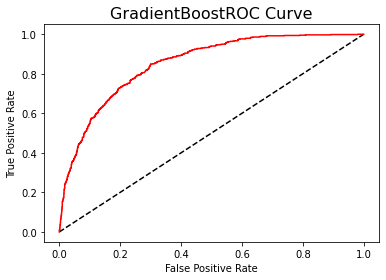

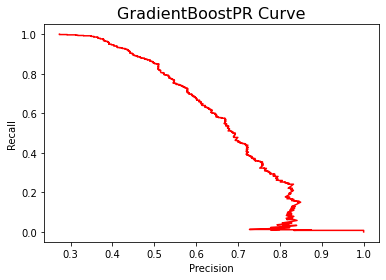

In [39]:
roc_curve_show(test_score['Churn'].astype('int').to_numpy(), test_score['prediction'].to_numpy(), 'GradientBoost')
pr_curve_show(test_score['Churn'].astype('int').to_numpy(), test_score['prediction'].to_numpy(), 'GradientBoost')

In [40]:
ks(test_score, 'Churn')

ks


,Events,count,binned,lower_limit,upper_limit,NonEvents,Events_Dist,NonEvents_Dist,Events_Cumm,NonEvents_Cumm,Events_Cumm_num,NonEvents_Cumm_num,KS,Precision,Capture
9,186,237,"(0.613, 0.839]",0.6130,0.8390,51,0.291536,0.029497,0.291536,0.029497,186,51,2.620392e+01,0.784810,0.291536
8,138,237,"(0.491, 0.613]",0.4910,0.6130,99,0.216301,0.057259,0.507837,0.086755,324,150,4.210816e+01,0.683544,0.507837
7,103,235,"(0.366, 0.491]",0.3660,0.4910,132,0.161442,0.076345,0.669279,0.163100,427,282,5.061789e+01,0.602257,0.669279
6,78,238,"(0.269, 0.366]",0.2690,0.3660,160,0.122257,0.092539,0.791536,0.255639,505,442,5.358970e+01,0.533263,0.791536
5,56,236,"(0.189, 0.269]",0.1890,0.2690,180,0.087774,0.104106,0.879310,0.359746,561,622,5.195648e+01,0.474218,0.879310
4,33,237,"(0.119, 0.189]",0.1190,0.1890,204,0.051724,0.117987,0.931034,0.477733,594,826,4.533017e+01,0.418310,0.931034
3,29,237,"(0.0713, 0.119]",0.0713,0.1190,208,0.045455,0.120301,0.976489,0.598034,623,1034,3.784555e+01,0.375981,0.976489
2,10,236,"(0.0445, 0.0713]",0.0445,0.0713,226,0.015674,0.130711,0.992163,0.728745,633,1260,2.634181e+01,0.334390,0.992163
1,3,237,"(0.0275, 0.0445]",0.0275,0.0445,234,0.004702,0.135338,0.996865,0.864083,636,1494,1.327819e+01,0.298592,0.996865
0,2,237,"(0.0125, 0.0275]",0.0125,0.0275,235,0.003135,0.135917,1.000000,1.000000,638,1729,-1.110223e-14,0.269540,1.000000


In [44]:
best_model.varimp(True)

,variable,relative_importance,scaled_importance,percentage
0,Contract,872.121155,1.000000,0.370991
1,OnlineSecurity,373.773773,0.428580,0.158999
2,tenure,231.181580,0.265080,0.098342
3,TechSupport,163.978622,0.188023,0.069755
4,OnlineBackup,158.936646,0.182241,0.067610
5,MonthlyCharges,156.730011,0.179711,0.066671
6,TotalCharges,131.534958,0.150822,0.055954
7,PaymentMethod,62.315159,0.071452,0.026508
8,PaperlessBilling,55.496338,0.063634,0.023608
9,InternetService,52.511261,0.060211,0.022338


In [54]:
feat_dict = {}
for col in feature_cols:
    feat_dict[col] = 0
    
for model in all_models:
    df = model.varimp(True)
    for i in range(5):
        var = df['variable'].iloc[i]
        per = df['percentage'].iloc[i]
        feat_dict[var] += per
        
print(feat_dict)
feats = pd.DataFrame.from_dict(feat_dict)

{'gender': 0,
 'SeniorCitizen': 0,
 'Partner': 0,
 'Dependents': 0,
 'PhoneService': 0.05813898555224055,
 'MultipleLines': 0,
 'InternetService': 0,
 'OnlineSecurity': 2.574551465887461,
 'OnlineBackup': 0.17339070043456384,
 'DeviceProtection': 0,
 'TechSupport': 0.3533089868773399,
 'StreamingTV': 0,
 'StreamingMovies': 0,
 'Contract': 7.888507353588434,
 'PaperlessBilling': 0,
 'PaymentMethod': 0.03710383123977065,
 'tenure': 4.778381439252546,
 'MonthlyCharges': 4.932957140222013,
 'TotalCharges': 4.143720420363798}

In [59]:
feats = pd.DataFrame.from_dict(feat_dict, orient = 'index')
feats.sort_values(0, ascending = False)[:10]

,0
Contract,7.888507
MonthlyCharges,4.932957
tenure,4.778381
TotalCharges,4.143720
OnlineSecurity,2.574551
TechSupport,0.353309
OnlineBackup,0.173391
PhoneService,0.058139
PaymentMethod,0.037104
StreamingMovies,0.000000
